### Demo of Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [4]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Autosaving every 180 seconds


In [5]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [6]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #10
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [7]:
idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

pc1 = np.load(fn1)

#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(gt[idx, 2:])

offset = 0#for debug 
rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# print(rot_m)

initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# pc1 = pc1 @ rot_m
# rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# pc1 = pc1 @ rotcorr
# pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [8]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses) #try commenting out

<IPython.core.display.Javascript object>


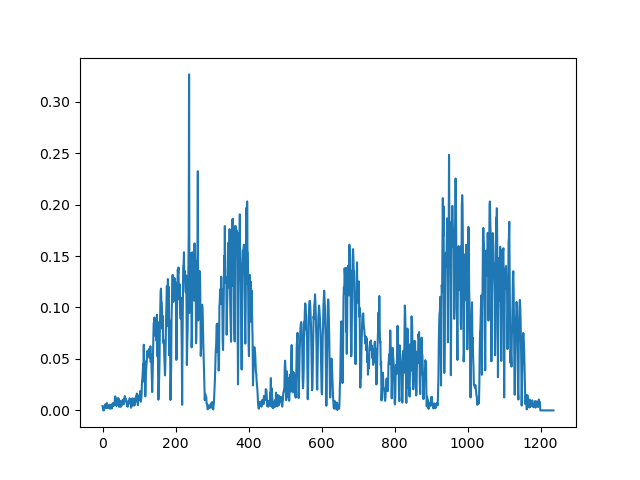

In [9]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [10]:
# idx = 2700 #2650 #2000 - 3000 is the running and swinging loop
# skip = 5 #how many lidar frames between clouds
# # (need to deal with how there are more LIDAR frames than ground truth poses)
# offset = 11 #10 #11  #works best for 05 dataset
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

idx = 1038 #1080 #950 #fast motion
# idx = 116 #slow distortion, very accurate solution
skip = 1 #how many lidar frames between clouds
offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#Rotate scans to align beginning of each scan with +X axis ----------
#IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
#           this is becuase overall trajectory begins at 05 (at least I think that's why)
#Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
#--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD
color = 255*np.linspace(0,1,len(scan1_lidarframe))
cname = np.array([255-color//2, color, 255-color]).T.tolist()
disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))

# # DRAW SCANS 1, 2
# disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
# disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314
plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run 12-State ICET

In [11]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

#scan to scan
# dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 50, niter = 10, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = 2.5, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


2023-06-13 11:45:18.412665: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


~~~~~~~~~~~Iteration  0 ~~~~~~~~~~


2023-06-13 11:45:20.218214: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1552: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]
2023-06-13 11:45:20.375388: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1b0ee0c0


LUT tf.Tensor([502   3   3], shape=(3,), dtype=int32)

 residuals (1506, 1)

 delta_A
 (12,)
A: 
 [ 0.0848  0.5489  0.5039  0.036   0.0409 -0.0403] 
 [-0.4637 -0.8571 -0.6026 -0.027  -0.0443 -0.0109]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([508   3   3], shape=(3,), dtype=int32)

 residuals (1524, 1)

 delta_A
 (12,)
A: 
 [ 0.0808  0.3953  0.4169  0.0324  0.0309 -0.0333] 
 [-0.3955 -0.6574 -0.74   -0.0713 -0.0246 -0.0726]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.0827  0.2602  0.3245  0.0244  0.0248 -0.0206] 
 [-0.305  -0.4189 -0.6471 -0.0715 -0.0205 -0.1243]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.0334  0.106   0.2194  0.0187  0.0211 -0.0118] 
 [-0.0849 -0.0889 -0.4723 -0.0575 -0.0184 -0.1527]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.1015 -0.1046 -0.0271 -0.0271  0.0241 -0.0011] 
 [ 0.2965  0.2363 -0.023   0.0349 -0.0387 -0.1834]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [-0.1043 -0.1108 -0.0291 -0.0273  0.0247  0.0001] 
 [ 0.295   0.2327 -0.0195  0.0351 -0.0393 -0.1878]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([505   3   3], shape=(3,), dtype=int32)

 residuals (1515, 1)

 delta_A
 (12,)
A: 
 [-0.0985 -0.1036 -0.0295 -0.0255  0.024   0.0002] 
 [ 0.2979  0.2368 -0.0129  0.0322 -0.0386 -0.1864]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [-0.1004 -0.1074 -0.0161 -0.0247  0.0256  0.0004] 
 [ 0.296   0.2359 -0.0422  0.0309 -0.0414 -0.1876]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [-0.1051 -0.1174 -0.0363 -0.0368  0.0303 -0.0042] 
 [ 0.2918  0.2317 -0.016   0.045  -0.0493 -0.1781]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [-0.106  -0.121  -0.0415 -0.0342  0.031  -0.0047] 
 [ 0.2912  0.2298 -0.0215  0.0387 -0.0485 -0.1777]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [-0.1074 -0.1236 -0.0423 -0.0359  0.0317 -0.0042] 
 [ 0.2906  0.2282 -0.0157  0.0416 -0.0496 -0.1789]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [-0.1093 -0.1233 -0.0472 -0.0369  0.0316 -0.0037] 
 [ 0.2898  0.2281 -0.0101  0.0422 -0.0491 -0.1803]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([514   3   3], shape=(3,), dtype=int32)

 

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [12]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #transformed scan

#need to downsample to keep runtime down
target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] #faster but slightly less accurate?
# target_cloud = torch.from_numpy(submap_lidarframe.astype(np.float32))[None,:,:] # tAkEs SooOoOO LoNg tO run...


dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(dc.cloud2_tensor))

Chamfer Distance OG: 
: 34279.26953125
Chamfer Distance after transform: 
: 17863.5546875

 Normalized OG CD: 
 tensor(0.6744)

 Normalized transformed CD: 
 tensor(0.3515)


# run VICP on single scan to submap

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [232]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    


 
 Frame # 950 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [-0.1966 -0.1897  0.0513  0.0136 -0.0379  0.0002] 
 [-0.1279  0.6365  0.5737  0.0627  0.0183  0.0542]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [-0.2088 -0.1817 -0.0244  0.0008 -0.0652 -0.015 ] 
 [-0.1391  0.6188  1.2023  0.1492  0.0288  0.1083]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [-0.2298 -0.0944 -0.0443  0.0065 -0.058  -0.0127] 
 [-0.1529  0.4451  1.1795  0.1432  0.0148  0.1347]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-0.1766 -0.0005  0.0113  0.0123 -0.0537 -0.0133] 
 [-0.1115  0.2097  1.0156  0.1322  0.0084  0.153

LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [ 0.1318 -0.3441  0.025   0.0035 -0.0538 -0.0267] 
 [0.0924 0.1988 0.086  0.1464 0.0647 0.1877]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([472   3   3], shape=(3,), dtype=int32)

 residuals (1416, 1)

 delta_A
 (12,)
A: 
 [ 0.1386 -0.3532  0.0244  0.004  -0.054  -0.0257] 
 [0.0961 0.2149 0.084  0.1449 0.0652 0.1867]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 residuals (1413, 1)

 delta_A
 (12,)
A: 
 [ 0.14   -0.3558  0.0157  0.0044 -0.0545 -0.0254] 
 [0.0962 0.2115 0.1001 0.145  0.0653 0.186 ]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 residuals (1413, 1)

 delta_A
 (12,)
A: 
 [ 0.1356 -0.3593  0.0123  0.0049 -0.0544 -0.0248] 
 [0.0939 0.2165 0.1021 0.1437 0.0653 0.1854]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 de

LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 residuals (1413, 1)

 delta_A
 (12,)
A: 
 [ 0.1078 -0.3555  0.0196  0.0211 -0.0686  0.0176] 
 [0.0793 0.2738 0.1213 0.1236 0.0832 0.1322]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 delta_A
 (12,)
A: 
 [ 0.106  -0.3524  0.0252  0.0216 -0.069   0.0188] 
 [0.0787 0.2719 0.1152 0.1228 0.0839 0.1308]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [ 0.1243 -0.3481  0.0276  0.0215 -0.0701  0.021 ] 
 [0.0886 0.2692 0.1185 0.1238 0.085  0.1276]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([472   3   3], shape=(3,), dtype=int32)

 residuals (1416, 1)

 delta_A
 (12,)
A: 
 [ 0.1069 -0.328   0.0273  0.0228 -0.0701  0.0219] 
 [0.0798 0.2346 0.1044 0.1207 0.0854 0.1273]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 residuals (1413, 1)

 de

LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [ 0.0205  0.4437  0.1703 -0.0058 -0.0015 -0.0009] 
 [ 0.0339 -0.9557  0.2018  0.063  -0.0733  0.2435]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [ 0.018   0.3932  0.2094 -0.0017 -0.0022  0.0013] 
 [ 0.0349 -0.8413  0.2024  0.0617 -0.0701  0.2404]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [ 0.0211  0.3859  0.1929 -0.0014 -0.0077  0.0009] 
 [ 0.0361 -0.8369  0.288   0.067  -0.0604  0.2407]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([397   3   3], shape=(3,), dtype=int32)

 residuals (1191, 1)

 delta_A
 (12,)
A: 
 [ 0.0209  0.3807  0.1927 -0.0011 -0.0093  0.    ] 
 [ 0.0362 -0.8268  0.2847  0.0654 -0.0555  0.242 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([398   3   3], shape=(3,), dtype=int32)

 r


 delta_A
 (12,)
A: 
 [ 0.0896  0.215   0.2023  0.0317 -0.0015  0.0098] 
 [ 0.0763 -0.6697 -0.2873 -0.0091 -0.0175  0.2516]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [ 0.1017  0.2074  0.1994  0.0318 -0.0019  0.0106] 
 [ 0.0843 -0.6534 -0.3026 -0.0106 -0.0159  0.2497]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [ 0.0749  0.2019  0.1844  0.0312 -0.0043  0.0103] 
 [ 0.0668 -0.65   -0.2747 -0.008  -0.0122  0.2488]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [ 0.0752  0.1856  0.166   0.0299 -0.0071  0.0104] 
 [ 0.0674 -0.6188 -0.2    -0.0011 -0.0078  0.2486]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [ 0.0778  0.1716  0.1583  0.0295 -

LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [ 0.1272 -0.0479  0.0506  0.0104 -0.0253  0.0082] 
 [ 0.1112 -0.2507  0.0405  0.0426  0.031   0.2398]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [ 0.1255 -0.0491  0.048   0.0101 -0.0256  0.0081] 
 [ 0.1101 -0.2482  0.0392  0.0428  0.0316  0.2402]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.1239 -0.0531  0.0477  0.0098 -0.0258  0.0081] 
 [ 0.1091 -0.2428  0.0399  0.0435  0.032   0.2401]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([406   3   3], shape=(3,), dtype=int32)

 residuals (1218, 1)

 delta_A
 (12,)
A: 
 [ 0.1242 -0.0586  0.0455  0.0095 -0.0259  0.0086] 
 [ 0.1097 -0.2304  0.0464  0.0444  0.0324  0.2395]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([406   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0871  0.4336  0.1498 -0.0261 -0.0242 -0.0357] 
 [ 0.0233 -0.8566  0.0633  0.0496 -0.0203  0.2739]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([374   3   3], shape=(3,), dtype=int32)

 residuals (1122, 1)

 delta_A
 (12,)
A: 
 [ 0.0888  0.4306  0.1521 -0.0249 -0.0241 -0.034 ] 
 [ 0.0246 -0.8487  0.0576  0.0489 -0.0204  0.2723]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0558  0.4268  0.1479 -0.0236 -0.0248 -0.0319] 
 [ 0.0064 -0.8386  0.0621  0.048  -0.0192  0.2697]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0488  0.4174  0.152  -0.0227 -0.0262 -0.0298] 
 [ 0.0027 -0.8205  0.0886  0.05   -0.0163  0.2673]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([378   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0705  0.2895  0.144  -0.0162 -0.0322 -0.0208] 
 [ 0.0271 -0.6336  0.0254  0.0421  0.0022  0.2581]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([374   3   3], shape=(3,), dtype=int32)

 residuals (1122, 1)

 delta_A
 (12,)
A: 
 [ 0.0679  0.2864  0.1428 -0.0159 -0.0327 -0.0201] 
 [ 0.0259 -0.6282  0.0258  0.0418  0.0031  0.257 ]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0738  0.2829  0.1461 -0.0157 -0.0332 -0.0206] 
 [ 0.0301 -0.6263  0.0215  0.0415  0.004   0.2576]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0756  0.2803  0.1446 -0.0156 -0.0336 -0.0202] 
 [ 0.0314 -0.6213  0.0175  0.0409  0.0044  0.2573]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0931  0.183   0.1199 -0.0163 -0.0337 -0.0207] 
 [ 0.0516 -0.4951  0.018   0.0405  0.0051  0.2564]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0916  0.181   0.1167 -0.0163 -0.0338 -0.0211] 
 [ 0.0507 -0.4942  0.021   0.0406  0.0053  0.257 ]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0828  0.1774  0.1185 -0.0164 -0.0335 -0.0205] 
 [ 0.0459 -0.4868  0.0153  0.0403  0.005   0.2561]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([376   3   3], shape=(3,), dtype=int32)

 residuals (1128, 1)

 delta_A
 (12,)
A: 
 [ 0.0745  0.1725  0.1202 -0.0162 -0.0336 -0.0201] 
 [ 0.0415 -0.4788  0.0205  0.0405  0.0055  0.2555]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([379   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([389   3   3], shape=(3,), dtype=int32)

 residuals (1167, 1)

 delta_A
 (12,)
A: 
 [ 0.542   0.3984 -0.2968 -0.0146 -0.0112  0.0326] 
 [-0.6173 -0.7671  0.4842  0.033  -0.0418  0.2351]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([388   3   3], shape=(3,), dtype=int32)

 residuals (1164, 1)

 delta_A
 (12,)
A: 
 [ 0.5443  0.3933 -0.2956 -0.0139 -0.0112  0.0323] 
 [-0.6158 -0.7644  0.4909  0.0324 -0.0422  0.2346]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([389   3   3], shape=(3,), dtype=int32)

 residuals (1167, 1)

 delta_A
 (12,)
A: 
 [ 0.5409  0.3901 -0.2988 -0.014  -0.0108  0.0313] 
 [-0.6183 -0.7669  0.5004  0.0332 -0.0432  0.2356]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.5365  0.3883 -0.3039 -0.0144 -0.0117  0.0323] 
 [-0.6219 -0.7665  0.5194  0.0344 -0.0419  0.2349]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([389   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.5223  0.2814 -0.2892 -0.016  -0.011   0.0302] 
 [-0.6295 -0.6644  0.5259  0.0367 -0.0444  0.2371]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [ 0.5223  0.277  -0.2914 -0.0159 -0.0105  0.0307] 
 [-0.6293 -0.6559  0.5267  0.0358 -0.045   0.2363]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.5252  0.2732 -0.2974 -0.0159 -0.0113  0.0302] 
 [-0.6274 -0.6534  0.5435  0.0371 -0.0438  0.2367]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [ 0.5264  0.2696 -0.301  -0.0155 -0.011   0.0305] 
 [-0.6264 -0.6465  0.5411  0.0356 -0.044   0.2363]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([393   3   3], shape=(3,), dtype=int32)

 residuals (1179, 1)

 delta_A
 (12,)
A: 
 [ 0.5286  0.1781 -0.322  -0.0149 -0.0083  0.0308] 
 [-0.6237 -0.5417  0.5697  0.037  -0.0491  0.2347]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [ 0.5284  0.1742 -0.3263 -0.0148 -0.0081  0.031 ] 
 [-0.6238 -0.5338  0.5757  0.0363 -0.0485  0.2345]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [ 0.5285  0.1719 -0.3246 -0.0146 -0.0082  0.0317] 
 [-0.6235 -0.5285  0.5687  0.0354 -0.0479  0.2334]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [ 0.5292  0.1693 -0.3241 -0.0143 -0.0081  0.032 ] 
 [-0.6229 -0.525   0.5692  0.0349 -0.0486  0.233 ]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 residuals (1314, 1)

 delta_A
 (12,)
A: 
 [ 1.0931  0.5236 -0.6072 -0.0471 -0.04    0.0009] 
 [-1.8684 -1.2802  1.0107  0.0512 -0.0667  0.1967]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 residuals (1314, 1)

 delta_A
 (12,)
A: 
 [ 1.0811  0.5154 -0.6088 -0.0466 -0.0368  0.0021] 
 [-1.8356 -1.2536  0.9781  0.0469 -0.071   0.1948]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([439   3   3], shape=(3,), dtype=int32)

 residuals (1317, 1)

 delta_A
 (12,)
A: 
 [ 1.103   0.5041 -0.6062 -0.0465 -0.0388  0.0007] 
 [-1.8436 -1.2296  0.9716  0.0478 -0.0679  0.1955]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [ 1.1229  0.4969 -0.6077 -0.0467 -0.039  -0.0001] 
 [-1.8516 -1.2086  0.9544  0.0465 -0.0676  0.1961]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([439   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([434   3   3], shape=(3,), dtype=int32)

 residuals (1302, 1)

 delta_A
 (12,)
A: 
 [ 0.9031  0.3258 -0.466  -0.0579 -0.0436  0.0008] 
 [-1.2846 -0.7829  0.6756  0.07   -0.0678  0.1921]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.8979  0.3194 -0.4573 -0.0578 -0.0435  0.0009] 
 [-1.2691 -0.768   0.6654  0.0703 -0.0683  0.1918]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.9065  0.307  -0.4528 -0.058  -0.0434 -0.0009] 
 [-1.2646 -0.7466  0.6536  0.0706 -0.0685  0.1932]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.9012  0.3081 -0.4609 -0.06   -0.0448 -0.0008] 
 [-1.2634 -0.7483  0.6798  0.0758 -0.0679  0.1945]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([434   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([431   3   3], shape=(3,), dtype=int32)

 residuals (1293, 1)

 delta_A
 (12,)
A: 
 [ 0.5529  0.1252 -0.249  -0.063  -0.0433 -0.0035] 
 [-0.6637 -0.4032  0.3232  0.0791 -0.0707  0.196 ]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.542   0.1236 -0.2454 -0.0636 -0.0437 -0.003 ] 
 [-0.6496 -0.3997  0.3208  0.0804 -0.0705  0.1957]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.5331  0.1167 -0.2405 -0.0639 -0.0436 -0.0033] 
 [-0.6338 -0.3873  0.3147  0.0811 -0.0705  0.1957]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [ 0.511   0.1115 -0.2324 -0.0638 -0.0426 -0.0026] 
 [-0.6026 -0.3757  0.2954  0.08   -0.0719  0.1949]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 residuals (1593, 1)

 delta_A
 (12,)
A: 
 [ 0.2363  0.0975 -0.1934 -0.0751 -0.0427  0.007 ] 
 [-0.2998 -0.1745  0.0641  0.0742 -0.1221  0.0962]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 residuals (1593, 1)

 delta_A
 (12,)
A: 
 [ 0.2241  0.0935 -0.187  -0.0752 -0.0429  0.0059] 
 [-0.2822 -0.1684  0.0562  0.0745 -0.1216  0.0976]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 residuals (1593, 1)

 delta_A
 (12,)
A: 
 [ 0.2106  0.088  -0.1832 -0.0755 -0.0431  0.0053] 
 [-0.2653 -0.1584  0.0514  0.0749 -0.1211  0.0985]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 residuals (1593, 1)

 delta_A
 (12,)
A: 
 [ 0.196   0.0859 -0.18   -0.076  -0.0434  0.0046] 
 [-0.2477 -0.1549  0.0523  0.0762 -0.1206  0.0997]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [-0.0681  0.023  -0.0669 -0.0807 -0.0425 -0.0059] 
 [ 0.1069 -0.0345 -0.1072  0.0816 -0.1201  0.1146]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [-0.0713  0.0238 -0.0606 -0.0809 -0.0427 -0.006 ] 
 [ 0.1109 -0.0361 -0.1185  0.0816 -0.1197  0.1148]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [-0.0744  0.0226 -0.0592 -0.0806 -0.0421 -0.0061] 
 [ 0.1158 -0.0339 -0.1255  0.0808 -0.1206  0.1149]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [-0.077   0.0212 -0.0609 -0.0805 -0.0436 -0.0062] 
 [ 0.1152 -0.032  -0.1174  0.0814 -0.1181  0.1152]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [-0.0996  0.0058 -0.0564 -0.0816 -0.0437 -0.0073] 
 [ 0.1544 -0.0042 -0.1122  0.0842 -0.1187  0.116 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.2536039   0.27953434 -0.29475    -0.04481321 -0.10618488  0.01262437], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 36862.390625
Chamfer Distance after VICET: 
: 13372.0625
Chamfer Distance after ICET: 
: 19725.373046875

 Normalized OG CD: 
 tensor(0.7264)

 Normalized VICET CD: 
 tensor(0.2635)

 Normalized ICET CD: 
 tensor(0.3887)

 
 Frame # 956 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 residuals (1728, 1)

 delta_A
 (12,)
A: 
 [ 0.1455  0.0434 -0.4393 -0.0245 -0.0357 -0.0004] 
 [-0.4457 -0.0988  0.1976 -0.0331 -0.0534  0.0114]
~~

LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.157   0.23   -0.1309 -0.1099 -0.0574 -0.0097] 
 [-0.2922 -0.1747  0.0228  0.0802 -0.1737  0.035 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [ 0.151   0.2279 -0.1313 -0.1097 -0.0572 -0.0095] 
 [-0.283  -0.1718  0.0232  0.0801 -0.1743  0.0347]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [ 0.1531  0.2268 -0.127  -0.1095 -0.057  -0.0093] 
 [-0.2839 -0.1715  0.0116  0.0789 -0.1744  0.0344]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [ 0.1506  0.2243 -0.128  -0.1093 -0.0569 -0.0095] 
 [-0.2827 -0.1691  0.0129  0.0787 -0.1746  0.0347]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.0954  0.1708 -0.111  -0.1093 -0.0566 -0.0093] 
 [-0.2057 -0.09   -0.0135  0.0785 -0.1741  0.0345]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.0979  0.1703 -0.1078 -0.1092 -0.0565 -0.0093] 
 [-0.2095 -0.0893 -0.0219  0.078  -0.1741  0.0345]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.1003  0.1682 -0.1076 -0.1092 -0.0565 -0.0094] 
 [-0.2109 -0.0864 -0.0223  0.0778 -0.1742  0.0345]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.1087  0.166  -0.1079 -0.1097 -0.057  -0.0098] 
 [-0.2232 -0.0826 -0.0149  0.0794 -0.1737  0.0349]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([745   3   3], shape=(3,), dtype=int32)

 residuals (2235, 1)

 delta_A
 (12,)
A: 
 [ 0.4152  0.1201 -0.1774 -0.0515 -0.0177  0.0136] 
 [-0.7049  0.1478 -0.6132 -0.1253 -0.1135 -0.0283]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([746   3   3], shape=(3,), dtype=int32)

 residuals (2238, 1)

 delta_A
 (12,)
A: 
 [ 0.2326  0.0153 -0.0649 -0.0574 -0.0023  0.0148] 
 [-0.4215  0.3302 -0.8552 -0.1277 -0.1394 -0.0382]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([744   3   3], shape=(3,), dtype=int32)

 residuals (2232, 1)

 delta_A
 (12,)
A: 
 [ 0.0888 -0.1072  0.0355 -0.0617  0.0105  0.0173] 
 [-0.1998  0.5577 -1.0601 -0.1314 -0.1613 -0.0524]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([745   3   3], shape=(3,), dtype=int32)

 residuals (2235, 1)

 delta_A
 (12,)
A: 
 [-0.038  -0.2102  0.1096 -0.0678  0.0155  0.0171] 
 [-0.0474  0.7291 -1.1736 -0.1242 -0.1707 -0.0592]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([745   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([751   3   3], shape=(3,), dtype=int32)

 residuals (2253, 1)

 delta_A
 (12,)
A: 
 [-0.079   0.0106  0.1838 -0.0665  0.021   0.0035] 
 [-0.1569  0.3498 -1.3847 -0.1401 -0.1662 -0.0618]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 residuals (2256, 1)

 delta_A
 (12,)
A: 
 [-0.0787  0.0118  0.1875 -0.0671  0.0205  0.003 ] 
 [-0.1594  0.3444 -1.396  -0.1387 -0.1651 -0.0614]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([751   3   3], shape=(3,), dtype=int32)

 residuals (2253, 1)

 delta_A
 (12,)
A: 
 [-0.0752  0.0219  0.1893 -0.0656  0.0218  0.0029] 
 [-0.1634  0.3154 -1.4132 -0.144  -0.1664 -0.0606]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([751   3   3], shape=(3,), dtype=int32)

 residuals (2253, 1)

 delta_A
 (12,)
A: 
 [-0.0781  0.027   0.1962 -0.0656  0.0224  0.0032] 
 [-0.1685  0.314  -1.4284 -0.1442 -0.1668 -0.0611]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([751   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 residuals (2256, 1)

 delta_A
 (12,)
A: 
 [-0.0766  0.0561  0.2167 -0.0621  0.0248  0.0045] 
 [-0.1945  0.2545 -1.5325 -0.1576 -0.1633 -0.0677]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 residuals (2256, 1)

 delta_A
 (12,)
A: 
 [-0.0796  0.0555  0.2179 -0.0622  0.0247  0.0047] 
 [-0.1974  0.2561 -1.5377 -0.1574 -0.1636 -0.0677]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 residuals (2256, 1)

 delta_A
 (12,)
A: 
 [-0.0774  0.058   0.2239 -0.0621  0.0254  0.0049] 
 [-0.1991  0.2509 -1.5498 -0.158  -0.1638 -0.0683]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 residuals (2256, 1)

 delta_A
 (12,)
A: 
 [-0.0743  0.0546  0.2237 -0.0617  0.0259  0.0051] 
 [-0.1965  0.2538 -1.5516 -0.1599 -0.1649 -0.0687]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([752   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([725   3   3], shape=(3,), dtype=int32)

 residuals (2175, 1)

 delta_A
 (12,)
A: 
 [ 0.5827 -0.0351  0.1167 -0.056   0.0004 -0.0356] 
 [-1.2231  0.5477 -0.8134 -0.1282 -0.1638 -0.0648]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([725   3   3], shape=(3,), dtype=int32)

 residuals (2175, 1)

 delta_A
 (12,)
A: 
 [ 0.6323  0.0251  0.118  -0.056  -0.0002 -0.0414] 
 [-1.2904  0.4115 -0.7859 -0.1264 -0.1678 -0.0561]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([729   3   3], shape=(3,), dtype=int32)

 residuals (2187, 1)

 delta_A
 (12,)
A: 
 [ 0.6734  0.0751  0.1216 -0.0563 -0.     -0.0451] 
 [-1.3312  0.3051 -0.7559 -0.1243 -0.1758 -0.0509]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([728   3   3], shape=(3,), dtype=int32)

 residuals (2184, 1)

 delta_A
 (12,)
A: 
 [ 0.6747  0.0944  0.1037 -0.0595 -0.0026 -0.045 ] 
 [-1.3021  0.2644 -0.6259 -0.1104 -0.1783 -0.0556]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([725   3   3], shape=(3,), dtype=int32)

 re

LUT tf.Tensor([712   3   3], shape=(3,), dtype=int32)

 residuals (2136, 1)

 delta_A
 (12,)
A: 
 [ 0.3451  0.137   0.0044 -0.0734 -0.0005 -0.0053] 
 [-0.7116  0.1236 -0.2823 -0.0644 -0.2067 -0.1429]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
LUT tf.Tensor([712   3   3], shape=(3,), dtype=int32)

 residuals (2136, 1)

 delta_A
 (12,)
A: 
 [ 0.3419  0.1306  0.004  -0.0734 -0.0007 -0.0049] 
 [-0.7042  0.1325 -0.2811 -0.0642 -0.2062 -0.1435]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([713   3   3], shape=(3,), dtype=int32)

 residuals (2139, 1)

 delta_A
 (12,)
A: 
 [ 0.3439  0.127   0.0077 -0.0735 -0.0003 -0.005 ] 
 [-0.7063  0.1377 -0.2885 -0.0642 -0.2072 -0.1432]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.3409  0.1227  0.008  -0.0737 -0.0004 -0.0047] 
 [-0.7005  0.1451 -0.2861 -0.0639 -0.2069 -0.1437]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([713   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([716   3   3], shape=(3,), dtype=int32)

 residuals (2148, 1)

 delta_A
 (12,)
A: 
 [ 0.3686  0.0539  0.0223 -0.075  -0.0015 -0.0069] 
 [-0.7272  0.2381 -0.2902 -0.0597 -0.2055 -0.14  ]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([715   3   3], shape=(3,), dtype=int32)

 residuals (2145, 1)

 delta_A
 (12,)
A: 
 [ 0.3685  0.053   0.0225 -0.0749 -0.0016 -0.0069] 
 [-0.7264  0.2394 -0.2908 -0.0599 -0.2055 -0.1401]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([715   3   3], shape=(3,), dtype=int32)

 residuals (2145, 1)

 delta_A
 (12,)
A: 
 [ 0.3703  0.0524  0.0222 -0.0748 -0.0015 -0.0069] 
 [-0.7273  0.2405 -0.2908 -0.0601 -0.2057 -0.1401]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([715   3   3], shape=(3,), dtype=int32)

 residuals (2145, 1)

 delta_A
 (12,)
A: 
 [ 0.3673  0.0514  0.0234 -0.075  -0.0016 -0.0066] 
 [-0.7236  0.243  -0.2913 -0.0597 -0.2054 -0.1405]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([715   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([636   3   3], shape=(3,), dtype=int32)

 residuals (1908, 1)

 delta_A
 (12,)
A: 
 [ 0.4179 -0.0447  0.1335 -0.0812  0.0351 -0.0552] 
 [-0.8217  0.5899 -0.2993 -0.0778 -0.1038 -0.1084]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.4024 -0.0116  0.1183 -0.0796  0.0375 -0.0532] 
 [-0.8096  0.527  -0.337  -0.0905 -0.1113 -0.1132]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.3979  0.0372  0.1111 -0.0783  0.0398 -0.0503] 
 [-0.8034  0.4477 -0.3539 -0.0979 -0.1166 -0.1189]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [ 0.3522  0.0678  0.0971 -0.0773  0.0414 -0.0468] 
 [-0.7215  0.3997 -0.3482 -0.1029 -0.1199 -0.1267]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.1151 -0.1619 -0.0131 -0.0744  0.05   -0.0094] 
 [-0.2491  0.6694 -0.1646 -0.1099 -0.1426 -0.2136]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.1171 -0.1664 -0.0122 -0.0747  0.0498 -0.0091] 
 [-0.2511  0.6754 -0.1645 -0.1092 -0.1424 -0.2139]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.124  -0.1643 -0.01   -0.0748  0.0498 -0.0092] 
 [-0.2626  0.6729 -0.1671 -0.1089 -0.1426 -0.2137]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.1283 -0.167  -0.0089 -0.075   0.0497 -0.0092] 
 [-0.2712  0.6754 -0.1666 -0.1083 -0.1423 -0.2137]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.1351 -0.1655  0.0007 -0.0754  0.0502 -0.0081] 
 [-0.2785  0.6701 -0.1853 -0.109  -0.1436 -0.2152]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.1319 -0.1661  0.0005 -0.0753  0.0504 -0.0081] 
 [-0.2705  0.6704 -0.1865 -0.1092 -0.1438 -0.2152]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.1386 -0.1672  0.0006 -0.0754  0.0504 -0.0082] 
 [-0.2841  0.6719 -0.1877 -0.1095 -0.1439 -0.2152]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.1331 -0.1679 -0.0001 -0.0754  0.0502 -0.008 ] 
 [-0.2724  0.6735 -0.1839 -0.109  -0.1435 -0.2155]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([515   3   3], shape=(3,), dtype=int32)

 residuals (1545, 1)

 delta_A
 (12,)
A: 
 [ 1.8089  0.1159 -0.0948 -0.0658 -0.0483  0.0301] 
 [-3.5899  0.5722  0.6226  0.1875  0.1259 -0.2565]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([515   3   3], shape=(3,), dtype=int32)

 residuals (1545, 1)

 delta_A
 (12,)
A: 
 [ 1.8282  0.1512 -0.1081 -0.0619 -0.0463  0.0297] 
 [-3.6178  0.489   0.6329  0.1753  0.1211 -0.2553]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 1.8122  0.2083 -0.1244 -0.0581 -0.0455  0.0302] 
 [-3.5772  0.3792  0.6616  0.1641  0.1187 -0.2545]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 1.8662  0.2437 -0.1382 -0.0565 -0.0441  0.03  ] 
 [-3.6764  0.3184  0.6948  0.1579  0.117  -0.2533]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [ 1.0597  0.6551 -0.1567 -0.0245  0.043   0.0625] 
 [-2.0977 -0.716   0.3703 -0.0364 -0.0479 -0.3562]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([502   3   3], shape=(3,), dtype=int32)

 residuals (1506, 1)

 delta_A
 (12,)
A: 
 [ 1.0778  0.6581 -0.1423 -0.0247  0.042   0.0611] 
 [-2.1277 -0.7086  0.3698 -0.0353 -0.048  -0.3536]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([502   3   3], shape=(3,), dtype=int32)

 residuals (1506, 1)

 delta_A
 (12,)
A: 
 [ 1.0808  0.6701 -0.1308 -0.0253  0.0418  0.0592] 
 [-2.135  -0.7192  0.3659 -0.0319 -0.0482 -0.3498]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([505   3   3], shape=(3,), dtype=int32)

 residuals (1515, 1)

 delta_A
 (12,)
A: 
 [ 1.0721  0.6736 -0.1283 -0.0242  0.0421  0.0578] 
 [-2.1215 -0.7171  0.3645 -0.0332 -0.0493 -0.3468]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([505   3   3], shape=(3,), dtype=int32)

 residuals (1515, 1)

 delta_A
 (12,)
A: 
 [ 1.2434  0.5543 -0.0699 -0.0323  0.0399  0.0645] 
 [-2.4114 -0.568   0.3196 -0.0082 -0.0447 -0.3497]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [ 1.2094  0.5948 -0.0629 -0.0304  0.0399  0.0603] 
 [-2.3358 -0.6058  0.3281 -0.0117 -0.0457 -0.3435]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [ 1.1639  0.6568 -0.0642 -0.0293  0.0404  0.0577] 
 [-2.2717 -0.6641  0.3212 -0.0145 -0.0475 -0.3401]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([505   3   3], shape=(3,), dtype=int32)

 residuals (1515, 1)

 delta_A
 (12,)
A: 
 [ 1.1737  0.6673 -0.081  -0.0279  0.0415  0.0569] 
 [-2.3277 -0.6823  0.3257 -0.0195 -0.0492 -0.3386]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([460   3   3], shape=(3,), dtype=int32)

 residuals (1380, 1)

 delta_A
 (12,)
A: 
 [ 0.1147 -0.1854  0.0414 -0.0297  0.0194  0.0144] 
 [-0.2166  0.5585 -0.0096 -0.0484  0.0067 -0.3491]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([460   3   3], shape=(3,), dtype=int32)

 residuals (1380, 1)

 delta_A
 (12,)
A: 
 [ 0.1203 -0.1687  0.0507 -0.0295  0.0202  0.0143] 
 [-0.2258  0.5322 -0.0238 -0.0486  0.0051 -0.348 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([459   3   3], shape=(3,), dtype=int32)

 residuals (1377, 1)

 delta_A
 (12,)
A: 
 [ 0.1195 -0.1679  0.0436 -0.029   0.0204  0.0148] 
 [-0.2306  0.532  -0.0134 -0.0498  0.0055 -0.3493]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 residuals (1374, 1)

 delta_A
 (12,)
A: 
 [ 0.1245 -0.158   0.0403 -0.0286  0.0208  0.015 ] 
 [-0.2383  0.5152 -0.0115 -0.0506  0.0051 -0.3493]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 delta_A
 (12,)
A: 
 [ 0.3006 -0.0804 -0.0133 -0.0277  0.0242  0.026 ] 
 [-0.6038  0.3675  0.0793 -0.0477  0.0016 -0.3672]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 delta_A
 (12,)
A: 
 [ 0.3164 -0.0656 -0.0197 -0.0273  0.0246  0.0252] 
 [-0.6305  0.345   0.0882 -0.0487  0.0009 -0.364 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 delta_A
 (12,)
A: 
 [ 0.313  -0.0715 -0.0149 -0.0278  0.0247  0.0268] 
 [-0.6394  0.3497  0.0903 -0.0458  0.0012 -0.3687]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [ 0.3416 -0.0578 -0.0192 -0.0276  0.0253  0.0256] 
 [-0.6735  0.3588  0.0912 -0.0471 -0.0004 -0.3617]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [ 0.7601 -0.0215 -0.025  -0.0364  0.0276  0.0438] 
 [-1.5791  0.3165  0.133  -0.0089 -0.0075 -0.3834]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([449   3   3], shape=(3,), dtype=int32)

 residuals (1347, 1)

 delta_A
 (12,)
A: 
 [ 0.7907 -0.018  -0.0288 -0.0359  0.0281  0.0461] 
 [-1.6175  0.3179  0.1362 -0.0109 -0.0075 -0.3859]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([449   3   3], shape=(3,), dtype=int32)

 residuals (1347, 1)

 delta_A
 (12,)
A: 
 [ 0.8037 -0.0161 -0.0161 -0.0361  0.03    0.0479] 
 [-1.6518  0.3219  0.1089 -0.0117 -0.011  -0.3894]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [ 0.8282 -0.0171 -0.0285 -0.0357  0.0303  0.049 ] 
 [-1.7053  0.3198  0.1258 -0.0122 -0.0104 -0.3911]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([449   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([421   3   3], shape=(3,), dtype=int32)

 residuals (1263, 1)

 delta_A
 (12,)
A: 
 [0.5396 0.3043 0.7161 0.0575 0.0438 0.0178] 
 [-1.1194 -0.1861 -1.4987 -0.1759 -0.0615 -0.3222]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 residuals (1251, 1)

 delta_A
 (12,)
A: 
 [0.5349 0.308  0.7641 0.0592 0.038  0.018 ] 
 [-1.1218 -0.1828 -1.66   -0.1991 -0.0444 -0.3228]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 residuals (1251, 1)

 delta_A
 (12,)
A: 
 [0.5449 0.2851 0.7348 0.0561 0.0439 0.0166] 
 [-1.1094 -0.1144 -1.556  -0.1752 -0.0596 -0.3183]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 residuals (1251, 1)

 delta_A
 (12,)
A: 
 [0.5364 0.3086 0.7815 0.0597 0.0383 0.0169] 
 [-1.1236 -0.1603 -1.709  -0.2025 -0.0445 -0.3199]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([413   3   3], shape=(3,), dtype=int32)

 residuals (1239, 1)

 de

LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [0.5173 0.0405 0.8928 0.0435 0.0432 0.0041] 
 [-1.0342  0.4767 -1.8421 -0.1498 -0.0681 -0.2803]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [0.5156 0.0323 0.9031 0.0435 0.0426 0.0033] 
 [-1.0336  0.4913 -1.8606 -0.15   -0.067  -0.2781]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [0.5113 0.0293 0.9144 0.0435 0.0419 0.0031] 
 [-1.0347  0.4943 -1.8785 -0.1499 -0.0656 -0.2785]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [0.5147 0.0289 0.9206 0.0432 0.0417 0.0029] 
 [-1.0328  0.496  -1.8928 -0.1507 -0.0653 -0.2774]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 de

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.02844107  0.37918532 -0.48155558 -0.00854734  0.06032695 -0.11435003], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 53455.8125
Chamfer Distance after VICET: 
: 16105.9775390625
Chamfer Distance after ICET: 
: 40015.0859375

 Normalized OG CD: 
 tensor(1.3141)

 Normalized VICET CD: 
 tensor(0.3959)

 Normalized ICET CD: 
 tensor(0.9837)

 
 Frame # 963 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([368   3   3], shape=(3,), dtype=int32)

 residuals (1104, 1)

 delta_A
 (12,)
A: 
 [-0.0217 -0.1223  0.0906  0.0486  0.019  -0.0208] 
 [-0.0229 -0.0094 -0.3786 -0.0492  0.018  -0.0185]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [-0.0854 -0.1838  0.1572  0.0532  0.0113 -0.0307] 
 [-0.0504  0.009

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0862 -1.1881  0.2161 -0.0449 -0.143  -0.2579] 
 [-0.1336  3.4144 -1.5697  0.1048  0.3597  0.3958]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.1149 -1.1643  0.4283 -0.0759 -0.1298 -0.2512] 
 [-0.1101  3.312  -1.9537  0.1375  0.3338  0.3697]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [ 0.1155 -1.0956  0.6255 -0.109  -0.1093 -0.2431] 
 [-0.1009  3.1248 -2.2982  0.1882  0.2988  0.3416]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([331   3   3], shape=(3,), dtype=int32)

 residuals (993, 1)

 delta_A
 (12,)
A: 
 [ 0.0878 -1.1318  0.6415 -0.1236 -0.1144 -0.2499] 
 [-0.1114  3.1079 -2.2941  0.2282  0.3173  0.34  ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [-0.1603 -0.7581  0.7958 -0.1028 -0.05   -0.1175] 
 [-0.1056  1.4552 -1.7793  0.1949  0.1349  0.0651]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [-0.1659 -0.7533  0.7754 -0.1016 -0.0504 -0.115 ] 
 [-0.1043  1.4295 -1.7299  0.1953  0.1342  0.0588]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([405   3   3], shape=(3,), dtype=int32)

 residuals (1215, 1)

 delta_A
 (12,)
A: 
 [-0.1521 -0.7185  0.7172 -0.1066 -0.0478 -0.1075] 
 [-0.0912  1.3711 -1.6079  0.2077  0.1295  0.0459]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([412   3   3], shape=(3,), dtype=int32)

 residuals (1236, 1)

 delta_A
 (12,)
A: 
 [-0.1547 -0.7094  0.6703 -0.1091 -0.0466 -0.1017] 
 [-0.0873  1.3256 -1.5166  0.2147  0.1257  0.03  ]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([414   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [-0.3882 -0.0538 -0.6344  0.0819 -0.0505 -0.0197] 
 [ 0.3228 -0.3503  0.8173  0.094  -0.0343 -0.0041]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [-0.3843 -0.0453 -0.6209  0.0937 -0.067  -0.0164] 
 [ 0.3241 -0.3451  0.8158  0.0808 -0.0143 -0.0104]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([499   3   3], shape=(3,), dtype=int32)

 residuals (1497, 1)

 delta_A
 (12,)
A: 
 [-0.365  -0.0048 -0.6     0.0995 -0.0778 -0.0125] 
 [ 0.3354 -0.3928  0.795   0.076  -0.0027 -0.0158]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [-0.3499  0.0227 -0.5516  0.102  -0.0862 -0.0097] 
 [ 0.3429 -0.4228  0.7348  0.0754  0.0054 -0.0205]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 resi


 delta_A
 (12,)
A: 
 [-0.1489  0.6383 -0.2385  0.0474 -0.1455 -0.0334] 
 [ 0.6776 -1.3529  0.381   0.1548  0.0481  0.0218]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [-0.1467  0.6574 -0.2663  0.0478 -0.1463 -0.0348] 
 [ 0.6822 -1.3948  0.4306  0.1555  0.0507  0.0245]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([482   3   3], shape=(3,), dtype=int32)

 residuals (1446, 1)

 delta_A
 (12,)
A: 
 [-0.1462  0.6596 -0.279   0.048  -0.1473 -0.0364] 
 [ 0.6834 -1.4073  0.4537  0.1554  0.0527  0.0268]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [-0.1426  0.6778 -0.2824  0.0487 -0.1488 -0.0374] 
 [ 0.6883 -1.4422  0.4654  0.1543  0.0549  0.0288]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([483   3   3], shape=(3,), dtype=int32)

 residuals (1449, 1)

 delta_A
 (12,)
A: 
 [-0.1374  0.7027 -0.2811  0.0483 -

LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [ 0.0007  1.2726 -0.4853  0.0398 -0.1686 -0.0611] 
 [ 0.8725 -2.6319  0.9116  0.1679  0.0861  0.0929]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 residuals (1413, 1)

 delta_A
 (12,)
A: 
 [ 0.0032  1.2851 -0.4901  0.0409 -0.1697 -0.0611] 
 [ 0.8762 -2.6546  0.9252  0.1658  0.0882  0.0932]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [ 0.0128  1.3379 -0.5019  0.04   -0.1686 -0.061 ] 
 [ 0.8899 -2.7487  0.9435  0.1681  0.0862  0.0955]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 delta_A
 (12,)
A: 
 [ 0.0174  1.3343 -0.5063  0.0387 -0.168  -0.0623] 
 [ 0.8919 -2.7545  0.9505  0.169   0.0854  0.0975]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([467   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([579   3   3], shape=(3,), dtype=int32)

 residuals (1737, 1)

 delta_A
 (12,)
A: 
 [-0.6715  0.6434 -0.7918  0.1131 -0.0446 -0.0307] 
 [ 1.3956 -1.7731  0.8877  0.1153 -0.089   0.0679]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([579   3   3], shape=(3,), dtype=int32)

 residuals (1737, 1)

 delta_A
 (12,)
A: 
 [-0.6701  0.638  -0.7944  0.1149 -0.047  -0.0324] 
 [ 1.3907 -1.7343  0.8885  0.1121 -0.0865  0.0698]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([579   3   3], shape=(3,), dtype=int32)

 residuals (1737, 1)

 delta_A
 (12,)
A: 
 [-0.6679  0.7156 -0.8036  0.1177 -0.0503 -0.0356] 
 [ 1.4165 -1.8573  0.9043  0.1091 -0.0823  0.0776]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([577   3   3], shape=(3,), dtype=int32)

 residuals (1731, 1)

 delta_A
 (12,)
A: 
 [-0.6494  0.7427 -0.8097  0.12   -0.0523 -0.0367] 
 [ 1.434  -1.907   0.9077  0.106  -0.0797  0.0796]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([575   3   3], shape=(3,), dtype=int32)

 residuals (1725, 1)

 delta_A
 (12,)
A: 
 [-0.6789  1.2777 -0.8939  0.1605 -0.0576 -0.0425] 
 [ 1.6493 -3.0105  0.9402  0.0443 -0.0687  0.0899]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 residuals (1710, 1)

 delta_A
 (12,)
A: 
 [-0.6863  1.2723 -0.9087  0.1595 -0.0573 -0.0429] 
 [ 1.655  -3.0578  0.9686  0.0463 -0.0687  0.083 ]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([569   3   3], shape=(3,), dtype=int32)

 residuals (1707, 1)

 delta_A
 (12,)
A: 
 [-0.7033  1.3304 -0.914   0.16   -0.0591 -0.0435] 
 [ 1.6787 -3.1902  0.9886  0.0449 -0.0665  0.0799]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([571   3   3], shape=(3,), dtype=int32)

 residuals (1713, 1)

 delta_A
 (12,)
A: 
 [-0.7068  1.3689 -0.9154  0.1601 -0.0591 -0.0448] 
 [ 1.6956 -3.2663  0.9925  0.0432 -0.0666  0.0803]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([571   3   3], shape=(3,), dtype=int32)

 residuals (1713, 1)

 delta_A
 (12,)
A: 
 [-0.6296  1.3102 -1.0176  0.1845 -0.0406 -0.0288] 
 [ 1.6435 -3.0099  0.9848 -0.0004 -0.0816  0.0426]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([571   3   3], shape=(3,), dtype=int32)

 residuals (1713, 1)

 delta_A
 (12,)
A: 
 [-0.6457  1.276  -0.9978  0.1875 -0.0407 -0.0254] 
 [ 1.6155 -2.9425  0.9479 -0.0063 -0.0822  0.0351]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.6289  1.2227 -1.0076  0.1852 -0.0389 -0.0217] 
 [ 1.585  -2.7809  0.9714 -0.0027 -0.0836  0.0329]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.6342  1.0826 -1.0277  0.1818 -0.0355 -0.0213] 
 [ 1.5302 -2.559   1.0026  0.0039 -0.0871  0.0269]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([573   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2633 -0.1684  0.1485  0.0457 -0.1215  0.043 ] 
 [-0.4984  0.2683 -0.0902  0.2625  0.012   0.0473]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2556 -0.163   0.1501  0.0457 -0.1214  0.0427] 
 [-0.4828  0.2554 -0.0927  0.2625  0.0118  0.0479]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([614   3   3], shape=(3,), dtype=int32)

 residuals (1842, 1)

 delta_A
 (12,)
A: 
 [ 0.2552 -0.1569  0.1523  0.0455 -0.1213  0.0425] 
 [-0.4818  0.2415 -0.0974  0.2625  0.0117  0.0483]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([614   3   3], shape=(3,), dtype=int32)

 residuals (1842, 1)

 delta_A
 (12,)
A: 
 [ 0.2482 -0.1526  0.1522  0.0455 -0.1214  0.0422] 
 [-0.4646  0.2317 -0.0966  0.2626  0.0118  0.0489]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([614   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.1231 -0.1177  0.1561  0.0439 -0.1213  0.0358] 
 [-0.1892  0.0994 -0.1067  0.2645  0.0108  0.0555]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.1235 -0.118   0.1572  0.0437 -0.1213  0.0358] 
 [-0.1888  0.0994 -0.1083  0.2648  0.0106  0.0554]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.1231 -0.1182  0.1568  0.0437 -0.1214  0.0358] 
 [-0.1892  0.0991 -0.1069  0.265   0.0108  0.0555]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.1179 -0.1214  0.1564  0.0438 -0.1214  0.0358] 
 [-0.1786  0.1061 -0.1067  0.2646  0.0109  0.0554]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.0794 -0.1267  0.1578  0.0432 -0.1212  0.034 ] 
 [-0.1033  0.0966 -0.1108  0.2653  0.0104  0.0569]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.0739 -0.1256  0.1563  0.0432 -0.1213  0.034 ] 
 [-0.0905  0.0946 -0.1075  0.2653  0.0107  0.0569]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.0792 -0.123   0.1573  0.0433 -0.1212  0.0339] 
 [-0.1024  0.0897 -0.1111  0.2651  0.0105  0.0573]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.0758 -0.1239  0.1562  0.0432 -0.1213  0.0338] 
 [-0.0941  0.0902 -0.1075  0.2654  0.0107  0.0572]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([521   3   3], shape=(3,), dtype=int32)

 residuals (1563, 1)

 delta_A
 (12,)
A: 
 [ 1.0569 -0.002  -0.1602  0.0327 -0.0335  0.0021] 
 [-1.6071 -0.1102  0.8701  0.1771 -0.0249  0.1784]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 residuals (1566, 1)

 delta_A
 (12,)
A: 
 [ 1.0598 -0.01   -0.1697  0.0325 -0.0344  0.0033] 
 [-1.6022 -0.0983  0.8996  0.1772 -0.0252  0.1773]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([521   3   3], shape=(3,), dtype=int32)

 residuals (1563, 1)

 delta_A
 (12,)
A: 
 [ 1.0658 -0.0172 -0.1782  0.0328 -0.0349  0.0045] 
 [-1.5958 -0.0914  0.9279  0.176  -0.026   0.1755]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 residuals (1566, 1)

 delta_A
 (12,)
A: 
 [ 1.0621 -0.0318 -0.1721  0.0342 -0.0345  0.0055] 
 [-1.6024 -0.0724  0.874   0.1724 -0.0227  0.1738]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([518   3   3], shape=(3,), dtype=int32)

 residuals (1554, 1)

 delta_A
 (12,)
A: 
 [ 1.0282 -0.2883 -0.2701  0.0397 -0.0408  0.0366] 
 [-1.5764  0.3657  1.209   0.1591 -0.0385  0.124 ]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([518   3   3], shape=(3,), dtype=int32)

 residuals (1554, 1)

 delta_A
 (12,)
A: 
 [ 1.0357 -0.2959 -0.2662  0.0407 -0.0416  0.0368] 
 [-1.5758  0.3688  1.1607  0.1574 -0.0318  0.1225]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([519   3   3], shape=(3,), dtype=int32)

 residuals (1557, 1)

 delta_A
 (12,)
A: 
 [ 1.0327 -0.2927 -0.2678  0.04   -0.0443  0.038 ] 
 [-1.5801  0.3542  1.13    0.1618 -0.0209  0.1209]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([521   3   3], shape=(3,), dtype=int32)

 residuals (1563, 1)

 delta_A
 (12,)
A: 
 [ 1.027  -0.2926 -0.2734  0.0403 -0.0447  0.0399] 
 [-1.58    0.3616  1.1595  0.1615 -0.0222  0.1204]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([521   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 residuals (1518, 1)

 delta_A
 (12,)
A: 
 [ 1.0347 -0.2667 -0.3141  0.0515 -0.0578  0.0816] 
 [-1.5341  0.2985  1.3996  0.1419 -0.0286  0.0642]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [ 1.0416 -0.2742 -0.3139  0.0515 -0.059   0.0817] 
 [-1.5305  0.3137  1.4004  0.1419 -0.0249  0.0631]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 residuals (1518, 1)

 delta_A
 (12,)
A: 
 [ 1.0276 -0.2708 -0.3122  0.0505 -0.0593  0.0808] 
 [-1.5379  0.2996  1.4005  0.1437 -0.0244  0.0671]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([505   3   3], shape=(3,), dtype=int32)

 residuals (1515, 1)

 delta_A
 (12,)
A: 
 [ 1.0251 -0.2583 -0.3126  0.0501 -0.0596  0.0788] 
 [-1.5392  0.2733  1.3983  0.1468 -0.0257  0.0705]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([501   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([424   3   3], shape=(3,), dtype=int32)

 residuals (1272, 1)

 delta_A
 (12,)
A: 
 [ 0.2729 -0.2348 -0.1166  0.0145 -0.0336  0.0198] 
 [ 0.1581 -0.0721  0.4228  0.0569  0.0226  0.1947]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [ 0.3048 -0.2352 -0.1084  0.0151 -0.0322  0.0183] 
 [ 0.1813 -0.0736  0.3875  0.0534  0.024   0.1972]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([426   3   3], shape=(3,), dtype=int32)

 residuals (1278, 1)

 delta_A
 (12,)
A: 
 [ 0.2961 -0.2316 -0.1136  0.0153 -0.0309  0.0175] 
 [ 0.1757 -0.0939  0.3601  0.0513  0.0229  0.1973]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [ 0.2694 -0.2358 -0.123   0.0139 -0.0325  0.0166] 
 [ 0.1575 -0.0897  0.393   0.0558  0.0252  0.1985]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([426   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [ 0.1774 -0.2671 -0.0457  0.0018 -0.0318 -0.0016] 
 [0.1054 0.0498 0.308  0.0764 0.0486 0.2237]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [ 0.1672 -0.2666 -0.0464  0.002  -0.0317 -0.0017] 
 [0.0993 0.0486 0.3057 0.076  0.0489 0.2236]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([431   3   3], shape=(3,), dtype=int32)

 residuals (1293, 1)

 delta_A
 (12,)
A: 
 [ 0.1737 -0.2681 -0.0444  0.0016 -0.0323 -0.0019] 
 [0.1035 0.0548 0.3124 0.0774 0.0502 0.2242]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [ 0.1708 -0.2669 -0.0461  0.0017 -0.0321 -0.0019] 
 [0.1016 0.052  0.3098 0.0769 0.0503 0.2237]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 de

LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [ 0.186  -0.264  -0.0443  0.0019 -0.0331 -0.0003] 
 [0.1138 0.0443 0.2795 0.0768 0.0536 0.2218]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 1.006708   -0.33974656 -0.17333817  0.0509354  -0.05470939  0.17917822], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 115416.640625
Chamfer Distance after VICET: 
: 8962.490234375
Chamfer Distance after ICET: 
: 97040.171875

 Normalized OG CD: 
 tensor(2.3902)

 Normalized VICET CD: 
 tensor(0.1856)

 Normalized ICET CD: 
 tensor(2.0097)

 
 Frame # 969 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([337   3   3], shape=(3,), dtype=int32)

 residuals (1011, 1)

 delta_A
 (12,)
A: 
 [ 0.3025 -0.053  -0.0604 -0.0123  0.0023  0.0114] 
 [ 0.2094  0.5173  0.16    0.01   -0.0329  0.0888]
~~~~~~

LUT tf.Tensor([383   3   3], shape=(3,), dtype=int32)

 residuals (1149, 1)

 delta_A
 (12,)
A: 
 [ 0.0445  0.2969  0.1257 -0.0141  0.0039 -0.0087] 
 [ 0.0382 -0.6647  0.0604  0.0221 -0.0208  0.2634]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.0728  0.2915  0.1299 -0.0146  0.0041 -0.0075] 
 [ 0.0562 -0.6533  0.0385  0.0219 -0.021   0.2612]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.0521  0.2946  0.1234 -0.0148  0.0037 -0.0082] 
 [ 0.0425 -0.6663  0.0217  0.0207 -0.0209  0.2612]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([377   3   3], shape=(3,), dtype=int32)

 residuals (1131, 1)

 delta_A
 (12,)
A: 
 [ 0.042   0.2888  0.1288 -0.0159  0.0037 -0.007 ] 
 [ 0.0368 -0.6522  0.0247  0.0236 -0.0209  0.2601]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([373   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0102  0.1724  0.1182 -0.0205 -0.0038 -0.0096] 
 [ 0.0336 -0.4696  0.0265  0.0343  0.0047  0.2617]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([373   3   3], shape=(3,), dtype=int32)

 residuals (1119, 1)

 delta_A
 (12,)
A: 
 [ 0.0299  0.165   0.1295 -0.0214 -0.0035 -0.01  ] 
 [ 0.048  -0.4554  0.0326  0.0374  0.0046  0.263 ]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([377   3   3], shape=(3,), dtype=int32)

 residuals (1131, 1)

 delta_A
 (12,)
A: 
 [ 0.0164  0.1675  0.1238 -0.0207 -0.003  -0.0117] 
 [ 0.0378 -0.4667  0.0274  0.0355  0.0045  0.2651]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([374   3   3], shape=(3,), dtype=int32)

 residuals (1122, 1)

 delta_A
 (12,)
A: 
 [-0.0221  0.1627  0.1243 -0.0208 -0.0025 -0.0101] 
 [ 0.0129 -0.4496  0.0306  0.0359  0.0044  0.2631]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([371   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([388   3   3], shape=(3,), dtype=int32)

 residuals (1164, 1)

 delta_A
 (12,)
A: 
 [-0.8283  0.4191  0.4428 -0.0742 -0.0495 -0.0525] 
 [ 0.6084 -0.5506 -0.1802  0.075   0.0657  0.2796]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([394   3   3], shape=(3,), dtype=int32)

 residuals (1182, 1)

 delta_A
 (12,)
A: 
 [-0.8399  0.4959  0.5176 -0.078  -0.0449 -0.0553] 
 [ 0.6054 -0.6965 -0.2583  0.0772  0.0615  0.2996]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([399   3   3], shape=(3,), dtype=int32)

 residuals (1197, 1)

 delta_A
 (12,)
A: 
 [-0.8133  0.5392  0.6066 -0.0778 -0.0366 -0.05  ] 
 [ 0.6204 -0.7702 -0.4366  0.0684  0.0501  0.303 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [-0.449   0.5878  0.6555 -0.077  -0.0358 -0.0447] 
 [ 0.0989 -0.8653 -0.5167  0.0665  0.0468  0.3035]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [ 0.7234  0.6696 -0.1372 -0.0054 -0.0297  0.0385] 
 [-1.6591 -1.0932  0.4501 -0.0216  0.0277  0.2225]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [ 0.7248  0.6658 -0.1876 -0.0045 -0.0304  0.0377] 
 [-1.6577 -1.0944  0.5251 -0.022   0.029   0.2236]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.7268  0.6581 -0.2036 -0.0038 -0.0304  0.0371] 
 [-1.6566 -1.0864  0.5427 -0.0237  0.0292  0.2243]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.7285  0.6497 -0.2056 -0.0036 -0.0292  0.0388] 
 [-1.6562 -1.0702  0.5339 -0.025   0.0263  0.2219]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([385   3   3], shape=(3,), dtype=int32)

 residuals (1155, 1)

 delta_A
 (12,)
A: 
 [ 1.0708  0.6148 -0.4359  0.0212 -0.0365  0.0819] 
 [-2.1987 -1.102   0.9287 -0.0475  0.03    0.1729]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([383   3   3], shape=(3,), dtype=int32)

 residuals (1149, 1)

 delta_A
 (12,)
A: 
 [ 1.0681  0.6129 -0.4292  0.0218 -0.0359  0.0814] 
 [-2.1999 -1.0986  0.907  -0.0497  0.0286  0.1737]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([382   3   3], shape=(3,), dtype=int32)

 residuals (1146, 1)

 delta_A
 (12,)
A: 
 [ 1.0652  0.6111 -0.4263  0.0222 -0.0355  0.0815] 
 [-2.2017 -1.0954  0.8965 -0.0509  0.0278  0.1737]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([382   3   3], shape=(3,), dtype=int32)

 residuals (1146, 1)

 delta_A
 (12,)
A: 
 [ 1.0651  0.6101 -0.4304  0.0215 -0.0371  0.0806] 
 [-2.2023 -1.0947  0.9221 -0.0477  0.0294  0.1749]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([383   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([442   3   3], shape=(3,), dtype=int32)

 residuals (1326, 1)

 delta_A
 (12,)
A: 
 [-0.3834  0.8809 -0.0006 -0.0663 -0.0437 -0.0471] 
 [-0.2828 -1.4835  0.4766  0.0443 -0.0154  0.2779]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [-0.3873  0.8799  0.041  -0.0663 -0.0398 -0.0451] 
 [-0.2858 -1.4852  0.4262  0.0469 -0.0222  0.2792]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [-0.3798  0.8718  0.0798 -0.0659 -0.0364 -0.043 ] 
 [-0.2792 -1.472   0.3658  0.0465 -0.0297  0.2785]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [-0.3804  0.8531  0.0858 -0.0664 -0.0353 -0.0408] 
 [-0.2786 -1.4459  0.3655  0.0507 -0.0332  0.2765]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([442   3   3], shape=(3,), dtype=int32)

 r

LUT tf.Tensor([437   3   3], shape=(3,), dtype=int32)

 residuals (1311, 1)

 delta_A
 (12,)
A: 
 [-0.1492  0.3145  0.0509 -0.0557 -0.0264 -0.0122] 
 [-0.0583 -0.6764  0.1356  0.0424 -0.058   0.237 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([436   3   3], shape=(3,), dtype=int32)

 residuals (1308, 1)

 delta_A
 (12,)
A: 
 [-0.1446  0.3097  0.0487 -0.0558 -0.0261 -0.0115] 
 [-0.054  -0.6665  0.1355  0.0431 -0.0595  0.2359]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([436   3   3], shape=(3,), dtype=int32)

 residuals (1308, 1)

 delta_A
 (12,)
A: 
 [-0.1371  0.2996  0.0465 -0.0557 -0.0253 -0.0108] 
 [-0.0473 -0.6481  0.1319  0.043  -0.0608  0.2345]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 residuals (1314, 1)

 delta_A
 (12,)
A: 
 [-0.1294  0.292   0.0412 -0.0556 -0.0253 -0.0107] 
 [-0.0407 -0.637   0.1368  0.0434 -0.0616  0.2342]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [-0.0218  0.1446 -0.0068 -0.0518 -0.0264 -0.003 ] 
 [ 0.0582 -0.3599  0.0389  0.0383 -0.0586  0.2215]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [-0.0215  0.1422 -0.004  -0.0513 -0.0267 -0.003 ] 
 [ 0.0584 -0.3568  0.0256  0.0367 -0.057   0.2215]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [-0.0202  0.1386  0.0012 -0.051  -0.0274 -0.0029] 
 [ 0.0596 -0.3505  0.0114  0.0358 -0.0551  0.2214]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [-0.0179  0.1356  0.0009 -0.0505 -0.0271 -0.0028] 
 [ 0.0617 -0.3447  0.0077  0.0343 -0.0557  0.2214]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 residuals (1518, 1)

 delta_A
 (12,)
A: 
 [-0.2056  1.02   -0.1536 -0.067  -0.0521 -0.0396] 
 [-0.9641 -1.993   0.6886  0.0702 -0.0863  0.209 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [-0.2101  1.0404 -0.141  -0.0661 -0.0518 -0.039 ] 
 [-0.9691 -2.0265  0.6719  0.0687 -0.0849  0.2107]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [-0.2178  1.1897 -0.1063 -0.0529 -0.0424 -0.1579] 
 [-0.9953 -2.6651  0.4424  0.0259 -0.0869  0.3933]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [-0.4349  1.2339 -0.1704 -0.077  -0.0394 -0.1534] 
 [-1.1696 -2.5314  0.5498  0.059  -0.086   0.4104]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([474   3   3], shape=(3,), dtype=int32)

 residuals (1422, 1)

 delta_A
 (12,)
A: 
 [-0.1627  1.5564 -0.2334 -0.1048 -0.0633 -0.1786] 
 [-0.9494 -2.5234  0.4852  0.1    -0.0473  0.4364]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [-0.2202  1.5842 -0.1906 -0.1143 -0.0575 -0.1717] 
 [-0.9961 -2.4662  0.5616  0.1176 -0.0491  0.4309]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [-0.231   1.6183 -0.1537 -0.1167 -0.0574 -0.1618] 
 [-1.0045 -2.4619  0.5877  0.1263 -0.0479  0.4164]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [-0.2192  1.6468 -0.14   -0.1171 -0.0595 -0.1508] 
 [-0.9947 -2.4676  0.6148  0.1317 -0.0482  0.398 ]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-0.2501  2.091  -0.2693 -0.1212 -0.0634 -0.1992] 
 [-1.0481 -3.0951  0.7033  0.1275 -0.0381  0.4768]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([472   3   3], shape=(3,), dtype=int32)

 residuals (1416, 1)

 delta_A
 (12,)
A: 
 [-0.2877  2.112  -0.2319 -0.126  -0.0603 -0.1973] 
 [-1.079  -3.0766  0.7298  0.1375 -0.0364  0.4778]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([475   3   3], shape=(3,), dtype=int32)

 residuals (1425, 1)

 delta_A
 (12,)
A: 
 [-0.3079  2.1332 -0.2144 -0.1282 -0.0597 -0.1923] 
 [-1.0957 -3.0633  0.7644  0.1448 -0.0376  0.472 ]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([476   3   3], shape=(3,), dtype=int32)

 residuals (1428, 1)

 delta_A
 (12,)
A: 
 [-0.3128  2.1596 -0.2048 -0.1276 -0.0587 -0.1851] 
 [-1.0993 -3.0657  0.7708  0.1452 -0.0395  0.4617]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 residuals (1728, 1)

 delta_A
 (12,)
A: 
 [ 0.6518  0.2717 -0.2267 -0.0796 -0.0687  0.0034] 
 [-0.9294 -0.4293  0.1955  0.0892 -0.1207  0.1017]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([575   3   3], shape=(3,), dtype=int32)

 residuals (1725, 1)

 delta_A
 (12,)
A: 
 [ 0.6351  0.2661 -0.2208 -0.0798 -0.0686  0.0028] 
 [-0.9077 -0.42    0.1894  0.0896 -0.1209  0.1025]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([575   3   3], shape=(3,), dtype=int32)

 residuals (1725, 1)

 delta_A
 (12,)
A: 
 [ 0.6147  0.2619 -0.2175 -0.0801 -0.0686  0.0034] 
 [-0.8823 -0.4094  0.1867  0.0901 -0.121   0.1019]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([575   3   3], shape=(3,), dtype=int32)

 residuals (1725, 1)

 delta_A
 (12,)
A: 
 [ 0.6038  0.2564 -0.2106 -0.0797 -0.0684  0.003 ] 
 [-0.8619 -0.401   0.1726  0.0891 -0.1212  0.1022]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([573   3   3], shape=(3,), dtype=int32)

 residuals (1719, 1)

 delta_A
 (12,)
A: 
 [ 0.3449  0.1071 -0.1324 -0.0798 -0.066   0.0011] 
 [-0.4935 -0.1697  0.0419  0.0875 -0.1235  0.103 ]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([573   3   3], shape=(3,), dtype=int32)

 residuals (1719, 1)

 delta_A
 (12,)
A: 
 [ 0.3392  0.1056 -0.1322 -0.0798 -0.0657  0.0014] 
 [-0.4842 -0.1667  0.0417  0.0875 -0.1238  0.1025]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([573   3   3], shape=(3,), dtype=int32)

 residuals (1719, 1)

 delta_A
 (12,)
A: 
 [ 0.3294  0.1016 -0.1295 -0.0798 -0.0653  0.0014] 
 [-0.4696 -0.1603  0.0365  0.0874 -0.1248  0.1023]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [ 0.3279  0.0989 -0.1263 -0.0798 -0.0655  0.0013] 
 [-0.468  -0.1559  0.0313  0.0873 -0.1247  0.1024]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [ 0.2882  0.052  -0.1132 -0.0804 -0.0662  0.0011] 
 [-0.4092 -0.0884  0.0205  0.0894 -0.1232  0.1026]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [ 0.2864  0.0523 -0.1115 -0.0805 -0.0663  0.0013] 
 [-0.4073 -0.0883  0.016   0.0892 -0.123   0.1024]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [ 0.2862  0.0526 -0.1121 -0.0804 -0.066   0.0012] 
 [-0.4062 -0.0892  0.0176  0.0891 -0.1237  0.1026]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [ 0.2868  0.0513 -0.1126 -0.0806 -0.0662  0.0013] 
 [-0.407  -0.0868  0.0212  0.0898 -0.1234  0.1024]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([708   3   3], shape=(3,), dtype=int32)

 residuals (2124, 1)

 delta_A
 (12,)
A: 
 [ 0.0282  0.0531  0.2199 -0.062  -0.0014  0.0013] 
 [-0.2753  0.0979 -1.2626 -0.069  -0.1633  0.    ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([708   3   3], shape=(3,), dtype=int32)

 residuals (2124, 1)

 delta_A
 (12,)
A: 
 [ 0.0208  0.055   0.2172 -0.0626 -0.0024  0.0018] 
 [-0.2706  0.0922 -1.2582 -0.0668 -0.1611 -0.0003]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0268  0.0597  0.224  -0.0615 -0.0009  0.0013] 
 [-0.2718  0.0799 -1.2848 -0.0716 -0.1639  0.0011]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0257  0.0581  0.2303 -0.0615 -0.0001  0.0018] 
 [-0.2747  0.0898 -1.295  -0.0724 -0.1653  0.001 ]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([708   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0224  0.0586  0.2269 -0.0617 -0.0006  0.0012] 
 [-0.2661  0.0887 -1.284  -0.0712 -0.1642  0.0006]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([709   3   3], shape=(3,), dtype=int32)

 residuals (2127, 1)

 delta_A
 (12,)
A: 
 [ 0.0146  0.054   0.221  -0.0622 -0.0017  0.0014] 
 [-0.2627  0.0999 -1.2704 -0.0682 -0.1623  0.0003]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0111  0.0584  0.2228 -0.0624 -0.0017  0.0015] 
 [-0.2534  0.0908 -1.2723 -0.068  -0.1625  0.0007]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0214  0.0612  0.2308 -0.0617 -0.0003  0.0011] 
 [-0.2622  0.0828 -1.2969 -0.0717 -0.1649  0.0018]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([704   3   3], shape=(3,), dtype=int32)

 residuals (2112, 1)

 delta_A
 (12,)
A: 
 [ 0.0533  0.0868  0.2225 -0.0611 -0.0008  0.0019] 
 [-0.3268  0.0401 -1.2872 -0.0727 -0.1628  0.0009]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([705   3   3], shape=(3,), dtype=int32)

 residuals (2115, 1)

 delta_A
 (12,)
A: 
 [ 0.052   0.0873  0.226  -0.0612 -0.0004  0.0021] 
 [-0.3182  0.0376 -1.2943 -0.0732 -0.1638  0.0003]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([707   3   3], shape=(3,), dtype=int32)

 residuals (2121, 1)

 delta_A
 (12,)
A: 
 [ 0.0481  0.0863  0.2261 -0.0612 -0.0005  0.0024] 
 [-0.3217  0.0466 -1.2969 -0.0725 -0.1634  0.0002]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([703   3   3], shape=(3,), dtype=int32)

 residuals (2109, 1)

 delta_A
 (12,)
A: 
 [ 0.0511  0.0867  0.2242 -0.0609 -0.0005  0.0025] 
 [-0.3144  0.0422 -1.2867 -0.0741 -0.164  -0.0007]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
LUT tf.Tensor([708   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([735   3   3], shape=(3,), dtype=int32)

 residuals (2205, 1)

 delta_A
 (12,)
A: 
 [ 0.1412 -0.0465  0.0154 -0.0768 -0.0092 -0.0041] 
 [-0.3536  0.3659 -0.3591 -0.0278 -0.2018 -0.0752]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([735   3   3], shape=(3,), dtype=int32)

 residuals (2205, 1)

 delta_A
 (12,)
A: 
 [ 0.1468 -0.0416  0.0158 -0.0767 -0.0091 -0.0038] 
 [-0.362   0.3582 -0.3607 -0.0281 -0.2022 -0.0755]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([735   3   3], shape=(3,), dtype=int32)

 residuals (2205, 1)

 delta_A
 (12,)
A: 
 [ 0.1544 -0.0378  0.0185 -0.0764 -0.0087 -0.0037] 
 [-0.3731  0.3517 -0.3695 -0.0292 -0.203  -0.0754]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([735   3   3], shape=(3,), dtype=int32)

 residuals (2205, 1)

 delta_A
 (12,)
A: 
 [ 0.1592 -0.0363  0.0181 -0.0765 -0.0088 -0.0034] 
 [-0.381   0.349  -0.3669 -0.0289 -0.2027 -0.076 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([735   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([728   3   3], shape=(3,), dtype=int32)

 residuals (2184, 1)

 delta_A
 (12,)
A: 
 [ 0.255  -0.0096  0.0224 -0.0768 -0.0093  0.0018] 
 [-0.5198  0.285  -0.3714 -0.0284 -0.2028 -0.0843]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([729   3   3], shape=(3,), dtype=int32)

 residuals (2187, 1)

 delta_A
 (12,)
A: 
 [ 0.2513 -0.0098  0.0245 -0.0769 -0.0094  0.0021] 
 [-0.5146  0.2868 -0.3731 -0.0283 -0.2028 -0.0847]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([729   3   3], shape=(3,), dtype=int32)

 residuals (2187, 1)

 delta_A
 (12,)
A: 
 [ 0.2502 -0.01    0.0245 -0.0766 -0.009   0.002 ] 
 [-0.5087  0.2882 -0.3777 -0.0294 -0.2034 -0.0848]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([729   3   3], shape=(3,), dtype=int32)

 residuals (2187, 1)

 delta_A
 (12,)
A: 
 [ 0.2505 -0.0105  0.0248 -0.0765 -0.0088  0.0022] 
 [-0.5113  0.2899 -0.3782 -0.0298 -0.2039 -0.0851]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
LUT tf.Tensor([728   3   3], shape=(3,), dtype=int32)

 

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.16605164  0.275779   -0.24572094 -0.06954958 -0.0797402  -0.03853757], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 59957.55859375
Chamfer Distance after VICET: 
: 22207.97265625
Chamfer Distance after ICET: 
: 26645.828125

 Normalized OG CD: 
 tensor(0.9510)

 Normalized VICET CD: 
 tensor(0.3523)

 Normalized ICET CD: 
 tensor(0.4226)

 
 Frame # 976 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([599   3   3], shape=(3,), dtype=int32)

 residuals (1797, 1)

 delta_A
 (12,)
A: 
 [ 0.2654 -0.2994 -0.2149 -0.0244  0.0149  0.0133] 
 [ 0.2523  0.8758  0.1688 -0.0801 -0.0011 -0.0856]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0382 -0.3781 -0.1552 -0.0421  0.0149  0.0085] 
 [ 0.4096  1.28

LUT tf.Tensor([677   3   3], shape=(3,), dtype=int32)

 residuals (2031, 1)

 delta_A
 (12,)
A: 
 [ 0.1717 -0.2853  0.0473 -0.0745  0.0279 -0.0104] 
 [-0.292   0.7961 -0.2227 -0.0719 -0.1577 -0.1267]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([677   3   3], shape=(3,), dtype=int32)

 residuals (2031, 1)

 delta_A
 (12,)
A: 
 [ 0.1717 -0.284   0.0467 -0.0743  0.028  -0.0101] 
 [-0.2908  0.7938 -0.2232 -0.0724 -0.1578 -0.1273]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([677   3   3], shape=(3,), dtype=int32)

 residuals (2031, 1)

 delta_A
 (12,)
A: 
 [ 0.1715 -0.2824  0.0472 -0.0743  0.0282 -0.0099] 
 [-0.2907  0.7909 -0.2266 -0.0729 -0.1583 -0.1276]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 residuals (2028, 1)

 delta_A
 (12,)
A: 
 [ 0.1707 -0.2818  0.0476 -0.0742  0.0283 -0.0096] 
 [-0.2896  0.7891 -0.2286 -0.0731 -0.1587 -0.1281]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.1877 -0.24    0.043  -0.0729  0.0298 -0.0056] 
 [-0.3175  0.7191 -0.2502 -0.0797 -0.1617 -0.135 ]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.1878 -0.2385  0.043  -0.0728  0.0297 -0.0054] 
 [-0.3166  0.7175 -0.2502 -0.0798 -0.1615 -0.1353]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.1868 -0.2372  0.0432 -0.0728  0.0298 -0.0053] 
 [-0.3163  0.7163 -0.2524 -0.0802 -0.1617 -0.1355]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([671   3   3], shape=(3,), dtype=int32)

 residuals (2013, 1)

 delta_A
 (12,)
A: 
 [ 0.1891 -0.2357  0.0428 -0.0726  0.0299 -0.0054] 
 [-0.3204  0.7133 -0.2542 -0.0808 -0.1621 -0.1353]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([616   3   3], shape=(3,), dtype=int32)

 residuals (1848, 1)

 delta_A
 (12,)
A: 
 [ 0.1382 -0.6917  0.233  -0.0263  0.0305 -0.0278] 
 [-0.3718  2.0764 -0.4458 -0.0976 -0.0632 -0.1496]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.1411 -0.9031  0.2308 -0.0353  0.0206 -0.0422] 
 [-0.4349  2.2204 -0.3636 -0.0565 -0.0484 -0.1268]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.2131 -0.8925  0.3139 -0.0375  0.0168 -0.0515] 
 [-0.4948  2.0979 -0.4181 -0.0389 -0.0462 -0.1081]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 residuals (1827, 1)

 delta_A
 (12,)
A: 
 [ 0.2598 -0.8702  0.3398 -0.0342  0.0145 -0.0584] 
 [-0.5154  1.9917 -0.3851 -0.0385 -0.0398 -0.0957]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([612   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [ 0.4415 -0.448   0.2436 -0.0228  0.0205 -0.0325] 
 [-0.8105  1.2097 -0.3642 -0.0811 -0.0486 -0.143 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [ 0.447  -0.454   0.2462 -0.0225  0.0212 -0.0314] 
 [-0.8137  1.215  -0.3694 -0.0817 -0.05   -0.1455]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [ 0.4502 -0.4533  0.2482 -0.0234  0.0212 -0.0307] 
 [-0.8154  1.2084 -0.3671 -0.0798 -0.05   -0.147 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [ 0.4555 -0.4451  0.2509 -0.0231  0.0218 -0.0307] 
 [-0.8218  1.1894 -0.3744 -0.0807 -0.0514 -0.1471]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.2782 -0.2222  0.1296 -0.0242  0.0276 -0.0108] 
 [-0.4918  0.7559 -0.1673 -0.078  -0.0619 -0.1945]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([601   3   3], shape=(3,), dtype=int32)

 residuals (1803, 1)

 delta_A
 (12,)
A: 
 [ 0.2732 -0.2124  0.1284 -0.0243  0.0282 -0.0104] 
 [-0.4821  0.7413 -0.1657 -0.0783 -0.063  -0.1956]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [ 0.2671 -0.1995  0.1259 -0.024   0.0286 -0.01  ] 
 [-0.4723  0.7229 -0.1689 -0.0799 -0.0641 -0.1964]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [ 0.2563 -0.2011  0.118  -0.0241  0.0285 -0.0089] 
 [-0.4567  0.7239 -0.1551 -0.0796 -0.0634 -0.1986]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([496   3   3], shape=(3,), dtype=int32)

 residuals (1488, 1)

 delta_A
 (12,)
A: 
 [ 2.3029  0.298   0.3847 -0.0822  0.0503  0.0396] 
 [-4.3281  0.0805 -0.327   0.1124  0.0117 -0.222 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 residuals (1479, 1)

 delta_A
 (12,)
A: 
 [ 2.3014  0.3495  0.3453 -0.0775  0.05    0.0377] 
 [-4.3289  0.005  -0.3226  0.0906  0.0129 -0.2196]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([497   3   3], shape=(3,), dtype=int32)

 residuals (1491, 1)

 delta_A
 (12,)
A: 
 [ 2.2947  0.3889  0.3241 -0.0757  0.0499  0.0383] 
 [-4.332  -0.0554 -0.3318  0.0776  0.015  -0.2218]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([499   3   3], shape=(3,), dtype=int32)

 residuals (1497, 1)

 delta_A
 (12,)
A: 
 [ 2.2895  0.4204  0.2951 -0.0728  0.0498  0.0398] 
 [-4.3338 -0.1035 -0.341   0.0612  0.0157 -0.2257]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([501   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [ 2.195   1.3168 -0.2356 -0.0229  0.0663  0.0837] 
 [-4.2793 -1.752  -0.1007 -0.1164  0.0258 -0.331 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([482   3   3], shape=(3,), dtype=int32)

 residuals (1446, 1)

 delta_A
 (12,)
A: 
 [ 2.1992  1.3314 -0.2332 -0.0216  0.0694  0.0828] 
 [-4.2788 -1.7744 -0.1156 -0.1194  0.0177 -0.3269]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([483   3   3], shape=(3,), dtype=int32)

 residuals (1449, 1)

 delta_A
 (12,)
A: 
 [ 2.2004  1.3483 -0.2333 -0.0248  0.0694  0.0835] 
 [-4.2785 -1.7823 -0.0817 -0.1118  0.0191 -0.3257]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([482   3   3], shape=(3,), dtype=int32)

 residuals (1446, 1)

 delta_A
 (12,)
A: 
 [ 2.1977  1.3768 -0.2268 -0.0243  0.0718  0.0789] 
 [-4.2813 -1.807  -0.0943 -0.1136  0.0138 -0.3135]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([483   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [ 2.1495  1.6266 -0.3002 -0.0409  0.0702  0.0673] 
 [-4.3162 -2.0806  0.1467 -0.0664  0.0048 -0.2878]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [ 2.158   1.6401 -0.2995 -0.0389  0.0715  0.0603] 
 [-4.3118 -2.0801  0.1535 -0.0681  0.0046 -0.2721]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [ 2.144   1.6268 -0.3059 -0.0428  0.0678  0.0682] 
 [-4.3167 -2.0664  0.1939 -0.0579  0.0111 -0.2893]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 residuals (1431, 1)

 delta_A
 (12,)
A: 
 [ 2.1484  1.6262 -0.3024 -0.041   0.0701  0.0704] 
 [-4.3203 -2.1089  0.1541 -0.0636  0.005  -0.2952]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([451   3   3], shape=(3,), dtype=int32)

 residuals (1353, 1)

 delta_A
 (12,)
A: 
 [0.7947 0.2354 1.0425 0.0388 0.0838 0.0337] 
 [-1.6777 -0.0837 -2.5218 -0.2769 -0.0239 -0.3397]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [0.7688 0.2831 1.1038 0.0383 0.0805 0.0342] 
 [-1.6171 -0.2389 -2.5841 -0.2796 -0.0223 -0.3437]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([457   3   3], shape=(3,), dtype=int32)

 residuals (1371, 1)

 delta_A
 (12,)
A: 
 [0.6139 0.333  1.0791 0.0321 0.0846 0.0342] 
 [-1.2785 -0.4175 -2.4006 -0.2503 -0.0351 -0.3513]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 residuals (1374, 1)

 delta_A
 (12,)
A: 
 [0.562  0.344  1.1097 0.0352 0.0846 0.0306] 
 [-1.1516 -0.4262 -2.4504 -0.2665 -0.0425 -0.3435]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([459   3   3], shape=(3,), dtype=int32)

 residuals (1377, 1)

 de

LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 delta_A
 (12,)
A: 
 [0.112  0.3076 1.3667 0.0164 0.0864 0.0161] 
 [-0.168  -0.4171 -2.4711 -0.1991 -0.1007 -0.3305]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 delta_A
 (12,)
A: 
 [0.111  0.3051 1.3761 0.0168 0.0868 0.0167] 
 [-0.1679 -0.4177 -2.4862 -0.2003 -0.1011 -0.3326]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [0.1167 0.3143 1.3753 0.0159 0.0877 0.0156] 
 [-0.1645 -0.4135 -2.4824 -0.1981 -0.1031 -0.3278]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [0.1101 0.3026 1.371  0.0154 0.0893 0.016 ] 
 [-0.1692 -0.4199 -2.469  -0.1959 -0.1064 -0.3305]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 de

LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 delta_A
 (12,)
A: 
 [0.1827 0.2621 1.6431 0.012  0.0875 0.0172] 
 [-0.293  -0.338  -2.8859 -0.1992 -0.1139 -0.3277]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [0.1862 0.2618 1.6549 0.0125 0.0871 0.0169] 
 [-0.2996 -0.3404 -2.912  -0.2023 -0.1132 -0.3274]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 delta_A
 (12,)
A: 
 [0.1928 0.2627 1.6652 0.0132 0.0871 0.0169] 
 [-0.3098 -0.3429 -2.9401 -0.2052 -0.1124 -0.3269]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 delta_A
 (12,)
A: 
 [0.194  0.2669 1.6735 0.0131 0.0871 0.0164] 
 [-0.3083 -0.3403 -2.9531 -0.2059 -0.1127 -0.3248]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 residuals (1356, 1)

 de

LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [ 0.4176  2.0681  0.8088  0.0233  0.0641 -0.0811] 
 [-0.9081 -4.7949 -1.5016 -0.2718 -0.0956 -0.0933]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([399   3   3], shape=(3,), dtype=int32)

 residuals (1197, 1)

 delta_A
 (12,)
A: 
 [ 0.4291  2.1531  0.7965  0.0234  0.0682 -0.0843] 
 [-0.9176 -4.9664 -1.4836 -0.2754 -0.1037 -0.0853]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [ 0.4244  2.1391  0.7959  0.0203  0.071  -0.084 ] 
 [-0.9221 -4.9876 -1.4822 -0.2713 -0.1111 -0.0901]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [ 0.4236  2.1566  0.7918  0.018   0.0728 -0.0851] 
 [-0.9274 -5.0396 -1.4783 -0.2697 -0.114  -0.0883]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.3368  2.199   0.9154  0.0036  0.1275 -0.0948] 
 [-0.8504 -5.7874 -1.5309 -0.2991 -0.2416 -0.0733]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.3163  2.1608  0.933   0.0159  0.1266 -0.0858] 
 [-0.862  -5.8045 -1.5225 -0.3172 -0.2373 -0.1027]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.3464  2.3662  0.9336  0.0241  0.1243 -0.0878] 
 [-0.867  -6.1479 -1.4942 -0.3308 -0.2304 -0.0904]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([378   3   3], shape=(3,), dtype=int32)

 residuals (1134, 1)

 delta_A
 (12,)
A: 
 [ 0.3654  2.4354  0.9273  0.035   0.1209 -0.0912] 
 [-0.8763 -6.327  -1.4821 -0.3493 -0.2291 -0.079 ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([373   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([388   3   3], shape=(3,), dtype=int32)

 residuals (1164, 1)

 delta_A
 (12,)
A: 
 [ 0.0692  1.717   1.2248  0.0792  0.1017 -0.0268] 
 [-0.4873 -5.8845 -1.6117 -0.4083 -0.1795 -0.2545]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([387   3   3], shape=(3,), dtype=int32)

 residuals (1161, 1)

 delta_A
 (12,)
A: 
 [ 0.1428  2.0118  1.2002  0.0768  0.1057 -0.0317] 
 [-0.5198 -6.3463 -1.5476 -0.405  -0.1863 -0.2275]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([383   3   3], shape=(3,), dtype=int32)

 residuals (1149, 1)

 delta_A
 (12,)
A: 
 [ 0.0979  1.9416  1.1774  0.0841  0.1057 -0.0308] 
 [-0.5433 -6.3762 -1.5598 -0.4248 -0.189  -0.2452]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([381   3   3], shape=(3,), dtype=int32)

 residuals (1143, 1)

 delta_A
 (12,)
A: 
 [ 0.1369  2.0136  1.1759  0.082   0.1077 -0.0345] 
 [-0.543  -6.4607 -1.5396 -0.4214 -0.192  -0.2294]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([382   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [ 0.3335  1.2858 -0.7629  0.0422 -0.1638 -0.1378] 
 [ 0.0739 -2.2215  1.3026  0.0637  0.2847  0.2068]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([399   3   3], shape=(3,), dtype=int32)

 residuals (1197, 1)

 delta_A
 (12,)
A: 
 [ 0.3445  1.3391 -0.7811  0.0413 -0.1632 -0.1409] 
 [ 0.0783 -2.3015  1.3198  0.0634  0.2841  0.2128]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([398   3   3], shape=(3,), dtype=int32)

 residuals (1194, 1)

 delta_A
 (12,)
A: 
 [ 0.3687  1.3669 -0.8127  0.0393 -0.163  -0.1414] 
 [ 0.0885 -2.3345  1.3645  0.0658  0.2842  0.213 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([396   3   3], shape=(3,), dtype=int32)

 residuals (1188, 1)

 delta_A
 (12,)
A: 
 [ 0.3821  1.4102 -0.8276  0.0387 -0.1633 -0.144 ] 
 [ 0.0936 -2.4     1.3807  0.0662  0.2845  0.2171]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([396   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([385   3   3], shape=(3,), dtype=int32)

 residuals (1155, 1)

 delta_A
 (12,)
A: 
 [ 0.6679  2.5739 -1.5936  0.0073 -0.1495 -0.2131] 
 [ 0.2987 -4.5402  2.5483  0.0928  0.2736  0.3169]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([385   3   3], shape=(3,), dtype=int32)

 residuals (1155, 1)

 delta_A
 (12,)
A: 
 [ 0.6697  2.623  -1.6362  0.0118 -0.1509 -0.2168] 
 [ 0.3022 -4.636   2.6178  0.0858  0.2765  0.3239]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([384   3   3], shape=(3,), dtype=int32)

 residuals (1152, 1)

 delta_A
 (12,)
A: 
 [ 0.688   2.6786 -1.6528  0.0129 -0.1541 -0.2193] 
 [ 0.3103 -4.7378  2.6543  0.084   0.2807  0.3289]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([382   3   3], shape=(3,), dtype=int32)

 residuals (1146, 1)

 delta_A
 (12,)
A: 
 [ 0.7188  2.7553 -1.6673  0.0084 -0.1531 -0.2202] 
 [ 0.3245 -4.8722  2.6811  0.0889  0.2775  0.3329]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([382   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([366   3   3], shape=(3,), dtype=int32)

 residuals (1098, 1)

 delta_A
 (12,)
A: 
 [ 1.0356  3.4419 -2.0861  0.0381 -0.1419 -0.2127] 
 [ 0.4498 -5.7862  3.0919  0.0452  0.2507  0.3027]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.30713597 -0.3593974  -0.17812563  0.02965006  0.02792258 -0.05835949], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 60315.87109375
Chamfer Distance after VICET: 
: 79145.8125
Chamfer Distance after ICET: 
: 32283.87109375

 Normalized OG CD: 
 tensor(1.4491)

 Normalized VICET CD: 
 tensor(1.9015)

 Normalized ICET CD: 
 tensor(0.7756)

 
 Frame # 982 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([480   3   3], shape=(3,), dtype=int32)

 residuals (1440, 1)

 delta_A
 (12,)
A: 
 [-0.0075 -0.148  -0.0828  0.0447 -0.0027 -0.0074] 
 [-0.0041 -0.0399 -0.2636  0.0347 -0.0478 -0.002 ]
~

LUT tf.Tensor([491   3   3], shape=(3,), dtype=int32)

 residuals (1473, 1)

 delta_A
 (12,)
A: 
 [ 0.0247  0.4172 -0.2989  0.0399 -0.1163 -0.0432] 
 [ 0.0295 -1.0503  0.4868  0.1532  0.0837  0.0552]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [ 0.0239  0.4307 -0.2914  0.0388 -0.1164 -0.045 ] 
 [ 0.0307 -1.0721  0.4724  0.1541  0.0833  0.0579]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [ 0.0279  0.4446 -0.2866  0.0372 -0.1166 -0.0463] 
 [ 0.0333 -1.0915  0.4653  0.1558  0.0829  0.0594]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([491   3   3], shape=(3,), dtype=int32)

 residuals (1473, 1)

 delta_A
 (12,)
A: 
 [ 0.0283  0.4455 -0.2869  0.0358 -0.1169 -0.048 ] 
 [ 0.0335 -1.0925  0.4646  0.1572  0.083   0.0613]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 residuals (1431, 1)

 delta_A
 (12,)
A: 
 [ 0.2973  1.2091 -0.4451  0.0153 -0.1417 -0.0848] 
 [ 0.2024 -2.3536  0.7293  0.1828  0.1103  0.1291]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 residuals (1431, 1)

 delta_A
 (12,)
A: 
 [ 0.3037  1.2306 -0.4534  0.0142 -0.1422 -0.0864] 
 [ 0.2062 -2.395   0.7442  0.1845  0.1108  0.1322]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([476   3   3], shape=(3,), dtype=int32)

 residuals (1428, 1)

 delta_A
 (12,)
A: 
 [ 0.3229  1.2706 -0.4669  0.0135 -0.1435 -0.0863] 
 [ 0.2175 -2.4605  0.7739  0.1862  0.113   0.1334]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 residuals (1431, 1)

 delta_A
 (12,)
A: 
 [ 0.3303  1.2953 -0.4755  0.0147 -0.1457 -0.0876] 
 [ 0.2227 -2.5051  0.7903  0.1844  0.116   0.1363]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([476   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 residuals (1758, 1)

 delta_A
 (12,)
A: 
 [-0.1367  0.5158 -0.6878  0.107  -0.06   -0.0026] 
 [ 0.5241 -1.242   0.7321  0.1119 -0.0687  0.0147]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([582   3   3], shape=(3,), dtype=int32)

 residuals (1746, 1)

 delta_A
 (12,)
A: 
 [-0.1781  0.5752 -0.6824  0.1044 -0.0645 -0.0036] 
 [ 0.526  -1.4056  0.776   0.1163 -0.0646  0.0145]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([584   3   3], shape=(3,), dtype=int32)

 residuals (1752, 1)

 delta_A
 (12,)
A: 
 [-0.1883  0.5642 -0.6598  0.1018 -0.0675 -0.0023] 
 [ 0.5205 -1.4038  0.7744  0.1197 -0.0626  0.0087]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([583   3   3], shape=(3,), dtype=int32)

 residuals (1749, 1)

 delta_A
 (12,)
A: 
 [-0.1849  0.5335 -0.632   0.1006 -0.0696  0.0021] 
 [ 0.5126 -1.3451  0.7474  0.1204 -0.0617 -0.0035]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([581   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.1659 -0.0277 -0.3099  0.0754 -0.0671  0.0546] 
 [ 0.3905 -0.0784  0.2929  0.1608 -0.0797 -0.0945]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.16   -0.0279 -0.313   0.0749 -0.0671  0.0557] 
 [ 0.3929 -0.0835  0.2954  0.1619 -0.0794 -0.0968]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.1596 -0.0324 -0.3066  0.075  -0.0676  0.0557] 
 [ 0.3931 -0.078   0.2873  0.1617 -0.0791 -0.0966]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([571   3   3], shape=(3,), dtype=int32)

 residuals (1713, 1)

 delta_A
 (12,)
A: 
 [-0.1613 -0.0351 -0.3052  0.0745 -0.0676  0.0564] 
 [ 0.3923 -0.0744  0.2858  0.1624 -0.0792 -0.0979]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 residuals (1710, 1)

 delta_A
 (12,)
A: 
 [-0.1729 -0.065  -0.2773  0.0718 -0.0688  0.0535] 
 [ 0.3847 -0.0245  0.2479  0.1664 -0.079  -0.0925]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [-0.1681 -0.063  -0.2793  0.0716 -0.0689  0.0543] 
 [ 0.3867 -0.0221  0.2532  0.1666 -0.0789 -0.0937]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [-0.1684 -0.0742 -0.281   0.0723 -0.0688  0.0549] 
 [ 0.3863 -0.0019  0.254   0.1655 -0.0787 -0.0948]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([573   3   3], shape=(3,), dtype=int32)

 residuals (1719, 1)

 delta_A
 (12,)
A: 
 [-0.1734 -0.062  -0.2801  0.0723 -0.0685  0.0547] 
 [ 0.3846 -0.0262  0.2533  0.1661 -0.0793 -0.0942]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 


 delta_A
 (12,)
A: 
 [0.1373 0.197  0.9146 0.0321 0.0187 0.0323] 
 [-0.066  -0.5903 -2.3714  0.0964 -0.1113  0.0281]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [0.1267 0.1562 0.9323 0.0282 0.0162 0.0311] 
 [-0.0742 -0.5171 -2.3623  0.1051 -0.1096  0.0307]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([617   3   3], shape=(3,), dtype=int32)

 residuals (1851, 1)

 delta_A
 (12,)
A: 
 [0.119  0.1227 0.9444 0.0236 0.0165 0.0304] 
 [-0.0803 -0.4571 -2.3549  0.1133 -0.1127  0.0318]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [0.119  0.0963 0.9583 0.02   0.0149 0.03  ] 
 [-0.0828 -0.4073 -2.3474  0.1205 -0.1126  0.0328]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [-0.0331  0.0653  0.5762  0.03   -0.009   0.0276] 
 [ 0.347

LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.1048 -0.1321  0.0917  0.0239 -0.0716  0.0177] 
 [ 0.3224  0.0291 -0.1424  0.2343  0.0078  0.0513]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.1066 -0.1319  0.0907  0.0242 -0.0716  0.0177] 
 [ 0.3217  0.0285 -0.1422  0.2338  0.008   0.0515]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.1071 -0.1312  0.0907  0.0241 -0.0718  0.0178] 
 [ 0.3215  0.0264 -0.141   0.2341  0.0082  0.0512]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.1062 -0.1284  0.0938  0.024  -0.0715  0.0181] 
 [ 0.3223  0.0248 -0.1472  0.2338  0.0078  0.051 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.109  -0.1354  0.0927  0.0242 -0.0715  0.0176] 
 [ 0.3208  0.0323 -0.1454  0.2336  0.0076  0.0516]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [-0.1088 -0.1359  0.0922  0.0241 -0.0716  0.0175] 
 [ 0.3208  0.0333 -0.1435  0.2339  0.0077  0.0517]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [-0.11   -0.138   0.0916  0.0239 -0.0717  0.0172] 
 [ 0.32    0.036  -0.1414  0.2345  0.008   0.0521]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [-0.1072 -0.1353  0.0938  0.0237 -0.0717  0.0175] 
 [ 0.3214  0.0363 -0.1447  0.2345  0.0079  0.0521]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([539   3   3], shape=(3,), dtype=int32)

 residuals (1617, 1)

 delta_A
 (12,)
A: 
 [ 0.9708 -0.1779 -0.0418  0.0179 -0.0778  0.0008] 
 [-1.595   0.2996  0.3937  0.1852  0.0037  0.1261]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([539   3   3], shape=(3,), dtype=int32)

 residuals (1617, 1)

 delta_A
 (12,)
A: 
 [ 0.9587 -0.1878 -0.0477  0.0196 -0.0768  0.0014] 
 [-1.6013  0.3064  0.4037  0.1807  0.0006  0.1267]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([538   3   3], shape=(3,), dtype=int32)

 residuals (1614, 1)

 delta_A
 (12,)
A: 
 [ 0.9614 -0.2078 -0.0516  0.0197 -0.0768  0.0037] 
 [-1.6009  0.3337  0.4252  0.1807 -0.0018  0.1226]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.9589 -0.2242 -0.0587  0.0201 -0.0771  0.0052] 
 [-1.6026  0.3567  0.4403  0.1807 -0.0021  0.1204]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([536   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [ 0.9049 -0.3694 -0.0873  0.025  -0.0785  0.0216] 
 [-1.6344  0.6065  0.5363  0.1722 -0.0072  0.0988]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([533   3   3], shape=(3,), dtype=int32)

 residuals (1599, 1)

 delta_A
 (12,)
A: 
 [ 0.8945 -0.3762 -0.0897  0.0242 -0.08    0.0222] 
 [-1.6394  0.63    0.5444  0.1745 -0.004   0.0975]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.8988 -0.3952 -0.0811  0.0253 -0.0789  0.0236] 
 [-1.6376  0.6837  0.5121  0.1709 -0.0037  0.0954]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.8975 -0.3903 -0.0886  0.026  -0.0782  0.0224] 
 [-1.6388  0.6711  0.5401  0.169  -0.007   0.0984]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [ 0.8992 -0.4083 -0.098   0.0272 -0.0821  0.0315] 
 [-1.6398  0.711   0.5664  0.1704  0.0003  0.0844]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.8928 -0.4043 -0.0902  0.0272 -0.0811  0.0316] 
 [-1.6427  0.7032  0.5486  0.1694 -0.0029  0.0852]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.8991 -0.4009 -0.0899  0.0281 -0.0801  0.0313] 
 [-1.6394  0.7017  0.5575  0.1654 -0.006   0.0873]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.8973 -0.3893 -0.0916  0.0278 -0.0801  0.0307] 
 [-1.6406  0.6625  0.5611  0.1674 -0.0072  0.0879]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([457   3   3], shape=(3,), dtype=int32)

 residuals (1371, 1)

 delta_A
 (12,)
A: 
 [ 0.6361  0.33    0.041  -0.0459 -0.0035 -0.1057] 
 [-0.5545 -0.8313  0.0323  0.1871  0.0201  0.3762]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([457   3   3], shape=(3,), dtype=int32)

 residuals (1371, 1)

 delta_A
 (12,)
A: 
 [ 0.6079  0.2428  0.0327 -0.0483 -0.0024 -0.1055] 
 [-0.4889 -0.6882  0.0459  0.1901  0.0185  0.3739]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([460   3   3], shape=(3,), dtype=int32)

 residuals (1380, 1)

 delta_A
 (12,)
A: 
 [ 0.5988  0.196   0.0194 -0.0483 -0.001  -0.1079] 
 [-0.4927 -0.6324  0.0521  0.1882  0.0178  0.3767]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 delta_A
 (12,)
A: 
 [ 0.5768  0.1302  0.0086 -0.0492  0.     -0.1087] 
 [-0.442  -0.5378  0.0672  0.1894  0.0163  0.3759]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([428   3   3], shape=(3,), dtype=int32)

 residuals (1284, 1)

 delta_A
 (12,)
A: 
 [ 0.2859 -1.0848 -0.317  -0.0613  0.0093 -0.1344] 
 [0.1295 0.9994 0.5094 0.2021 0.0011 0.3863]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [ 0.2953 -1.1325 -0.3299 -0.0618  0.0107 -0.1366] 
 [ 0.1179  1.0675  0.5238  0.2021 -0.0007  0.3888]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([425   3   3], shape=(3,), dtype=int32)

 residuals (1275, 1)

 delta_A
 (12,)
A: 
 [ 0.3042 -1.1655 -0.3452 -0.064   0.0109 -0.1387] 
 [ 0.1126  1.0988  0.5544  0.2063 -0.0017  0.391 ]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([424   3   3], shape=(3,), dtype=int32)

 residuals (1272, 1)

 delta_A
 (12,)
A: 
 [ 0.2976 -1.213  -0.3575 -0.064   0.0127 -0.1391] 
 [ 0.1167  1.1721  0.5602  0.2047 -0.0031  0.3909]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([426   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([429   3   3], shape=(3,), dtype=int32)

 residuals (1287, 1)

 delta_A
 (12,)
A: 
 [ 0.2271 -1.9778 -0.6057 -0.067   0.0175 -0.1468] 
 [ 0.1818  2.1988  0.9104  0.2076 -0.0117  0.3923]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [ 0.2262 -2.0078 -0.6023 -0.0664  0.0179 -0.1452] 
 [ 0.2068  2.262   0.9064  0.206  -0.0115  0.3905]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [ 0.2397 -2.0109 -0.6079 -0.0662  0.0175 -0.1466] 
 [ 0.2067  2.25    0.9155  0.2057 -0.0114  0.3924]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [ 0.2228 -2.0166 -0.6195 -0.0663  0.0175 -0.1469] 
 [ 0.1645  2.2477  0.928   0.206  -0.012   0.392 ]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [ 0.161   0.7472  0.2472 -0.0192  0.0301 -0.0339] 
 [ 0.0663 -1.4361 -0.3349  0.0218 -0.0995  0.3268]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [ 0.1467  0.758   0.2506 -0.016   0.0268 -0.0267] 
 [ 0.0589 -1.4402 -0.3296  0.0196 -0.0945  0.3158]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([405   3   3], shape=(3,), dtype=int32)

 residuals (1215, 1)

 delta_A
 (12,)
A: 
 [ 0.1603  0.7566  0.2573 -0.0142  0.0223 -0.0223] 
 [ 0.0655 -1.4245 -0.3223  0.0193 -0.0883  0.3103]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [ 0.1705  0.7639  0.242  -0.0132  0.0172 -0.02  ] 
 [ 0.0696 -1.4378 -0.2768  0.0212 -0.0809  0.3067]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [0.1784 0.7452 0.1923 0.0018 0.0013 0.0018] 
 [ 0.0721 -1.3659 -0.2336  0.0094 -0.0458  0.2797]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [0.1797 0.7434 0.183  0.0014 0.0004 0.0022] 
 [ 0.0716 -1.3628 -0.2047  0.0119 -0.0444  0.2786]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [0.1838 0.7391 0.1858 0.001  0.0002 0.0018] 
 [ 0.0739 -1.3537 -0.2123  0.0121 -0.0437  0.2792]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [ 0.1797  0.7414  0.1874  0.0004 -0.0003  0.0023] 
 [ 0.0723 -1.3558 -0.219   0.0124 -0.0426  0.2788]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1

LUT tf.Tensor([411   3   3], shape=(3,), dtype=int32)

 residuals (1233, 1)

 delta_A
 (12,)
A: 
 [ 0.1834  0.7131  0.1848 -0.0035 -0.0039 -0.0026] 
 [ 0.069  -1.3091 -0.2063  0.0193 -0.0305  0.2831]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [ 0.175   0.7172  0.1786 -0.0045 -0.0039 -0.0018] 
 [ 0.0646 -1.3176 -0.1946  0.0214 -0.0308  0.2811]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.1831  0.7155  0.1909 -0.0043 -0.0027 -0.0013] 
 [ 0.0693 -1.3094 -0.2216  0.0198 -0.0322  0.2809]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [ 0.1863  0.7206  0.1802 -0.0043 -0.0041 -0.0022] 
 [ 0.0693 -1.3239 -0.2005  0.0208 -0.0304  0.2819]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([424   3   3], shape=(3,), dtype=int32)

 residuals (1272, 1)

 delta_A
 (12,)
A: 
 [ 0.1003  0.9003  0.133  -0.0611 -0.0014 -0.037 ] 
 [ 0.0165 -1.3688 -0.092   0.0674 -0.0375  0.3372]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([423   3   3], shape=(3,), dtype=int32)

 residuals (1269, 1)

 delta_A
 (12,)
A: 
 [ 0.0831  0.9029  0.1494 -0.0599 -0.0038 -0.0349] 
 [ 0.0047 -1.3715 -0.0887  0.0681 -0.0334  0.3349]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 residuals (1251, 1)

 delta_A
 (12,)
A: 
 [ 0.0633  0.9052  0.1647 -0.0586 -0.0042 -0.0317] 
 [-0.0084 -1.3695 -0.1027  0.0659 -0.0315  0.3316]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([423   3   3], shape=(3,), dtype=int32)

 residuals (1269, 1)

 delta_A
 (12,)
A: 
 [ 0.029   0.9058  0.1798 -0.0573 -0.0041 -0.0269] 
 [-0.0307 -1.3607 -0.1123  0.0642 -0.0303  0.3259]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([420   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([411   3   3], shape=(3,), dtype=int32)

 residuals (1233, 1)

 delta_A
 (12,)
A: 
 [-0.0016  0.8963  0.1942 -0.0343 -0.0054 -0.0085] 
 [-0.0486 -1.3761 -0.1606  0.0339 -0.024   0.3115]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [-0.0147  0.8942  0.2008 -0.0351 -0.0067 -0.0083] 
 [-0.0575 -1.3749 -0.1532  0.0358 -0.0216  0.3115]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [-0.0158  0.8903  0.207  -0.0346 -0.0076 -0.0088] 
 [-0.058  -1.3711 -0.152   0.035  -0.0192  0.3123]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([415   3   3], shape=(3,), dtype=int32)

 residuals (1245, 1)

 delta_A
 (12,)
A: 
 [-0.0015  0.8836  0.2115 -0.0346 -0.005  -0.0086] 
 [-0.0474 -1.3601 -0.1693  0.0332 -0.0218  0.3119]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([412   3   3], shape=(3,), dtype=int32)

 residuals (1236, 1)

 delta_A
 (12,)
A: 
 [ 0.0294  0.7843  0.1859 -0.0353 -0.0046 -0.0069] 
 [-0.0137 -1.2284 -0.2175  0.0322 -0.0233  0.3082]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.7643878   0.15014103 -0.06365661  0.02804149 -0.06993854  0.24782445], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 99536.2109375
Chamfer Distance after VICET: 
: 13278.62890625
Chamfer Distance after ICET: 
: 154442.875

 Normalized OG CD: 
 tensor(2.3040)

 Normalized VICET CD: 
 tensor(0.3074)

 Normalized ICET CD: 
 tensor(3.5750)

 
 Frame # 989 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([429   3   3], shape=(3,), dtype=int32)

 residuals (1287, 1)

 delta_A
 (12,)
A: 
 [-0.3908  0.0851 -0.1757 -0.0174 -0.0506 -0.0021] 
 [ 0.5286 -0.2108  0.1219 -0.0204  0.0748  0.0324]
~~

LUT tf.Tensor([451   3   3], shape=(3,), dtype=int32)

 residuals (1353, 1)

 delta_A
 (12,)
A: 
 [-0.4675  0.7946  0.1788 -0.0565 -0.0373 -0.0357] 
 [ 0.7569 -1.126  -0.2241  0.0454 -0.0628  0.2834]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [-0.4627  0.7826  0.1762 -0.0566 -0.037  -0.035 ] 
 [ 0.7617 -1.1035 -0.2291  0.045  -0.0633  0.2817]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [-0.4595  0.776   0.1759 -0.0568 -0.0375 -0.0341] 
 [ 0.7647 -1.0905 -0.2317  0.0455 -0.0628  0.2803]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [-0.459   0.7683  0.1738 -0.0572 -0.0383 -0.0336] 
 [ 0.7656 -1.0775 -0.2259  0.047  -0.0617  0.2793]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([452   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([451   3   3], shape=(3,), dtype=int32)

 residuals (1353, 1)

 delta_A
 (12,)
A: 
 [-0.4252  0.5448  0.1784 -0.0566 -0.0393 -0.0315] 
 [ 0.8032 -0.7787 -0.2775  0.0443 -0.0606  0.2727]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [-0.4257  0.5404  0.1766 -0.0569 -0.0396 -0.0307] 
 [ 0.8031 -0.77   -0.2752  0.0452 -0.06    0.2715]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [-0.4266  0.5399  0.1787 -0.057  -0.0398 -0.0302] 
 [ 0.8025 -0.7695 -0.2779  0.0453 -0.0596  0.271 ]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([451   3   3], shape=(3,), dtype=int32)

 residuals (1353, 1)

 delta_A
 (12,)
A: 
 [-0.4267  0.534   0.1815 -0.0569 -0.0399 -0.0294] 
 [ 0.803  -0.7581 -0.2811  0.0451 -0.0596  0.2698]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([451   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([539   3   3], shape=(3,), dtype=int32)

 residuals (1617, 1)

 delta_A
 (12,)
A: 
 [ 0.0784  0.1079 -0.131  -0.0596 -0.0339  0.002 ] 
 [-0.0067 -0.2657  0.0691  0.0047 -0.1264  0.043 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([539   3   3], shape=(3,), dtype=int32)

 residuals (1617, 1)

 delta_A
 (12,)
A: 
 [ 0.0705  0.1364 -0.0574 -0.0621 -0.03    0.0002] 
 [-0.0233 -0.3002 -0.1136  0.0002 -0.1304  0.0548]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.0749  0.1598 -0.0126 -0.0615 -0.0271 -0.0013] 
 [-0.0291 -0.3274 -0.2212 -0.0054 -0.1324  0.0662]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([539   3   3], shape=(3,), dtype=int32)

 residuals (1617, 1)

 delta_A
 (12,)
A: 
 [ 0.0824  0.1852 -0.003  -0.0623 -0.0281 -0.0014] 
 [-0.0251 -0.3614 -0.2379 -0.0012 -0.1287  0.0753]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([541   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.3216  0.3598 -0.205  -0.0683 -0.0396  0.0007] 
 [-0.4778 -0.5802  0.2115  0.0657 -0.0941  0.1731]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.3245  0.3545 -0.2047 -0.0687 -0.0419  0.0015] 
 [-0.4827 -0.5684  0.2141  0.0674 -0.09    0.1721]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [ 0.3127  0.3484 -0.2045 -0.0682 -0.0404  0.0019] 
 [-0.4589 -0.5574  0.2074  0.0655 -0.0923  0.1715]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [ 0.3055  0.3459 -0.1955 -0.0675 -0.0384  0.0014] 
 [-0.4386 -0.5558  0.1837  0.0634 -0.0966  0.1725]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.2451  0.1989 -0.1607 -0.0687 -0.0421  0.0027] 
 [-0.2783 -0.3126  0.12    0.0687 -0.0899  0.1707]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([533   3   3], shape=(3,), dtype=int32)

 residuals (1599, 1)

 delta_A
 (12,)
A: 
 [ 0.234   0.1972 -0.1588 -0.0676 -0.039   0.0027] 
 [-0.2559 -0.3108  0.1017  0.0647 -0.095   0.1709]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([533   3   3], shape=(3,), dtype=int32)

 residuals (1599, 1)

 delta_A
 (12,)
A: 
 [ 0.2417  0.1937 -0.1536 -0.0682 -0.0412  0.0029] 
 [-0.269  -0.3045  0.0993  0.0675 -0.0907  0.1704]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 residuals (1602, 1)

 delta_A
 (12,)
A: 
 [ 0.2412  0.1899 -0.161  -0.0683 -0.0421  0.0031] 
 [-0.2688 -0.2979  0.12    0.0682 -0.0896  0.1703]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([534   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.5915  0.2933 -0.0642 -0.0767 -0.055   0.003 ] 
 [-0.9949 -0.4786 -0.2403  0.0222 -0.1466  0.0807]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.6106  0.2932 -0.0636 -0.0772 -0.0542  0.0026] 
 [-0.9797 -0.4669 -0.2479  0.0222 -0.1495  0.0824]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([621   3   3], shape=(3,), dtype=int32)

 residuals (1863, 1)

 delta_A
 (12,)
A: 
 [ 0.6011  0.2845 -0.0865 -0.0787 -0.0558  0.0031] 
 [-0.9645 -0.4387 -0.1819  0.0298 -0.1497  0.0846]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.5997  0.2744 -0.1016 -0.0805 -0.0581  0.0029] 
 [-0.9455 -0.4106 -0.125   0.038  -0.1476  0.0861]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([621   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [ 0.2452  0.101  -0.0571 -0.0866 -0.0603 -0.0021] 
 [-0.3631 -0.1047 -0.1393  0.0586 -0.1471  0.0981]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([620   3   3], shape=(3,), dtype=int32)

 residuals (1860, 1)

 delta_A
 (12,)
A: 
 [ 0.2441  0.0974 -0.0551 -0.0866 -0.0602 -0.0019] 
 [-0.3639 -0.098  -0.1434  0.0587 -0.1479  0.0982]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [ 0.2408  0.0916 -0.0569 -0.0867 -0.0609 -0.0012] 
 [-0.3629 -0.0884 -0.1373  0.0594 -0.1463  0.0974]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [ 0.2412  0.0878 -0.0545 -0.0872 -0.0618 -0.0012] 
 [-0.3616 -0.0843 -0.1354  0.0607 -0.1447  0.0973]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2352 -0.026  -0.0488 -0.0865 -0.0607  0.0032] 
 [-0.3261  0.0721 -0.1386  0.0618 -0.1477  0.0919]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2359 -0.026  -0.05   -0.0865 -0.0607  0.0029] 
 [-0.325   0.07   -0.1356  0.0619 -0.1473  0.0921]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2362 -0.0278 -0.0464 -0.0868 -0.0612  0.0028] 
 [-0.3252  0.0737 -0.1393  0.0624 -0.1468  0.0921]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.2347 -0.0289 -0.0461 -0.0874 -0.0619  0.0028] 
 [-0.3252  0.0753 -0.1351  0.0638 -0.1457  0.092 ]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([739   3   3], shape=(3,), dtype=int32)

 residuals (2217, 1)

 delta_A
 (12,)
A: 
 [ 0.1566  0.1559  0.2002 -0.0692  0.0227  0.0028] 
 [-0.5223 -0.0162 -1.3478 -0.1122 -0.1797  0.0307]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([739   3   3], shape=(3,), dtype=int32)

 residuals (2217, 1)

 delta_A
 (12,)
A: 
 [ 0.1576  0.1606  0.2097 -0.0688  0.0235  0.0028] 
 [-0.5273 -0.0136 -1.3767 -0.1145 -0.1803  0.0307]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([741   3   3], shape=(3,), dtype=int32)

 residuals (2223, 1)

 delta_A
 (12,)
A: 
 [ 0.1531  0.1631  0.2054 -0.0681  0.0234  0.0025] 
 [-0.5302 -0.0132 -1.376  -0.1159 -0.1783  0.0314]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([742   3   3], shape=(3,), dtype=int32)

 residuals (2226, 1)

 delta_A
 (12,)
A: 
 [ 0.1537  0.1687  0.2069 -0.0674  0.0237  0.0024] 
 [-0.5317 -0.0208 -1.3847 -0.1183 -0.1782  0.0317]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([742   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 residuals (2244, 1)

 delta_A
 (12,)
A: 
 [ 0.1698  0.1016  0.2644 -0.0572  0.0308  0.0067] 
 [-0.5562  0.1129 -1.636  -0.1574 -0.1706  0.0264]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 residuals (2244, 1)

 delta_A
 (12,)
A: 
 [ 0.1714  0.0999  0.2687 -0.0572  0.0317  0.0067] 
 [-0.5571  0.1278 -1.6505 -0.157  -0.1714  0.0251]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 residuals (2244, 1)

 delta_A
 (12,)
A: 
 [ 0.1708  0.0908  0.2655 -0.0574  0.0309  0.0066] 
 [-0.5547  0.1365 -1.6357 -0.1568 -0.1709  0.0253]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 residuals (2244, 1)

 delta_A
 (12,)
A: 
 [ 0.1684  0.0943  0.2627 -0.0575  0.0306  0.0064] 
 [-0.5547  0.1307 -1.6219 -0.1562 -0.1703  0.0262]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([747   3   3], shape=(3,), dtype=int32)

 residuals (2241, 1)

 delta_A
 (12,)
A: 
 [ 0.1789  0.0231  0.2369 -0.063   0.0254  0.0077] 
 [-0.5232  0.2478 -1.5083 -0.1352 -0.1688  0.0266]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([746   3   3], shape=(3,), dtype=int32)

 residuals (2238, 1)

 delta_A
 (12,)
A: 
 [ 0.1799  0.0213  0.2346 -0.0625  0.025   0.0077] 
 [-0.5225  0.2437 -1.508  -0.1365 -0.1671  0.0271]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([746   3   3], shape=(3,), dtype=int32)

 residuals (2238, 1)

 delta_A
 (12,)
A: 
 [ 0.1854  0.0222  0.2328 -0.0619  0.0253  0.0082] 
 [-0.5181  0.2508 -1.5095 -0.1381 -0.1668  0.0262]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([747   3   3], shape=(3,), dtype=int32)

 residuals (2241, 1)

 delta_A
 (12,)
A: 
 [ 0.1853  0.0196  0.2324 -0.0613  0.0256  0.0084] 
 [-0.5184  0.2515 -1.5128 -0.1405 -0.1671  0.0263]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([748   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([722   3   3], shape=(3,), dtype=int32)

 residuals (2166, 1)

 delta_A
 (12,)
A: 
 [ 0.4889  0.2211  0.0504 -0.0694  0.0094 -0.0323] 
 [-1.0075  0.1159 -0.5159 -0.0903 -0.1899 -0.0383]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([722   3   3], shape=(3,), dtype=int32)

 residuals (2166, 1)

 delta_A
 (12,)
A: 
 [ 0.4684  0.2256  0.0417 -0.0701  0.0089 -0.0318] 
 [-0.9752  0.1039 -0.4857 -0.0873 -0.1892 -0.0405]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([720   3   3], shape=(3,), dtype=int32)

 residuals (2160, 1)

 delta_A
 (12,)
A: 
 [ 0.4267  0.229   0.0451 -0.0692  0.0107 -0.0311] 
 [-0.9025  0.0996 -0.511  -0.0908 -0.195  -0.042 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([722   3   3], shape=(3,), dtype=int32)

 residuals (2166, 1)

 delta_A
 (12,)
A: 
 [ 0.3923  0.2264  0.0382 -0.0702  0.0104 -0.0289] 
 [-0.8492  0.1069 -0.4834 -0.0871 -0.1929 -0.0468]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([722   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([712   3   3], shape=(3,), dtype=int32)

 residuals (2136, 1)

 delta_A
 (12,)
A: 
 [ 0.2338  0.1055 -0.0069 -0.0783  0.0104 -0.007 ] 
 [-0.5441  0.2062 -0.3224 -0.0615 -0.2036 -0.0994]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([712   3   3], shape=(3,), dtype=int32)

 residuals (2136, 1)

 delta_A
 (12,)
A: 
 [ 0.2384  0.1059 -0.0056 -0.0787  0.0101 -0.0062] 
 [-0.5498  0.2044 -0.3213 -0.0605 -0.2033 -0.1004]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.2417  0.1048 -0.0057 -0.0787  0.01   -0.0057] 
 [-0.5513  0.2045 -0.3215 -0.0602 -0.2033 -0.1013]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([710   3   3], shape=(3,), dtype=int32)

 residuals (2130, 1)

 delta_A
 (12,)
A: 
 [ 0.2456  0.1054 -0.0047 -0.0787  0.0101 -0.0055] 
 [-0.5539  0.2018 -0.3236 -0.0606 -0.2034 -0.1016]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([709   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.3561  0.1054  0.0177 -0.0798  0.0103 -0.0013] 
 [-0.6993  0.1691 -0.3485 -0.059  -0.2056 -0.1085]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.3607  0.1044  0.0161 -0.08    0.0099 -0.001 ] 
 [-0.7074  0.1704 -0.3432 -0.0582 -0.2046 -0.1091]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.3662  0.1059  0.0165 -0.0798  0.0099 -0.0012] 
 [-0.7169  0.1664 -0.346  -0.0586 -0.2048 -0.1085]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 residuals (2133, 1)

 delta_A
 (12,)
A: 
 [ 0.3705  0.1047  0.0174 -0.08    0.0097 -0.0009] 
 [-0.7217  0.1676 -0.3438 -0.0581 -0.2042 -0.109 ]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([711   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.3144 -0.1252  0.0397 -0.0542  0.0398 -0.0005] 
 [-0.5128  0.5494 -0.176  -0.0763 -0.1168 -0.1643]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([638   3   3], shape=(3,), dtype=int32)

 residuals (1914, 1)

 delta_A
 (12,)
A: 
 [ 0.2999 -0.1269  0.0379 -0.0537  0.0404 -0.0004] 
 [-0.4895  0.5519 -0.1804 -0.0782 -0.1179 -0.1652]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([638   3   3], shape=(3,), dtype=int32)

 residuals (1914, 1)

 delta_A
 (12,)
A: 
 [ 0.2849 -0.129   0.0364 -0.0534  0.0409 -0.0002] 
 [-0.4664  0.5561 -0.1823 -0.0794 -0.1191 -0.1661]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([638   3   3], shape=(3,), dtype=int32)

 residuals (1914, 1)

 delta_A
 (12,)
A: 
 [ 0.273  -0.1299  0.0334 -0.053   0.0413 -0.0003] 
 [-0.4461  0.5566 -0.1844 -0.0812 -0.12   -0.1664]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([638   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.1368 -0.1874  0.0174 -0.0508  0.0432 -0.0037] 
 [-0.2272  0.6619 -0.177  -0.0871 -0.1237 -0.1642]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.1351 -0.1877  0.018  -0.0506  0.0433 -0.0039] 
 [-0.2249  0.6624 -0.1809 -0.0878 -0.1241 -0.1639]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.1331 -0.1876  0.0175 -0.0506  0.0432 -0.0042] 
 [-0.2208  0.6627 -0.1775 -0.0875 -0.1238 -0.1635]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.1296 -0.1907  0.0167 -0.0505  0.0432 -0.0041] 
 [-0.2165  0.668  -0.1769 -0.0877 -0.1237 -0.1637]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.1177 -0.2222  0.0201 -0.0505  0.0427 -0.0061] 
 [-0.1917  0.716  -0.1768 -0.0869 -0.123  -0.1609]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.19881345  0.42585483 -0.08357857 -0.06412185  0.01881832 -0.08702718], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 57822.421875
Chamfer Distance after VICET: 
: 18730.7578125
Chamfer Distance after ICET: 
: 26113.31640625

 Normalized OG CD: 
 tensor(0.9321)

 Normalized VICET CD: 
 tensor(0.3019)

 Normalized ICET CD: 
 tensor(0.4209)

 
 Frame # 995 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([508   3   3], shape=(3,), dtype=int32)

 residuals (1524, 1)

 delta_A
 (12,)
A: 
 [ 0.604  -0.4159 -0.1123  0.0097  0.0206  0.0195] 
 [ 0.0295  1.2056  0.0679 -0.0921 -0.0191 -0.1341]


LUT tf.Tensor([553   3   3], shape=(3,), dtype=int32)

 residuals (1659, 1)

 delta_A
 (12,)
A: 
 [ 0.6246 -0.2506  0.2443 -0.0215  0.0221  0.0027] 
 [-1.081   0.7779 -0.3989 -0.0614 -0.0185 -0.238 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([552   3   3], shape=(3,), dtype=int32)

 residuals (1656, 1)

 delta_A
 (12,)
A: 
 [ 0.6211 -0.2468  0.2417 -0.021   0.0224  0.0034] 
 [-1.0727  0.7695 -0.3983 -0.0627 -0.0193 -0.2398]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.6188 -0.2513  0.2406 -0.0202  0.0232  0.004 ] 
 [-1.0675  0.7727 -0.4007 -0.0647 -0.0206 -0.2414]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.6164 -0.2414  0.2382 -0.0201  0.0234  0.0043] 
 [-1.0612  0.7564 -0.3982 -0.0653 -0.0208 -0.242 ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.4636 -0.1671  0.168  -0.0172  0.0278  0.0085] 
 [-0.7896  0.6236 -0.2775 -0.0699 -0.0279 -0.2569]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.4583 -0.1665  0.167  -0.0171  0.0278  0.0084] 
 [-0.7815  0.6215 -0.2754 -0.0698 -0.0279 -0.2566]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.4539 -0.1672  0.1664 -0.0171  0.0278  0.0082] 
 [-0.7727  0.6251 -0.2733 -0.0697 -0.0279 -0.2565]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 residuals (1674, 1)

 delta_A
 (12,)
A: 
 [ 0.4468 -0.18    0.1649 -0.0173  0.0276  0.0083] 
 [-0.7613  0.6435 -0.2687 -0.069  -0.0275 -0.2568]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([502   3   3], shape=(3,), dtype=int32)

 residuals (1506, 1)

 delta_A
 (12,)
A: 
 [ 1.0701 -0.1448  0.4197 -0.0109  0.0765  0.0163] 
 [-2.1314  0.8774 -0.5914 -0.0166 -0.0416 -0.2605]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([497   3   3], shape=(3,), dtype=int32)

 residuals (1491, 1)

 delta_A
 (12,)
A: 
 [ 1.1089 -0.3027  0.241  -0.0161  0.0581  0.0279] 
 [-2.2504  1.0144 -0.3606 -0.0179 -0.0039 -0.2914]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([501   3   3], shape=(3,), dtype=int32)

 residuals (1503, 1)

 delta_A
 (12,)
A: 
 [ 1.1432 -0.3137  0.1931 -0.0326  0.0407  0.0317] 
 [-2.228   1.0057 -0.2585  0.0139  0.0162 -0.2979]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [ 1.2324 -0.4521  0.1301 -0.042   0.0274  0.0376] 
 [-2.3882  1.2056 -0.1531  0.0294  0.0302 -0.3126]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([501   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 residuals (1479, 1)

 delta_A
 (12,)
A: 
 [ 1.1979 -0.2595  0.0534 -0.0587  0.0095  0.0484] 
 [-2.1695  0.6624 -0.0641  0.0344  0.0333 -0.3529]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 1.1911 -0.2599  0.0528 -0.06    0.0088  0.05  ] 
 [-2.1716  0.6611 -0.0501  0.0394  0.0364 -0.3559]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [ 1.1919 -0.258   0.0517 -0.0591  0.0095  0.0494] 
 [-2.1716  0.6627 -0.0577  0.0366  0.0347 -0.3549]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 1.1905 -0.2594  0.0581 -0.0589  0.0107  0.0493] 
 [-2.1738  0.6632 -0.0696  0.0362  0.0333 -0.3551]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [ 1.1539 -0.2443  0.0323 -0.0572  0.0096  0.0475] 
 [-2.0938  0.6336 -0.023   0.0323  0.0353 -0.3519]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 1.1444 -0.2563  0.0443 -0.0588  0.0098  0.0519] 
 [-2.1011  0.6278 -0.0342  0.0371  0.0354 -0.3642]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 residuals (1479, 1)

 delta_A
 (12,)
A: 
 [ 1.1525 -0.2584  0.0425 -0.0572  0.0111  0.0519] 
 [-2.0983  0.6276 -0.0471  0.0318  0.031  -0.3639]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [ 1.1633 -0.2414  0.0381 -0.0571  0.0112  0.0473] 
 [-2.0903  0.6365 -0.0305  0.032   0.0318 -0.3502]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [-0.3642  0.3692  1.1434  0.061   0.0663 -0.0175] 
 [ 0.8135 -0.4819 -2.2189 -0.1942 -0.1125 -0.2743]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-0.3926  0.3629  1.1216  0.0628  0.0667 -0.0175] 
 [ 0.8618 -0.4822 -2.1907 -0.1949 -0.1117 -0.2771]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([465   3   3], shape=(3,), dtype=int32)

 residuals (1395, 1)

 delta_A
 (12,)
A: 
 [-0.413   0.3609  1.1025  0.0631  0.0661 -0.0172] 
 [ 0.9025 -0.48   -2.15   -0.1921 -0.1106 -0.2793]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-0.4311  0.3491  1.099   0.0649  0.0653 -0.0164] 
 [ 0.9436 -0.4865 -2.1552 -0.1968 -0.1084 -0.2805]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 re

LUT tf.Tensor([474   3   3], shape=(3,), dtype=int32)

 residuals (1422, 1)

 delta_A
 (12,)
A: 
 [-1.3558  0.5228  1.1206  0.0869  0.076  -0.052 ] 
 [ 2.941  -0.8217 -2.268  -0.2429 -0.1328 -0.2405]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
LUT tf.Tensor([473   3   3], shape=(3,), dtype=int32)

 residuals (1419, 1)

 delta_A
 (12,)
A: 
 [-1.3837  0.5491  1.102   0.0851  0.0753 -0.0549] 
 [ 3.0054 -0.8152 -2.2231 -0.238  -0.1322 -0.2352]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [-1.4158  0.5392  1.0784  0.0839  0.0741 -0.055 ] 
 [ 3.0837 -0.8253 -2.1908 -0.2345 -0.132  -0.2337]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [-1.4451  0.5393  1.057   0.0812  0.0729 -0.0576] 
 [ 3.1474 -0.832  -2.1361 -0.2264 -0.1305 -0.2296]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-2.6912  0.5176  0.7     0.0353  0.0891 -0.1083] 
 [ 5.8024 -0.9219 -1.5121 -0.1223 -0.1702 -0.1545]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [-2.7556  0.5188  0.6468  0.03    0.0881 -0.1082] 
 [ 5.9036 -0.9305 -1.4098 -0.1069 -0.1682 -0.1563]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [-2.7968  0.5105  0.618   0.026   0.0862 -0.1097] 
 [ 5.9979 -0.9409 -1.3525 -0.0982 -0.1658 -0.1533]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-2.8555  0.5089  0.584   0.0239  0.0858 -0.1085] 
 [ 6.1018 -0.9479 -1.2881 -0.0928 -0.1646 -0.1597]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([459   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [ 0.2399 -0.2253 -0.027  -0.0125 -0.028  -0.0344] 
 [-0.6866  0.2686 -0.0142  0.089   0.0633 -0.1332]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [ 0.2286 -0.2153 -0.0188 -0.01   -0.0294 -0.0319] 
 [-0.6728  0.2435 -0.0195  0.0855  0.0637 -0.1424]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [ 0.2327 -0.1994 -0.0095 -0.0063 -0.0317 -0.0283] 
 [-0.6684  0.2172 -0.0281  0.0793  0.0651 -0.1516]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([474   3   3], shape=(3,), dtype=int32)

 residuals (1422, 1)

 delta_A
 (12,)
A: 
 [ 0.2274 -0.1876 -0.0072 -0.0035 -0.0341 -0.0259] 
 [-0.6685  0.1912 -0.0239  0.0759  0.0668 -0.1596]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([471   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [ 0.1079  0.0566 -0.1708  0.0131 -0.013   0.0079] 
 [-0.2662 -0.0941  0.1756  0.0428  0.0128 -0.2649]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [ 0.1104  0.059  -0.1754  0.0124 -0.0126  0.0085] 
 [-0.2649 -0.0913  0.1794  0.044   0.012  -0.2661]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [ 0.1106  0.0528 -0.1729  0.012  -0.0125  0.0083] 
 [-0.2649 -0.0711  0.1735  0.0446  0.0112 -0.2657]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([461   3   3], shape=(3,), dtype=int32)

 residuals (1383, 1)

 delta_A
 (12,)
A: 
 [ 0.1105  0.0486 -0.1743  0.0122 -0.0123  0.0084] 
 [-0.265  -0.0593  0.1699  0.0444  0.0109 -0.2663]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([461   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [-0.0298 -0.1579 -0.1368  0.0071  0.0082  0.015 ] 
 [ 0.0293  0.353   0.0179  0.043  -0.0242 -0.2894]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [-0.0338 -0.1596 -0.1363  0.007   0.0086  0.0157] 
 [ 0.0274  0.3534  0.0148  0.0429 -0.0247 -0.2923]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [-0.0268 -0.1578 -0.1329  0.006   0.0085  0.0164] 
 [ 0.0304  0.3575  0.0147  0.0447 -0.0257 -0.2926]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [-0.0326 -0.17   -0.1295  0.007   0.0082  0.0161] 
 [ 0.0267  0.3736  0.0058  0.0428 -0.0252 -0.2933]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 residuals (1548, 1)

 delta_A
 (12,)
A: 
 [-0.0513  0.0716 -0.0125  0.0431 -0.1132 -0.0199] 
 [ 0.0259 -0.3211  0.0242  0.1411  0.0828 -0.0541]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [-0.0466  0.0991 -0.0157  0.0434 -0.1136 -0.0189] 
 [ 0.0319 -0.3597  0.0289  0.1404  0.082  -0.0591]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([511   3   3], shape=(3,), dtype=int32)

 residuals (1533, 1)

 delta_A
 (12,)
A: 
 [-0.039   0.1259 -0.0239  0.0448 -0.1134 -0.0181] 
 [ 0.0388 -0.3967  0.0393  0.1382  0.0802 -0.0627]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 residuals (1527, 1)

 delta_A
 (12,)
A: 
 [-0.0439  0.1394 -0.0332  0.0442 -0.113  -0.0184] 
 [ 0.0391 -0.4205  0.0526  0.1395  0.0784 -0.067 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [-0.009   0.3512 -0.1735  0.0472 -0.0537  0.0593] 
 [ 0.0882 -0.8555  0.2618  0.1145 -0.0529 -0.3182]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [-0.0106  0.3484 -0.1702  0.0482 -0.0533  0.0618] 
 [ 0.0873 -0.8543  0.2548  0.1128 -0.0536 -0.3245]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [-0.0062  0.3421 -0.1625  0.0473 -0.0512  0.0648] 
 [ 0.0893 -0.8363  0.2402  0.1134 -0.0577 -0.3306]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [-0.0054  0.3285 -0.1576  0.0479 -0.0503  0.0669] 
 [ 0.0895 -0.8061  0.2307  0.1118 -0.0598 -0.335 ]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [-0.0442 -0.2699  0.0398  0.0515 -0.039   0.0903] 
 [ 0.0537  0.3487 -0.1889  0.1025 -0.0705 -0.3737]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [-0.0412 -0.2787  0.0476  0.0502 -0.0377  0.0911] 
 [ 0.0542  0.3652 -0.2056  0.1044 -0.0724 -0.3748]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 residuals (1467, 1)

 delta_A
 (12,)
A: 
 [-0.0442 -0.2969  0.0568  0.0508 -0.039   0.0914] 
 [ 0.052   0.3985 -0.2153  0.1038 -0.0707 -0.3746]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([490   3   3], shape=(3,), dtype=int32)

 residuals (1470, 1)

 delta_A
 (12,)
A: 
 [-0.0465 -0.3137  0.0692  0.0497 -0.0378  0.0912] 
 [ 0.05    0.4343 -0.2425  0.1049 -0.0728 -0.3737]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [-0.5801 -0.1843 -0.1449  0.0511 -0.072   0.0564] 
 [ 1.349   0.1132  0.1101  0.1466 -0.0581 -0.1548]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 residuals (1722, 1)

 delta_A
 (12,)
A: 
 [-0.5878 -0.213  -0.141   0.0505 -0.0722  0.0577] 
 [ 1.3418  0.1513  0.1047  0.1492 -0.0578 -0.1588]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 residuals (1728, 1)

 delta_A
 (12,)
A: 
 [-0.589  -0.2121 -0.1248  0.0484 -0.0715  0.0584] 
 [ 1.3403  0.1622  0.0837  0.1522 -0.0598 -0.1582]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([575   3   3], shape=(3,), dtype=int32)

 residuals (1725, 1)

 delta_A
 (12,)
A: 
 [-0.5861 -0.2355 -0.1193  0.0492 -0.0713  0.0603] 
 [ 1.3364  0.206   0.0698  0.1501 -0.0602 -0.162 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([574   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([577   3   3], shape=(3,), dtype=int32)

 residuals (1731, 1)

 delta_A
 (12,)
A: 
 [-0.596  -0.6049  0.0812  0.0404 -0.0745  0.0759] 
 [ 1.2188  0.8645 -0.223   0.1642 -0.0626 -0.1864]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 residuals (1728, 1)

 delta_A
 (12,)
A: 
 [-0.6055 -0.6239  0.0792  0.0375 -0.0732  0.0737] 
 [ 1.2111  0.8855 -0.2199  0.1695 -0.0645 -0.1843]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 residuals (1734, 1)

 delta_A
 (12,)
A: 
 [-0.6022 -0.631   0.0914  0.0354 -0.0721  0.0733] 
 [ 1.2096  0.9051 -0.2409  0.1709 -0.0669 -0.1829]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 residuals (1734, 1)

 delta_A
 (12,)
A: 
 [-0.601  -0.64    0.0951  0.0374 -0.072   0.074 ] 
 [ 1.207   0.9249 -0.2542  0.1664 -0.0669 -0.1842]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 residuals (1734, 1)

 delta_A
 (12,)
A: 
 [-0.6002 -0.6192  0.0666  0.0404 -0.0729  0.0713] 
 [ 1.206   0.8726 -0.2081  0.1622 -0.0625 -0.1763]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 residuals (1734, 1)

 delta_A
 (12,)
A: 
 [-0.6053 -0.6243  0.0676  0.0386 -0.0717  0.0699] 
 [ 1.203   0.8759 -0.2131  0.1655 -0.0644 -0.1738]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
LUT tf.Tensor([579   3   3], shape=(3,), dtype=int32)

 residuals (1737, 1)

 delta_A
 (12,)
A: 
 [-0.606  -0.6081  0.0662  0.0393 -0.0714  0.0696] 
 [ 1.2063  0.8489 -0.2126  0.1636 -0.0646 -0.1726]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.05453797 -0.03031825 -0.18587327  0.13157327 -0.09602907 -0.00621438], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 53746.15234375
Chamfer Distance after VICET: 
: 1

LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 residuals (1929, 1)

 delta_A
 (12,)
A: 
 [ 0.1304 -0.1892  0.0805  0.0054 -0.076   0.0307] 
 [-0.1689  0.2589 -0.1142  0.1893 -0.0121 -0.0023]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 residuals (1929, 1)

 delta_A
 (12,)
A: 
 [ 0.1306 -0.1904  0.081   0.0054 -0.076   0.031 ] 
 [-0.1689  0.2615 -0.1148  0.1893 -0.012  -0.0028]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 residuals (1929, 1)

 delta_A
 (12,)
A: 
 [ 0.1305 -0.193   0.082   0.0054 -0.076   0.0313] 
 [-0.1691  0.2667 -0.1169  0.1893 -0.0122 -0.0031]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [ 0.1301 -0.1946  0.0827  0.0054 -0.076   0.0316] 
 [-0.1693  0.2702 -0.1181  0.1894 -0.0122 -0.0036]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [ 0.1265 -0.2258  0.0886  0.0055 -0.0758  0.0354] 
 [-0.1731  0.3314 -0.1281  0.1895 -0.0127 -0.0096]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [ 0.1266 -0.2253  0.0883  0.0054 -0.0758  0.0355] 
 [-0.173   0.3292 -0.127   0.1897 -0.0126 -0.0098]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [ 0.1269 -0.2251  0.0895  0.0054 -0.0758  0.0357] 
 [-0.1729  0.3297 -0.1294  0.1896 -0.0127 -0.0101]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [ 0.1268 -0.2256  0.0888  0.0055 -0.0758  0.0358] 
 [-0.173   0.3307 -0.1283  0.1894 -0.0128 -0.0101]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([511   3   3], shape=(3,), dtype=int32)

 residuals (1533, 1)

 delta_A
 (12,)
A: 
 [ 1.1282 -0.1609  0.0323  0.107  -0.0239  0.0181] 
 [-1.9297  0.5127 -0.1964 -0.0449 -0.008   0.028 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 1.1536 -0.0467 -0.0256  0.0783 -0.045   0.0266] 
 [-1.9049  0.4156 -0.1295  0.0607  0.0132  0.0592]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 1.1749  0.1016 -0.0127  0.0543 -0.0661  0.0326] 
 [-1.8684  0.0835  0.0919  0.1346  0.0191  0.0779]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 residuals (1827, 1)

 delta_A
 (12,)
A: 
 [ 1.1467  0.1363  0.0162  0.0494 -0.0735  0.0365] 
 [-1.878  -0.0381  0.0984  0.1491  0.0226  0.0818]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([605   3   

LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 1.0498 -0.0301  0.0674  0.0504 -0.0788  0.0665] 
 [-1.9249  0.2627  0.0283  0.1455  0.0293  0.0474]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 1.0485 -0.0331  0.0674  0.0505 -0.0788  0.0667] 
 [-1.9256  0.269   0.0279  0.1455  0.0294  0.0463]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 1.0526 -0.0283  0.0689  0.0502 -0.0788  0.0671] 
 [-1.9235  0.2639  0.0262  0.1459  0.0293  0.0462]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 1.0516 -0.0286  0.0676  0.0506 -0.0788  0.0667] 
 [-1.924   0.2621  0.0279  0.1455  0.0294  0.0467]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([599   3   3], shape=(3,), dtype=int32)

 residuals (1797, 1)

 delta_A
 (12,)
A: 
 [ 1.052  -0.0035  0.071   0.0504 -0.0789  0.0661] 
 [-1.9223  0.2223  0.023   0.1457  0.0294  0.0484]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 1.0522 -0.0058  0.0706  0.0505 -0.0788  0.0656] 
 [-1.9223  0.2232  0.0234  0.1457  0.0293  0.0489]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [ 1.0543 -0.0107  0.07    0.0501 -0.0789  0.0659] 
 [-1.9216  0.2304  0.0264  0.1471  0.029   0.0479]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([599   3   3], shape=(3,), dtype=int32)

 residuals (1797, 1)

 delta_A
 (12,)
A: 
 [ 1.0546 -0.0128  0.0696  0.0504 -0.0787  0.0663] 
 [-1.9217  0.2393  0.0259  0.1457  0.029   0.0475]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([561   3   3], shape=(3,), dtype=int32)

 residuals (1683, 1)

 delta_A
 (12,)
A: 
 [ 0.3434 -0.0257  0.0172  0.001  -0.0407  0.0221] 
 [-0.1235  0.0342  0.1996  0.084   0.0374  0.1072]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([556   3   3], shape=(3,), dtype=int32)

 residuals (1668, 1)

 delta_A
 (12,)
A: 
 [ 0.3182 -0.0239  0.0476 -0.0005 -0.04    0.0221] 
 [-0.1368 -0.0205  0.1404  0.0881  0.034   0.1195]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([555   3   3], shape=(3,), dtype=int32)

 residuals (1665, 1)

 delta_A
 (12,)
A: 
 [ 0.2912 -0.0228  0.0671 -0.0006 -0.0393  0.0214] 
 [-0.158  -0.0687  0.0945  0.089   0.0308  0.1278]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([553   3   3], shape=(3,), dtype=int32)

 residuals (1659, 1)

 delta_A
 (12,)
A: 
 [ 0.2669 -0.0177  0.0796 -0.0027 -0.0401  0.0198] 
 [-0.1412 -0.1089  0.0883  0.0953  0.0295  0.1338]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([549   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.1355 -0.1524  0.0936 -0.0095 -0.0376  0.0041] 
 [0.0499 0.0343 0.0339 0.1078 0.0301 0.1553]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.1336 -0.1554  0.0959 -0.0095 -0.0373  0.004 ] 
 [0.0513 0.0406 0.0245 0.1068 0.0298 0.1556]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.134  -0.1596  0.0944 -0.0096 -0.0375  0.004 ] 
 [0.0501 0.0455 0.0307 0.1073 0.0299 0.1552]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 delta_A
 (12,)
A: 
 [ 0.1341 -0.1626  0.0921 -0.0097 -0.0376  0.004 ] 
 [0.0506 0.0497 0.0375 0.1079 0.0299 0.1552]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([554   3   3], shape=(3,), dtype=int32)

 residuals (1662, 1)

 de

LUT tf.Tensor([556   3   3], shape=(3,), dtype=int32)

 residuals (1668, 1)

 delta_A
 (12,)
A: 
 [ 0.126  -0.2391  0.077  -0.0094 -0.0368  0.0041] 
 [0.0506 0.1607 0.0563 0.1058 0.0284 0.154 ]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.1272 -0.2411  0.0769 -0.0095 -0.0369  0.0042] 
 [0.0498 0.163  0.0595 0.1062 0.0285 0.1539]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.1268 -0.2423  0.0745 -0.0095 -0.0372  0.0043] 
 [0.051  0.1652 0.0656 0.1065 0.0288 0.1536]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.1254 -0.244   0.0771 -0.0094 -0.0368  0.0042] 
 [0.0549 0.1686 0.0559 0.1057 0.0284 0.1537]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([556   3   3], shape=(3,), dtype=int32)

 residuals (1668, 1)

 de

LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 residuals (1566, 1)

 delta_A
 (12,)
A: 
 [ 0.2285  0.5823  0.1838 -0.0025  0.0123 -0.0005] 
 [ 0.0999 -1.0463 -0.0491  0.0032 -0.0163  0.244 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([524   3   3], shape=(3,), dtype=int32)

 residuals (1572, 1)

 delta_A
 (12,)
A: 
 [ 0.2248  0.5758  0.1869 -0.0021  0.0114  0.0016] 
 [ 0.0983 -1.0377 -0.0519  0.0034 -0.0143  0.2414]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([523   3   3], shape=(3,), dtype=int32)

 residuals (1569, 1)

 delta_A
 (12,)
A: 
 [ 0.2213  0.5741  0.1853 -0.0014  0.0104  0.0024] 
 [ 0.096  -1.039  -0.0481  0.0034 -0.0125  0.2415]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([521   3   3], shape=(3,), dtype=int32)

 residuals (1563, 1)

 delta_A
 (12,)
A: 
 [ 0.2209  0.5552  0.1879 -0.0012  0.0096  0.0046] 
 [ 0.0964 -1.0007 -0.0547  0.0034 -0.0109  0.2383]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([523   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([527   3   3], shape=(3,), dtype=int32)

 residuals (1581, 1)

 delta_A
 (12,)
A: 
 [ 0.1956  0.0794  0.1113 -0.0062  0.0002  0.0033] 
 [ 0.0871 -0.3246 -0.0029  0.0149  0.022   0.2343]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([528   3   3], shape=(3,), dtype=int32)

 residuals (1584, 1)

 delta_A
 (12,)
A: 
 [ 0.1952  0.0725  0.1055 -0.0064 -0.0005  0.0038] 
 [ 0.0865 -0.3127  0.0106  0.016   0.0232  0.2334]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([527   3   3], shape=(3,), dtype=int32)

 residuals (1581, 1)

 delta_A
 (12,)
A: 
 [ 0.194   0.0652  0.1042 -0.0064 -0.0009  0.0033] 
 [ 0.0859 -0.3054  0.0118  0.0162  0.0239  0.2339]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [ 0.1937  0.0574  0.1035 -0.0064 -0.001   0.0034] 
 [ 0.0863 -0.2926  0.0095  0.016   0.0245  0.234 ]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.1807 -0.1626  0.0687 -0.0089 -0.0048  0.0017] 
 [0.086  0.0121 0.0319 0.0203 0.0383 0.2339]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.1804 -0.1643  0.0665 -0.0089 -0.005   0.0015] 
 [0.0855 0.0121 0.0357 0.0205 0.0387 0.2343]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.1789 -0.1709  0.0641 -0.0089 -0.0049  0.0018] 
 [0.0849 0.0259 0.039  0.0204 0.0389 0.2337]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.1787 -0.1739  0.0685 -0.0091 -0.0047  0.0018] 
 [0.0863 0.0294 0.0293 0.0204 0.0386 0.2335]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 de

LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.402   0.1689  0.2254 -0.0335  0.0008 -0.0219] 
 [ 1.2113 -0.3169 -0.1324  0.0005  0.0072  0.2522]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.4068  0.1675  0.2311 -0.033   0.0017 -0.0216] 
 [ 1.2101 -0.3181 -0.1505 -0.0011  0.006   0.2523]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.4105  0.1658  0.2334 -0.0327  0.0021 -0.0211] 
 [ 1.2084 -0.3175 -0.1543 -0.0016  0.0056  0.252 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.4142  0.1623  0.2347 -0.0322  0.0022 -0.0209] 
 [ 1.2064 -0.3148 -0.1569 -0.0023  0.0055  0.2522]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [-0.4077  0.0214  0.2252 -0.0298  0.0027 -0.0183] 
 [ 1.2036 -0.1357 -0.166  -0.0068  0.0057  0.2482]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [-0.4109  0.0186  0.2259 -0.0296  0.0029 -0.0183] 
 [ 1.2021 -0.1341 -0.1703 -0.0073  0.0054  0.2481]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [-0.3992  0.0137  0.2196 -0.0297  0.0018 -0.0186] 
 [ 1.206  -0.1283 -0.1483 -0.0058  0.0069  0.2484]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([508   3   3], shape=(3,), dtype=int32)

 residuals (1524, 1)

 delta_A
 (12,)
A: 
 [-0.4116  0.0122  0.2271 -0.0295  0.0028 -0.0182] 
 [ 1.2013 -0.1279 -0.1809 -0.0085  0.0052  0.248 ]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 residuals (1527, 1)

 delta_A
 (12,)
A: 
 [-0.405  -0.0955  0.2232 -0.0297  0.0025 -0.0163] 
 [ 1.1966  0.0177 -0.1713 -0.0079  0.0055  0.2442]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([508   3   3], shape=(3,), dtype=int32)

 residuals (1524, 1)

 delta_A
 (12,)
A: 
 [-0.4084 -0.0968  0.2212 -0.0297  0.0023 -0.0162] 
 [ 1.1941  0.0187 -0.1635 -0.0071  0.0058  0.2441]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 residuals (1527, 1)

 delta_A
 (12,)
A: 
 [-0.4028 -0.1003  0.2173 -0.0297  0.0018 -0.0162] 
 [ 1.1958  0.0231 -0.1505 -0.0064  0.0066  0.2439]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 residuals (1527, 1)

 delta_A
 (12,)
A: 
 [-0.3994 -0.1048  0.214  -0.0296  0.0013 -0.0162] 
 [ 1.1969  0.0304 -0.1467 -0.0065  0.0071  0.2436]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [ 0.4678  0.4497 -0.2729 -0.0173  0.0147  0.0005] 
 [-0.7067 -0.6724  0.5481 -0.0408 -0.0203  0.2389]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [ 0.4672  0.4375 -0.2746 -0.0168  0.0153  0.0007] 
 [-0.7066 -0.6593  0.5465 -0.0423 -0.0212  0.2385]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([496   3   3], shape=(3,), dtype=int32)

 residuals (1488, 1)

 delta_A
 (12,)
A: 
 [ 0.4719  0.422  -0.2791 -0.016   0.0164  0.0011] 
 [-0.7029 -0.6399  0.5508 -0.0437 -0.0231  0.2377]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 0.4723  0.4113 -0.271  -0.017   0.0139  0.0013] 
 [-0.7019 -0.6289  0.5444 -0.041  -0.02    0.2377]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([499   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [ 0.4959  0.1425 -0.2068 -0.019   0.0203  0.0076] 
 [-0.6617 -0.2957  0.417  -0.04   -0.0368  0.2283]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 residuals (1479, 1)

 delta_A
 (12,)
A: 
 [ 0.4942  0.1391 -0.2096 -0.0191  0.0202  0.009 ] 
 [-0.663  -0.2881  0.4272 -0.039  -0.037   0.2265]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [ 0.4979  0.1322 -0.2075 -0.0194  0.0171  0.0085] 
 [-0.6607 -0.2826  0.4388 -0.0367 -0.0326  0.2267]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [ 0.4972  0.1295 -0.2055 -0.0191  0.0174  0.0083] 
 [-0.6604 -0.2827  0.425  -0.0389 -0.0327  0.2272]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 0.4984  0.0558 -0.1898 -0.0191  0.0188  0.0087] 
 [-0.6543 -0.1914  0.3858 -0.0402 -0.0351  0.2265]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [ 0.4997  0.0536 -0.1873 -0.0195  0.0165  0.0088] 
 [-0.6536 -0.1896  0.3922 -0.0385 -0.0318  0.2263]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([497   3   3], shape=(3,), dtype=int32)

 residuals (1491, 1)

 delta_A
 (12,)
A: 
 [ 0.5002  0.0522 -0.1798 -0.0198  0.0158  0.0088] 
 [-0.6523 -0.1884  0.3763 -0.0392 -0.0304  0.2264]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [ 0.499   0.0536 -0.1758 -0.02    0.0147  0.009 ] 
 [-0.653  -0.1901  0.3711 -0.0391 -0.0289  0.2262]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0417  0.0522 -0.0845 -0.0168 -0.0191 -0.0015] 
 [ 0.073  -0.0683  0.1774 -0.0085 -0.0281  0.1757]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0433  0.0389 -0.0815 -0.0167 -0.0188 -0.0012] 
 [ 0.0751 -0.0521  0.169  -0.0087 -0.0283  0.1756]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0447  0.026  -0.0767 -0.0163 -0.0185 -0.001 ] 
 [ 0.0768 -0.0372  0.1588 -0.0096 -0.0289  0.1757]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0455  0.0166 -0.0742 -0.0161 -0.0182 -0.0007] 
 [ 0.0779 -0.0266  0.1515 -0.0101 -0.0292  0.1758]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0532 -0.149  -0.0086 -0.0174 -0.0149  0.0021] 
 [ 0.0929  0.1723  0.0423 -0.0089 -0.0358  0.1741]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0534 -0.1513 -0.0055 -0.0174 -0.0151  0.0021] 
 [ 0.0932  0.1751  0.0378 -0.0089 -0.0354  0.174 ]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0535 -0.1529 -0.0063 -0.0177 -0.0148  0.0021] 
 [ 0.0933  0.1761  0.0401 -0.0084 -0.036   0.1742]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0525 -0.1516 -0.0045 -0.0178 -0.0149  0.002 ] 
 [ 0.0924  0.1728  0.038  -0.0081 -0.0359  0.1745]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.45557484 -0.22480585  0.34386334 -0.04273857 -0.06309728  0.01605232], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 43950.1796875
Chamfer Distance after VICET: 
: 11186.9599609375
Chamfer Distance after ICET: 
: 35560.25

 Normalized OG CD: 
 tensor(0.8638)

 Normalized VICET CD: 
 tensor(0.2199)

 Normalized ICET CD: 
 tensor(0.6989)

 
 Frame # 1008 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([548   3   3], shape=(3,), dtype=int32)

 residuals (1644, 1)

 delta_A
 (12,)
A: 
 [ 0.1493 -0.0736 -0.4366 -0.0111 -0.0121  0.0054] 
 [-0.2533  0.0738  0.7678  0.0059 -0.0609 -0.0036]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([546   3   3], shape=(3,), dtype=int32)

 residuals (1638, 1)

 delta_A
 (12,)
A: 
 [ 0.223  -0.0089 -0.3067 -0.0174 -0.0287  0.0061] 
 [-0.348  -0.0563

LUT tf.Tensor([544   3   3], shape=(3,), dtype=int32)

 residuals (1632, 1)

 delta_A
 (12,)
A: 
 [ 0.7466  0.3123 -0.2746 -0.028  -0.032   0.0006] 
 [-1.2354 -0.6646  0.473   0.0283 -0.0341  0.1295]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([546   3   3], shape=(3,), dtype=int32)

 residuals (1638, 1)

 delta_A
 (12,)
A: 
 [ 0.748   0.301  -0.2725 -0.0281 -0.031   0.0006] 
 [-1.2291 -0.6475  0.463   0.028  -0.0354  0.1306]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([546   3   3], shape=(3,), dtype=int32)

 residuals (1638, 1)

 delta_A
 (12,)
A: 
 [ 0.7503  0.2858 -0.2682 -0.0277 -0.0299  0.0011] 
 [-1.2192 -0.6247  0.4467  0.0267 -0.0368  0.1304]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([543   3   3], shape=(3,), dtype=int32)

 residuals (1629, 1)

 delta_A
 (12,)
A: 
 [ 0.7511  0.2597 -0.2675 -0.0274 -0.0279  0.0028] 
 [-1.1997 -0.5814  0.4353  0.0255 -0.0395  0.1273]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([543   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([540   3   3], shape=(3,), dtype=int32)

 residuals (1620, 1)

 delta_A
 (12,)
A: 
 [ 0.4144 -0.0695 -0.0851 -0.0273 -0.029   0.0048] 
 [-0.5565 -0.0158  0.1114  0.0256 -0.0393  0.1232]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([540   3   3], shape=(3,), dtype=int32)

 residuals (1620, 1)

 delta_A
 (12,)
A: 
 [ 0.4271 -0.0729 -0.0802 -0.0273 -0.0295  0.0046] 
 [-0.5673 -0.0104  0.1047  0.0258 -0.0386  0.1236]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([541   3   3], shape=(3,), dtype=int32)

 residuals (1623, 1)

 delta_A
 (12,)
A: 
 [ 0.4187 -0.0732 -0.0756 -0.0269 -0.0287  0.0046] 
 [-0.5532 -0.0089  0.0861  0.0235 -0.0399  0.1239]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([543   3   3], shape=(3,), dtype=int32)

 residuals (1629, 1)

 delta_A
 (12,)
A: 
 [ 0.401  -0.0774 -0.0757 -0.0266 -0.0278  0.0043] 
 [-0.5285 -0.0019  0.082   0.0228 -0.0411  0.1246]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([544   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([593   3   3], shape=(3,), dtype=int32)

 residuals (1779, 1)

 delta_A
 (12,)
A: 
 [ 0.8758  0.5922 -0.2796 -0.0299 -0.0446 -0.0015] 
 [-1.4199 -0.9254  0.3508  0.0587 -0.0602  0.0785]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([593   3   3], shape=(3,), dtype=int32)

 residuals (1779, 1)

 delta_A
 (12,)
A: 
 [ 0.8882  0.6148 -0.2982 -0.0314 -0.0454  0.0006] 
 [-1.4246 -0.9341  0.3801  0.0614 -0.0569  0.0826]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([591   3   3], shape=(3,), dtype=int32)

 residuals (1773, 1)

 delta_A
 (12,)
A: 
 [ 0.9007  0.6117 -0.3003 -0.0301 -0.0453  0.0033] 
 [-1.4028 -0.9218  0.3641  0.0585 -0.055   0.0829]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([589   3   3], shape=(3,), dtype=int32)

 residuals (1767, 1)

 delta_A
 (12,)
A: 
 [ 0.8485  0.5396 -0.2876 -0.0283 -0.0424  0.0067] 
 [-1.29   -0.8064  0.3113  0.0524 -0.0582  0.0778]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([590   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [ 0.1003  0.1027 -0.1433 -0.0308 -0.0398  0.0001] 
 [-0.119  -0.0375  0.0732  0.0625 -0.0599  0.0787]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [ 0.0948  0.0972 -0.1439 -0.0309 -0.0401  0.0003] 
 [-0.1121 -0.0286  0.0761  0.063  -0.0593  0.0784]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([588   3   3], shape=(3,), dtype=int32)

 residuals (1764, 1)

 delta_A
 (12,)
A: 
 [ 0.0988  0.1091 -0.1399 -0.0308 -0.0403 -0.    ] 
 [-0.1162 -0.0491  0.0702  0.0628 -0.0593  0.0793]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [ 0.089   0.0999 -0.1405 -0.0313 -0.0408  0.0002] 
 [-0.1071 -0.0344  0.0753  0.0639 -0.0587  0.0788]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 residuals (1758, 1)

 delta_A
 (12,)
A: 
 [ 0.1021  0.1346 -0.1059 -0.0331 -0.0425 -0.0006] 
 [-0.1232 -0.0796  0.0228  0.0652 -0.058   0.0803]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 residuals (1758, 1)

 delta_A
 (12,)
A: 
 [ 0.0997  0.1311 -0.1065 -0.0331 -0.0426 -0.0007] 
 [-0.1184 -0.074   0.0249  0.0656 -0.0578  0.0803]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 residuals (1758, 1)

 delta_A
 (12,)
A: 
 [ 0.1001  0.1326 -0.107  -0.0331 -0.0427 -0.0006] 
 [-0.12   -0.0758  0.0266  0.0657 -0.0577  0.0803]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 residuals (1758, 1)

 delta_A
 (12,)
A: 
 [ 0.1036  0.1344 -0.1077 -0.0331 -0.0426 -0.0009] 
 [-0.1236 -0.0822  0.0279  0.0659 -0.0578  0.0809]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([586   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.0818  0.0873 -0.1088 -0.0387 -0.0344 -0.0083] 
 [-0.1707  0.0256 -0.0232  0.0606 -0.0792  0.0232]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 residuals (1929, 1)

 delta_A
 (12,)
A: 
 [ 0.0906  0.088  -0.1016 -0.0402 -0.0352 -0.0085] 
 [-0.1801  0.0264 -0.0264  0.064  -0.0788  0.0243]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [ 0.091   0.088  -0.095  -0.0409 -0.0351 -0.0092] 
 [-0.178   0.0264 -0.0378  0.0649 -0.0792  0.0264]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [ 0.0834  0.0891 -0.0855 -0.0414 -0.0349 -0.0098] 
 [-0.1681  0.0272 -0.0539  0.0653 -0.0798  0.0285]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([643   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0255  0.1045 -0.0319 -0.0398 -0.0308 -0.0132] 
 [-0.0037  0.0366 -0.1929  0.0533 -0.0846  0.0351]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0271  0.102  -0.0305 -0.0401 -0.0309 -0.0126] 
 [-0.0047  0.0351 -0.1916  0.0541 -0.0846  0.0347]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [-0.0249  0.1033 -0.0257 -0.0402 -0.0305 -0.0132] 
 [-0.0054  0.0361 -0.2003  0.054  -0.0855  0.0353]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0251  0.1048 -0.0247 -0.0402 -0.0306 -0.0134] 
 [-0.0059  0.0372 -0.2018  0.054  -0.0854  0.0356]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0211  0.103  -0.0221 -0.0399 -0.0302 -0.0127] 
 [-0.0078  0.0363 -0.2121  0.0527 -0.0857  0.035 ]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0219  0.102  -0.0229 -0.0398 -0.0303 -0.0127] 
 [-0.0079  0.0357 -0.2105  0.0523 -0.0851  0.0348]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0207  0.1027 -0.0229 -0.0396 -0.0302 -0.0128] 
 [-0.0071  0.036  -0.2111  0.0518 -0.0853  0.0348]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0182  0.1029 -0.0209 -0.0396 -0.0301 -0.0132] 
 [-0.0073  0.0361 -0.2171  0.0515 -0.0855  0.0354]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([699   3   3], shape=(3,), dtype=int32)

 residuals (2097, 1)

 delta_A
 (12,)
A: 
 [-0.311  -0.0039  0.0472 -0.0253 -0.014  -0.0057] 
 [ 0.351   0.318  -0.407   0.002  -0.1036 -0.0452]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([698   3   3], shape=(3,), dtype=int32)

 residuals (2094, 1)

 delta_A
 (12,)
A: 
 [-0.284   0.0046  0.0451 -0.026  -0.0148 -0.0056] 
 [ 0.3054  0.2985 -0.3956  0.0047 -0.1029 -0.0452]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([698   3   3], shape=(3,), dtype=int32)

 residuals (2094, 1)

 delta_A
 (12,)
A: 
 [-0.2672  0.0121  0.0439 -0.0264 -0.0152 -0.0054] 
 [ 0.2807  0.2832 -0.3865  0.0062 -0.1027 -0.0455]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([700   3   3], shape=(3,), dtype=int32)

 residuals (2100, 1)

 delta_A
 (12,)
A: 
 [-0.2452  0.0222  0.042  -0.0267 -0.0155 -0.005 ] 
 [ 0.2477  0.2634 -0.3789  0.0074 -0.1025 -0.0458]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([700   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([696   3   3], shape=(3,), dtype=int32)

 residuals (2088, 1)

 delta_A
 (12,)
A: 
 [-0.095   0.0397  0.0448 -0.0281 -0.0159  0.0001] 
 [ 0.0393  0.2009 -0.3602  0.0114 -0.1047 -0.0509]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([696   3   3], shape=(3,), dtype=int32)

 residuals (2088, 1)

 delta_A
 (12,)
A: 
 [-0.0912  0.0471  0.0437 -0.0282 -0.016   0.0002] 
 [ 0.034   0.1921 -0.3572  0.0119 -0.1045 -0.0509]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.0902  0.0513  0.0439 -0.0283 -0.0158  0.0002] 
 [ 0.0317  0.1854 -0.3559  0.0119 -0.1055 -0.0507]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([698   3   3], shape=(3,), dtype=int32)

 residuals (2094, 1)

 delta_A
 (12,)
A: 
 [-0.1051  0.0523  0.0428 -0.0286 -0.0161  0.0001] 
 [ 0.0541  0.1837 -0.352   0.013  -0.1046 -0.0506]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.1068  0.0414  0.0451 -0.0276 -0.0155  0.0002] 
 [ 0.059   0.1988 -0.3689  0.0096 -0.1047 -0.0515]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.1057  0.044   0.0457 -0.0278 -0.0156  0.0004] 
 [ 0.0565  0.197  -0.3674  0.0103 -0.1044 -0.0517]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.0999  0.0405  0.0441 -0.0279 -0.0158  0.0004] 
 [ 0.0468  0.2007 -0.3646  0.011  -0.1041 -0.0518]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.0953  0.0425  0.0439 -0.028  -0.016   0.0004] 
 [ 0.0397  0.1964 -0.3623  0.011  -0.1039 -0.0516]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([727   3   3], shape=(3,), dtype=int32)

 residuals (2181, 1)

 delta_A
 (12,)
A: 
 [-0.0308 -0.1023  0.0373 -0.0384 -0.0051 -0.0118] 
 [-0.0144  0.4684 -0.1995  0.0112 -0.0927 -0.0807]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([728   3   3], shape=(3,), dtype=int32)

 residuals (2184, 1)

 delta_A
 (12,)
A: 
 [-0.0255 -0.1014  0.0367 -0.0387 -0.0053 -0.0113] 
 [-0.0197  0.4647 -0.1939  0.0121 -0.093  -0.0819]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([726   3   3], shape=(3,), dtype=int32)

 residuals (2178, 1)

 delta_A
 (12,)
A: 
 [-0.0175 -0.098   0.0385 -0.0384 -0.0049 -0.0113] 
 [-0.0335  0.4574 -0.2018  0.011  -0.0936 -0.0816]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([727   3   3], shape=(3,), dtype=int32)

 residuals (2181, 1)

 delta_A
 (12,)
A: 
 [-0.0117 -0.0978  0.0382 -0.0385 -0.0051 -0.0108] 
 [-0.0391  0.4566 -0.1989  0.0114 -0.0932 -0.0826]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([726   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([716   3   3], shape=(3,), dtype=int32)

 residuals (2148, 1)

 delta_A
 (12,)
A: 
 [ 0.1056 -0.1202  0.0571 -0.0389 -0.0041 -0.0033] 
 [-0.2022  0.4513 -0.227   0.0109 -0.0957 -0.0956]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([715   3   3], shape=(3,), dtype=int32)

 residuals (2145, 1)

 delta_A
 (12,)
A: 
 [ 0.1102 -0.1207  0.057  -0.0391 -0.0042 -0.0033] 
 [-0.2062  0.4509 -0.2258  0.0114 -0.0954 -0.0958]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([714   3   3], shape=(3,), dtype=int32)

 residuals (2142, 1)

 delta_A
 (12,)
A: 
 [ 0.1121 -0.1199  0.0573 -0.0391 -0.0043 -0.0033] 
 [-0.2109  0.4495 -0.226   0.0114 -0.0954 -0.0954]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([714   3   3], shape=(3,), dtype=int32)

 residuals (2142, 1)

 delta_A
 (12,)
A: 
 [ 0.1137 -0.1207  0.0569 -0.039  -0.0043 -0.003 ] 
 [-0.2107  0.4507 -0.2254  0.0113 -0.0953 -0.0959]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([714   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([713   3   3], shape=(3,), dtype=int32)

 residuals (2139, 1)

 delta_A
 (12,)
A: 
 [ 0.1442 -0.1338  0.0631 -0.0391 -0.0041 -0.0008] 
 [-0.2515  0.4612 -0.2355  0.0109 -0.0958 -0.0999]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([713   3   3], shape=(3,), dtype=int32)

 residuals (2139, 1)

 delta_A
 (12,)
A: 
 [ 0.1442 -0.1348  0.063  -0.0391 -0.0041 -0.0007] 
 [-0.2507  0.4623 -0.2355  0.011  -0.0954 -0.1001]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([713   3   3], shape=(3,), dtype=int32)

 residuals (2139, 1)

 delta_A
 (12,)
A: 
 [ 0.145  -0.1363  0.0629 -0.039  -0.004  -0.0005] 
 [-0.2475  0.4649 -0.2376  0.0104 -0.0956 -0.1006]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([714   3   3], shape=(3,), dtype=int32)

 residuals (2142, 1)

 delta_A
 (12,)
A: 
 [ 0.1407 -0.1375  0.0641 -0.0387 -0.0039 -0.0003] 
 [-0.243   0.467  -0.2421  0.0095 -0.0957 -0.1008]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([716   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 residuals (1989, 1)

 delta_A
 (12,)
A: 
 [ 0.2177 -0.1105  0.0812 -0.0148  0.0038  0.0096] 
 [-0.365   0.488  -0.1601 -0.0048 -0.0646 -0.1278]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([662   3   3], shape=(3,), dtype=int32)

 residuals (1986, 1)

 delta_A
 (12,)
A: 
 [ 0.2185 -0.1104  0.0799 -0.0148  0.0038  0.0102] 
 [-0.364   0.4838 -0.1571 -0.0048 -0.0644 -0.1288]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([661   3   3], shape=(3,), dtype=int32)

 residuals (1983, 1)

 delta_A
 (12,)
A: 
 [ 0.2172 -0.1122  0.0792 -0.0147  0.0038  0.011 ] 
 [-0.3597  0.4839 -0.1573 -0.0052 -0.0644 -0.1303]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 residuals (1989, 1)

 delta_A
 (12,)
A: 
 [ 0.2173 -0.1128  0.0805 -0.0145  0.0042  0.0112] 
 [-0.3545  0.4841 -0.163  -0.0061 -0.0651 -0.131 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([658   3   3], shape=(3,), dtype=int32)

 residuals (1974, 1)

 delta_A
 (12,)
A: 
 [ 0.2076 -0.1255  0.0893 -0.0137  0.0062  0.0147] 
 [-0.3274  0.4862 -0.1905 -0.0105 -0.0689 -0.1397]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.2088 -0.1264  0.0894 -0.0138  0.0063  0.0146] 
 [-0.3284  0.4874 -0.1921 -0.0103 -0.0695 -0.1397]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 residuals (1971, 1)

 delta_A
 (12,)
A: 
 [ 0.21   -0.1255  0.0909 -0.0139  0.0064  0.0142] 
 [-0.3293  0.4851 -0.1939 -0.0102 -0.0696 -0.1392]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.2085 -0.1266  0.0905 -0.0139  0.0063  0.0144] 
 [-0.3277  0.4869 -0.1929 -0.0102 -0.0695 -0.1395]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 residuals (1971, 1)

 delta_A
 (12,)
A: 
 [ 0.204  -0.1287  0.0899 -0.0138  0.0062  0.0138] 
 [-0.3192  0.4898 -0.1917 -0.0102 -0.0691 -0.1386]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.1453643   0.4281115  -0.06042717 -0.01094228 -0.01384242 -0.04096195], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 29217.580078125
Chamfer Distance after VICET: 
: 18897.31640625
Chamfer Distance after ICET: 
: 21975.34765625

 Normalized OG CD: 
 tensor(0.4665)

 Normalized VICET CD: 
 tensor(0.3017)

 Normalized ICET CD: 
 tensor(0.3508)

 
 Frame # 1014 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.23   -0.1764  0.009  -0.0065  0.0042 -0.0057] 
 [ 0.208   0.6214  0.0498 -0.0289  0.0031 -0.0

LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 residuals (1995, 1)

 delta_A
 (12,)
A: 
 [ 0.1192 -0.4129  0.15   -0.0001  0.0059 -0.0383] 
 [-0.1135  0.8691 -0.2504 -0.0304 -0.0148 -0.0797]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 residuals (1992, 1)

 delta_A
 (12,)
A: 
 [ 0.1242 -0.4186  0.1532  0.0003  0.0067 -0.0376] 
 [-0.1193  0.8768 -0.2632 -0.0324 -0.0168 -0.0808]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 residuals (1992, 1)

 delta_A
 (12,)
A: 
 [ 0.1331 -0.4016  0.1531  0.0003  0.0067 -0.0374] 
 [-0.1346  0.8534 -0.2644 -0.0329 -0.0166 -0.0804]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 residuals (1989, 1)

 delta_A
 (12,)
A: 
 [ 0.1363 -0.3873  0.1554  0.0005  0.0072 -0.0371] 
 [-0.1455  0.8283 -0.2711 -0.0341 -0.0174 -0.0796]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([662   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.174  -0.2769  0.1351 -0.0019  0.0111 -0.0072] 
 [-0.2179  0.6744 -0.2667 -0.0333 -0.0223 -0.1286]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.1824 -0.2809  0.138  -0.0022  0.0113 -0.0072] 
 [-0.2232  0.6775 -0.2688 -0.0325 -0.0227 -0.1292]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([653   3   3], shape=(3,), dtype=int32)

 residuals (1959, 1)

 delta_A
 (12,)
A: 
 [ 0.1849 -0.2851  0.1411 -0.0025  0.0114 -0.0066] 
 [-0.226   0.6818 -0.2695 -0.0316 -0.0229 -0.1306]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.1888 -0.2836  0.1419 -0.0025  0.0115 -0.0063] 
 [-0.2345  0.6781 -0.2711 -0.0319 -0.0234 -0.1308]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([651   3   3], shape=(3,), dtype=int32)

 residuals (1953, 1)

 delta_A
 (12,)
A: 
 [-0.0057 -0.3908  0.1116  0.0031 -0.003  -0.0007] 
 [ 0.0567  1.0685 -0.0552  0.0262  0.0262 -0.0949]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([648   3   3], shape=(3,), dtype=int32)

 residuals (1944, 1)

 delta_A
 (12,)
A: 
 [-0.0027 -0.3944  0.1092  0.0045 -0.0033 -0.0021] 
 [ 0.0577  1.0147 -0.0636  0.0234  0.0264 -0.0937]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([647   3   3], shape=(3,), dtype=int32)

 residuals (1941, 1)

 delta_A
 (12,)
A: 
 [ 0.0055 -0.3965  0.1165  0.0054 -0.0027 -0.0005] 
 [ 0.0612  0.977  -0.0789  0.0197  0.0255 -0.0984]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([648   3   3], shape=(3,), dtype=int32)

 residuals (1944, 1)

 delta_A
 (12,)
A: 
 [ 0.0122 -0.3865  0.1183  0.007  -0.0016 -0.0004] 
 [ 0.0651  0.9348 -0.093   0.0135  0.0232 -0.1011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.0212 -0.165   0.1174  0.012   0.008   0.0178] 
 [ 0.0627  0.5235 -0.1737 -0.0122  0.0067 -0.1393]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.0209 -0.1632  0.1181  0.012   0.0081  0.0174] 
 [ 0.0625  0.5195 -0.1742 -0.0121  0.0066 -0.1386]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.0205 -0.1606  0.1173  0.0121  0.008   0.0177] 
 [ 0.0621  0.5156 -0.1719 -0.012   0.0067 -0.139 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.0205 -0.1586  0.1176  0.012   0.0081  0.0174] 
 [ 0.0621  0.5128 -0.1725 -0.012   0.0067 -0.1386]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.0207 -0.1558  0.1159  0.012   0.0081  0.0184] 
 [ 0.0621  0.5081 -0.1703 -0.0119  0.0067 -0.1401]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.0207 -0.1559  0.1164  0.0119  0.0082  0.0185] 
 [ 0.062   0.509  -0.1703 -0.0118  0.0066 -0.1403]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.0203 -0.1576  0.1165  0.012   0.0082  0.0184] 
 [ 0.0619  0.5123 -0.1711 -0.012   0.0064 -0.1402]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.0206 -0.1591  0.1163  0.0119  0.0081  0.0182] 
 [ 0.0621  0.5136 -0.1696 -0.0116  0.0067 -0.1399]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([637   3   3], shape=(3,), dtype=int32)

 residuals (1911, 1)

 delta_A
 (12,)
A: 
 [ 0.1396 -0.2498  0.1227  0.0158 -0.0026  0.0155] 
 [-0.1446  0.5763 -0.1759  0.0095  0.021  -0.134 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([636   3   3], shape=(3,), dtype=int32)

 residuals (1908, 1)

 delta_A
 (12,)
A: 
 [ 0.1417 -0.2387  0.1255  0.0161 -0.0018  0.0163] 
 [-0.1494  0.5609 -0.1859  0.0078  0.0198 -0.1349]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([636   3   3], shape=(3,), dtype=int32)

 residuals (1908, 1)

 delta_A
 (12,)
A: 
 [ 0.1443 -0.2244  0.1267  0.0164 -0.0011  0.0166] 
 [-0.1544  0.5404 -0.1929  0.0061  0.0189 -0.1353]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([636   3   3], shape=(3,), dtype=int32)

 residuals (1908, 1)

 delta_A
 (12,)
A: 
 [ 0.1474 -0.2137  0.1268  0.0165 -0.0008  0.0171] 
 [-0.1633  0.5262 -0.1963  0.0052  0.0186 -0.136 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.2663 -0.0775  0.1192  0.0168  0.0009  0.024 ] 
 [-0.3997  0.3236 -0.2027  0.0024  0.0171 -0.1434]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.2702 -0.0752  0.1217  0.0166  0.0011  0.0242] 
 [-0.4056  0.3199 -0.2066  0.0027  0.0167 -0.1437]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.2737 -0.0711  0.1214  0.0166  0.0012  0.0241] 
 [-0.4121  0.3141 -0.2057  0.0027  0.0166 -0.1434]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.2762 -0.0688  0.1208  0.0167  0.0012  0.0241] 
 [-0.4169  0.3112 -0.2052  0.0026  0.0165 -0.1435]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.3574 -0.0098  0.1227  0.0168  0.0021  0.0276] 
 [-0.574   0.2172 -0.2179  0.0009  0.0159 -0.1471]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.3589 -0.0105  0.124   0.0167  0.0022  0.028 ] 
 [-0.5778  0.2181 -0.2199  0.001   0.0156 -0.1475]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.36   -0.0095  0.1224  0.0167  0.0021  0.0284] 
 [-0.5785  0.2167 -0.2174  0.0012  0.0159 -0.1481]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.3622 -0.0108  0.123   0.0168  0.0023  0.0286] 
 [-0.5818  0.2189 -0.2196  0.0008  0.0155 -0.1485]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [-0.006  -0.0104  0.0851  0.008  -0.0044  0.0253] 
 [ 0.092   0.2296 -0.1362  0.0311  0.0153 -0.1039]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([631   3   3], shape=(3,), dtype=int32)

 residuals (1893, 1)

 delta_A
 (12,)
A: 
 [ 0.0011 -0.022   0.0879  0.0081 -0.0042  0.026 ] 
 [ 0.0809  0.2431 -0.1412  0.0307  0.015  -0.1047]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [ 0.0084 -0.0331  0.0901  0.0081 -0.0041  0.0261] 
 [ 0.0714  0.2579 -0.1451  0.0304  0.0149 -0.1054]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [ 0.0173 -0.0433  0.0921  0.0082 -0.004   0.0261] 
 [ 0.0546  0.2714 -0.1487  0.03    0.0148 -0.1058]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.3383  0.0187  0.1142  0.0084 -0.0009  0.0408] 
 [-0.5524  0.1539 -0.1995  0.027   0.0111 -0.1249]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.3525  0.0264  0.1168  0.0082 -0.0008  0.0412] 
 [-0.581   0.1413 -0.2039  0.0272  0.0108 -0.1252]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.3653  0.0362  0.1158  0.0083 -0.0007  0.042 ] 
 [-0.6027  0.1275 -0.2028  0.0269  0.0109 -0.1261]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.3758  0.0452  0.1168  0.0083 -0.0005  0.0428] 
 [-0.6267  0.1147 -0.2064  0.0265  0.0106 -0.1273]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [0.9618 0.4474 0.1269 0.0087 0.0062 0.0703] 
 [-1.7804 -0.5064 -0.2747  0.0178  0.0038 -0.1576]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [0.9888 0.4612 0.1233 0.0089 0.0063 0.0706] 
 [-1.8302 -0.529  -0.271   0.0172  0.004  -0.1575]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [1.0139 0.4756 0.1219 0.0086 0.0062 0.0711] 
 [-1.8827 -0.5541 -0.266   0.018   0.0041 -0.1576]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [1.0395 0.4968 0.1217 0.0086 0.0063 0.073 ] 
 [-1.9328 -0.5868 -0.2662  0.0181  0.004  -0.1595]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 de

LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0385  0.0849  0.0741  0.007  -0.0017  0.0093] 
 [ 0.0187  0.0503 -0.1232  0.0278  0.0103 -0.0508]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0393  0.0862  0.0745  0.007  -0.0017  0.0102] 
 [ 0.0192  0.051  -0.1241  0.0277  0.0102 -0.0522]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0388  0.0872  0.0751  0.0071 -0.0014  0.0107] 
 [ 0.0189  0.0516 -0.1261  0.0273  0.0099 -0.0528]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0395  0.0883  0.076   0.0071 -0.0013  0.0113] 
 [ 0.0192  0.0523 -0.1284  0.0274  0.0097 -0.0538]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0403  0.0868  0.0864  0.0071 -0.0001  0.0116] 
 [ 0.0192  0.0515 -0.1515  0.0258  0.0076 -0.0543]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0394  0.0858  0.0868  0.0071 -0.0001  0.011 ] 
 [ 0.0188  0.0509 -0.1524  0.0258  0.0076 -0.0533]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residuals (1887, 1)

 delta_A
 (12,)
A: 
 [ 0.0395  0.0854  0.0871  0.0072 -0.0001  0.0107] 
 [ 0.0188  0.0507 -0.1529  0.0256  0.0074 -0.0529]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [ 0.0391  0.0851  0.0878  0.0072 -0.0001  0.0105] 
 [ 0.0186  0.0506 -0.154   0.0255  0.0075 -0.0526]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.0405  0.0866  0.0861  0.0071 -0.      0.0119] 
 [ 0.0191  0.0512 -0.1512  0.0258  0.0075 -0.0549]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [ 0.0405  0.0878  0.0865  0.0071 -0.0001  0.0127] 
 [ 0.0191  0.0519 -0.1508  0.0259  0.0076 -0.056 ]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [0.0402 0.0864 0.0856 0.0072 0.0001 0.0116] 
 [ 0.019   0.0511 -0.1508  0.0255  0.0074 -0.0544]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.0398  0.0858  0.0864  0.0071 -0.0001  0.0111] 
 [ 0.0187  0.0508 -0.1513  0.0258  0.0076 -0.0535]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.036   0.1176  0.0791  0.0019 -0.002   0.0135] 
 [ 0.0298 -0.035  -0.1082  0.0143 -0.0004 -0.0265]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [ 0.0363  0.1181  0.0798  0.0019 -0.002   0.0131] 
 [ 0.0297 -0.0315 -0.1082  0.0145 -0.0003 -0.0265]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.0364  0.1125  0.0809  0.0018 -0.0019  0.0135] 
 [ 0.0295 -0.0313 -0.1103  0.0146 -0.0005 -0.0264]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.0375  0.1149  0.0813  0.0018 -0.0019  0.013 ] 
 [ 0.0301 -0.0324 -0.1108  0.0145 -0.0004 -0.0259]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [ 0.0411  0.064   0.0876  0.0017 -0.0019  0.0139] 
 [ 0.024   0.0437 -0.1203  0.0146 -0.0007 -0.0286]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.0415  0.0624  0.086   0.0018 -0.0019  0.0139] 
 [ 0.024   0.047  -0.1178  0.0146 -0.0005 -0.0288]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.0417  0.0588  0.0867  0.0018 -0.0019  0.0142] 
 [ 0.0233  0.0531 -0.1195  0.0145 -0.0006 -0.0293]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [ 0.0413  0.0626  0.087   0.0018 -0.0019  0.0141] 
 [ 0.0235  0.0499 -0.1198  0.0144 -0.0006 -0.0292]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.0413  0.0632  0.0855  0.0018 -0.0019  0.0142] 
 [ 0.0238  0.0473 -0.1172  0.0145 -0.0005 -0.0293]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.06000625  0.05290022  0.03412738  0.0101895  -0.0041792  -0.00820313], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 19123.62890625
Chamfer Distance after VICET: 
: 18310.53515625
Chamfer Distance after ICET: 
: 19052.1875

 Normalized OG CD: 
 tensor(0.3159)

 Normalized VICET CD: 
 tensor(0.3025)

 Normalized ICET CD: 
 tensor(0.3147)

 
 Frame # 1020 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.048   0.07    0.0538  0.0038 -0.0018  0.0054] 
 [ 0.0132  0.0014 -0.0357  0.0078 -0.0001 -0.0035]


LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.1486 -0.2278  0.0814  0.0032 -0.0007  0.0126] 
 [-0.1632  0.4455 -0.097   0.0093 -0.0004 -0.0174]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.1502 -0.238   0.084   0.0029 -0.0007  0.0135] 
 [-0.1629  0.4612 -0.0998  0.0098 -0.0005 -0.0191]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.1505 -0.2385  0.0865  0.0027 -0.0006  0.013 ] 
 [-0.1632  0.4592 -0.1041  0.01   -0.0008 -0.0186]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.1724 -0.2392  0.0843  0.003  -0.0007  0.0131] 
 [-0.2105  0.4574 -0.1008  0.0094 -0.0005 -0.0182]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.2638 -0.2878  0.0892  0.0033 -0.0005  0.017 ] 
 [-0.3738  0.5144 -0.1087  0.0087 -0.0004 -0.024 ]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([641   3   3], shape=(3,), dtype=int32)

 residuals (1923, 1)

 delta_A
 (12,)
A: 
 [ 0.2651 -0.2949  0.0892  0.0031 -0.0005  0.0181] 
 [-0.3729  0.529  -0.108   0.009  -0.0004 -0.0259]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.2791 -0.2809  0.0932  0.0029 -0.0001  0.0184] 
 [-0.4044  0.5118 -0.1159  0.0092 -0.0013 -0.0258]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.2786 -0.2839  0.0903  0.0031 -0.0002  0.0182] 
 [-0.4035  0.5151 -0.1111  0.0089 -0.0009 -0.0255]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0381  0.0681  0.0798  0.0038 -0.0036  0.0152] 
 [ 0.0168  0.0424 -0.0958  0.0125 -0.0045 -0.0151]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([635   3   3], shape=(3,), dtype=int32)

 residuals (1905, 1)

 delta_A
 (12,)
A: 
 [ 0.0384  0.0689  0.0788  0.0037 -0.0037  0.0149] 
 [ 0.017   0.0431 -0.0928  0.013  -0.0041 -0.0146]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0384  0.0691  0.078   0.0036 -0.0039  0.0142] 
 [ 0.017   0.0434 -0.091   0.0132 -0.0039 -0.0136]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0386  0.0691  0.0776  0.0036 -0.0041  0.0139] 
 [ 0.0171  0.0434 -0.0898  0.0135 -0.0037 -0.0132]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0385  0.0695  0.0766  0.0035 -0.0042  0.0141] 
 [ 0.0171  0.0437 -0.0885  0.0137 -0.0033 -0.0135]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0385  0.0699  0.0782  0.0035 -0.0041  0.0141] 
 [ 0.017   0.0439 -0.0917  0.0136 -0.0036 -0.0135]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0373  0.0691  0.0772  0.0036 -0.0041  0.0139] 
 [ 0.0165  0.0434 -0.0896  0.0135 -0.0035 -0.0131]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0367  0.0687  0.0784  0.0036 -0.004   0.0134] 
 [ 0.0161  0.0431 -0.0927  0.0132 -0.0037 -0.0125]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0376  0.0695  0.0774  0.0036 -0.0041  0.0144] 
 [ 0.0166  0.0437 -0.0906  0.0134 -0.0035 -0.0139]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0389  0.0692  0.0757  0.0037 -0.0042  0.0138] 
 [ 0.0172  0.0436 -0.0865  0.0134 -0.0033 -0.0131]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.0382  0.0693  0.0766  0.0036 -0.0042  0.0141] 
 [ 0.0169  0.0436 -0.0884  0.0134 -0.0034 -0.0134]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.038   0.0693  0.0778  0.0036 -0.0041  0.0141] 
 [ 0.0167  0.0435 -0.0916  0.0133 -0.0035 -0.0135]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([631   3   3], shape=(3,), dtype=int32)

 residuals (1893, 1)

 delta_A
 (12,)
A: 
 [ 0.0426 -0.0365  0.0435  0.0012 -0.0029  0.0167] 
 [ 0.0133  0.1736 -0.0298  0.0193  0.007  -0.0226]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [ 0.0425 -0.0387  0.0443  0.0012 -0.0027  0.016 ] 
 [ 0.0131  0.1736 -0.0319  0.0191  0.0066 -0.0217]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([631   3   3], shape=(3,), dtype=int32)

 residuals (1893, 1)

 delta_A
 (12,)
A: 
 [ 0.0436 -0.0422  0.0459  0.0012 -0.0027  0.0162] 
 [ 0.0132  0.1794 -0.0347  0.019   0.0066 -0.0221]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([631   3   3], shape=(3,), dtype=int32)

 residuals (1893, 1)

 delta_A
 (12,)
A: 
 [ 0.0431 -0.0439  0.0469  0.0013 -0.0026  0.0163] 
 [ 0.0128  0.1819 -0.0374  0.0187  0.0064 -0.022 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0473 -0.0864  0.0752  0.0009  0.      0.0173] 
 [ 0.0107  0.2353 -0.0958  0.016   0.0018 -0.0245]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0463 -0.0868  0.0753  0.0011  0.0002  0.0174] 
 [ 0.0102  0.2355 -0.0972  0.0156  0.0015 -0.0246]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0472 -0.0839  0.0762  0.0011  0.0002  0.0174] 
 [ 0.0109  0.2295 -0.0985  0.0155  0.0014 -0.0244]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0472 -0.0853  0.077   0.0011  0.0004  0.0168] 
 [ 0.0108  0.232  -0.1011  0.0151  0.0012 -0.0237]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0477 -0.0966  0.0868  0.0011  0.0013  0.0174] 
 [ 0.0098  0.2458 -0.1223  0.0138 -0.0004 -0.0247]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0493 -0.0986  0.0871  0.0011  0.0013  0.018 ] 
 [ 0.0103  0.2506 -0.1227  0.0139 -0.0003 -0.0258]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0476 -0.0981  0.0867  0.0011  0.0014  0.0179] 
 [ 0.0095  0.249  -0.1223  0.0138 -0.0004 -0.0256]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0476 -0.0957  0.0868  0.0011  0.0013  0.0176] 
 [ 0.0098  0.2435 -0.1223  0.0139 -0.0004 -0.025 ]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [0.1386 0.0357 0.0711 0.0006 0.001  0.0182] 
 [-0.1665  0.0507 -0.1029  0.0101  0.0057 -0.0011]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [0.1445 0.034  0.0725 0.0004 0.0008 0.0182] 
 [-0.1762  0.0509 -0.1044  0.0106  0.0059 -0.001 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [0.1478 0.0332 0.0733 0.0003 0.0008 0.0188] 
 [-0.1821  0.0513 -0.1059  0.0106  0.0059 -0.0018]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [0.1482 0.0335 0.0713 0.0007 0.0011 0.0189] 
 [-0.1832  0.0516 -0.1048  0.0098  0.0057 -0.0022]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 de

LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [0.1983 0.0262 0.0681 0.0009 0.0012 0.0226] 
 [-0.2762  0.06   -0.0983  0.0098  0.0057 -0.0074]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [0.2005 0.0263 0.0702 0.0006 0.0012 0.0227] 
 [-0.278   0.0604 -0.1011  0.0104  0.0056 -0.0074]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [0.1983 0.0267 0.0708 0.0005 0.0011 0.0228] 
 [-0.2757  0.0603 -0.1017  0.0106  0.0056 -0.0076]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [0.2016 0.0261 0.0714 0.0005 0.0011 0.0225] 
 [-0.2811  0.0607 -0.102   0.0107  0.0056 -0.0071]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 de

LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [0.2258 0.0222 0.0684 0.0006 0.001  0.024 ] 
 [-0.3258  0.0641 -0.0962  0.0106  0.006  -0.0089]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [0.2273 0.0219 0.0712 0.0004 0.001  0.0237] 
 [-0.3277  0.0642 -0.1015  0.0108  0.0059 -0.0085]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([647   3   3], shape=(3,), dtype=int32)

 residuals (1941, 1)

 delta_A
 (12,)
A: 
 [0.2274 0.0217 0.0711 0.0005 0.0011 0.0239] 
 [-0.3266  0.0639 -0.1017  0.0106  0.0057 -0.0091]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [0.2265 0.0222 0.0718 0.0005 0.0012 0.0238] 
 [-0.3257  0.0641 -0.1034  0.0105  0.0055 -0.0089]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 de

LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 residuals (1989, 1)

 delta_A
 (12,)
A: 
 [ 0.2748 -0.0161  0.0688  0.0003  0.0025  0.0256] 
 [-0.4105  0.1104 -0.0973 -0.0034 -0.0019 -0.0115]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([662   3   3], shape=(3,), dtype=int32)

 residuals (1986, 1)

 delta_A
 (12,)
A: 
 [ 0.2798 -0.0182  0.0679  0.0002  0.0022  0.0262] 
 [-0.4169  0.1138 -0.0941 -0.0032 -0.0014 -0.0124]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([662   3   3], shape=(3,), dtype=int32)

 residuals (1986, 1)

 delta_A
 (12,)
A: 
 [ 0.2835 -0.0213  0.0675  0.0004  0.0024  0.0268] 
 [-0.424   0.1184 -0.0949 -0.0035 -0.0017 -0.0133]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([663   3   3], shape=(3,), dtype=int32)

 residuals (1989, 1)

 delta_A
 (12,)
A: 
 [ 0.2877 -0.0238  0.068   0.0003  0.0025  0.0275] 
 [-0.4311  0.1218 -0.0951 -0.0034 -0.0019 -0.0144]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [0.5047 0.0122 0.0716 0.001  0.004  0.0384] 
 [-0.8333  0.0566 -0.1086 -0.0066 -0.004  -0.0282]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [0.5082 0.0112 0.0709 0.0009 0.0039 0.0389] 
 [-0.838   0.0594 -0.1064 -0.0063 -0.0039 -0.029 ]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [0.5061 0.0116 0.0703 0.0009 0.0039 0.0391] 
 [-0.8342  0.0573 -0.1054 -0.0063 -0.0039 -0.0292]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([670   3   3], shape=(3,), dtype=int32)

 residuals (2010, 1)

 delta_A
 (12,)
A: 
 [0.5103 0.0099 0.0708 0.0009 0.0039 0.039 ] 
 [-0.8422  0.0607 -0.1062 -0.0062 -0.0038 -0.029 ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([670   3   3], shape=(3,), dtype=int32)

 residuals (2010, 1)

 de

LUT tf.Tensor([660   3   3], shape=(3,), dtype=int32)

 residuals (1980, 1)

 delta_A
 (12,)
A: 
 [0.7768 0.2999 0.0557 0.0023 0.0049 0.0484] 
 [-1.3771 -0.3578 -0.0962 -0.0109 -0.0041 -0.0344]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([658   3   3], shape=(3,), dtype=int32)

 residuals (1974, 1)

 delta_A
 (12,)
A: 
 [0.7834 0.2974 0.0553 0.0022 0.0048 0.0493] 
 [-1.389  -0.3532 -0.0946 -0.0106 -0.004  -0.0354]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 residuals (1971, 1)

 delta_A
 (12,)
A: 
 [0.7811 0.2988 0.0566 0.0023 0.005  0.0498] 
 [-1.3824 -0.3563 -0.0984 -0.0109 -0.0043 -0.0364]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 residuals (1971, 1)

 delta_A
 (12,)
A: 
 [0.7865 0.2957 0.0571 0.0023 0.0051 0.0503] 
 [-1.3938 -0.3512 -0.0992 -0.0111 -0.0045 -0.037 ]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([658   3   3], shape=(3,), dtype=int32)

 residuals (1974, 1)

 de

LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0244  0.0523  0.0827 -0.0002  0.0007  0.0103] 
 [ 0.0094  0.0322 -0.1454 -0.0044 -0.0092  0.0019]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0247  0.0522  0.0816 -0.0001  0.0006  0.0106] 
 [ 0.0096  0.0321 -0.1428 -0.0045 -0.0089  0.0013]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0235  0.0528  0.0811 -0.0001  0.0006  0.0108] 
 [ 0.009   0.0326 -0.142  -0.0043 -0.0088  0.001 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0242  0.0524  0.0813 -0.0001  0.0006  0.0109] 
 [ 0.0094  0.0323 -0.1424 -0.0043 -0.0089  0.0012]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([648   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0233  0.0517  0.0843 -0.0002  0.0009  0.0103] 
 [ 0.0086  0.0317 -0.1484 -0.0045 -0.0095  0.0023]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0252  0.0525  0.084  -0.0002  0.0008  0.0103] 
 [ 0.0096  0.0322 -0.148  -0.0045 -0.0093  0.0018]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0247  0.0518  0.0846 -0.0002  0.0009  0.0106] 
 [ 0.0093  0.0317 -0.15   -0.0047 -0.0095  0.0016]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([649   3   3], shape=(3,), dtype=int32)

 residuals (1947, 1)

 delta_A
 (12,)
A: 
 [ 0.0248  0.0513  0.0853 -0.0002  0.0009  0.01  ] 
 [ 0.0093  0.0314 -0.1507 -0.0048 -0.0096  0.0025]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([651   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([650   3   3], shape=(3,), dtype=int32)

 residuals (1950, 1)

 delta_A
 (12,)
A: 
 [ 0.0242  0.0526  0.0809 -0.0001  0.0006  0.0115] 
 [ 0.0093  0.0324 -0.1412 -0.0043 -0.0089  0.0003]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.04095502  0.08262914  0.01672141  0.0022697  -0.00419795  0.01247065], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 18253.69921875
Chamfer Distance after VICET: 
: 17466.53515625
Chamfer Distance after ICET: 
: 17524.953125

 Normalized OG CD: 
 tensor(0.3035)

 Normalized VICET CD: 
 tensor(0.2904)

 Normalized ICET CD: 
 tensor(0.2914)

 
 Frame # 1026 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([674   3   3], shape=(3,), dtype=int32)

 residuals (2022, 1)

 delta_A
 (12,)
A: 
 [ 0.016   0.0285  0.0152 -0.0016 -0.0049  0.0093] 
 [ 0.0089  0.0146 -0.0152  0.0045 -0.0012 -0.002 

LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 residuals (1995, 1)

 delta_A
 (12,)
A: 
 [ 0.0469 -0.1257  0.0732 -0.0048 -0.0009  0.0128] 
 [ 0.001   0.2523 -0.1209  0.0068 -0.0106 -0.009 ]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.0474 -0.1275  0.0731 -0.0048 -0.0009  0.0134] 
 [ 0.0009  0.2559 -0.1204  0.0069 -0.0106 -0.0098]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([667   3   3], shape=(3,), dtype=int32)

 residuals (2001, 1)

 delta_A
 (12,)
A: 
 [ 0.0458 -0.1263  0.0734 -0.0047 -0.0008  0.0139] 
 [ 0.0003  0.2535 -0.1215  0.0067 -0.0108 -0.0103]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.048  -0.13    0.0737 -0.0048 -0.0008  0.013 ] 
 [ 0.0009  0.2586 -0.1218  0.0068 -0.0108 -0.0093]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.0484 -0.1375  0.0746 -0.0046 -0.0007  0.0141] 
 [-0.0003  0.2704 -0.1249  0.006  -0.0109 -0.0109]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 residuals (1995, 1)

 delta_A
 (12,)
A: 
 [ 0.0488 -0.142   0.0738 -0.0046 -0.0007  0.0135] 
 [-0.0007  0.2756 -0.1227  0.0063 -0.0109 -0.0103]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.0496 -0.1466  0.0737 -0.0047 -0.0008  0.0129] 
 [-0.0009  0.2803 -0.1215  0.0066 -0.0107 -0.0096]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.0492 -0.1474  0.0742 -0.0048 -0.0009  0.0126] 
 [-0.0012  0.2806 -0.1223  0.0068 -0.0106 -0.0091]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([667   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 residuals (1995, 1)

 delta_A
 (12,)
A: 
 [ 0.0239  0.0427  0.0169 -0.0036 -0.005   0.0049] 
 [ 0.0118  0.0295 -0.0357  0.0056 -0.0059  0.0005]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([667   3   3], shape=(3,), dtype=int32)

 residuals (2001, 1)

 delta_A
 (12,)
A: 
 [ 0.024   0.0434  0.0238 -0.0043 -0.0047  0.0072] 
 [ 0.0119  0.0299 -0.0469  0.0063 -0.0067 -0.0024]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 residuals (1992, 1)

 delta_A
 (12,)
A: 
 [ 0.0255  0.0443  0.0291 -0.0044 -0.0041  0.0074] 
 [ 0.0126  0.0304 -0.0584  0.0058 -0.0078 -0.0028]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 residuals (1992, 1)

 delta_A
 (12,)
A: 
 [ 0.0255  0.0432  0.035  -0.0046 -0.0034  0.006 ] 
 [ 0.0124  0.0296 -0.071   0.0052 -0.009  -0.001 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0264  0.0372  0.0765 -0.0049  0.001   0.0039] 
 [ 0.0123  0.0254 -0.1621 -0.0002 -0.0169  0.0012]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0242  0.0358  0.0769 -0.005   0.0009  0.0045] 
 [ 0.0112  0.0244 -0.1629 -0.0001 -0.0169  0.001 ]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0261  0.0368  0.0774 -0.0049  0.001   0.0058] 
 [ 0.0122  0.0251 -0.1639 -0.0003 -0.017  -0.0009]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0258  0.0402  0.0769 -0.005   0.001   0.0074] 
 [ 0.0121  0.0274 -0.1624 -0.     -0.0169 -0.0028]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0245  0.0367  0.0803 -0.005   0.0013  0.0049] 
 [ 0.0116  0.0253 -0.1703 -0.0005 -0.0176 -0.0001]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([670   3   3], shape=(3,), dtype=int32)

 residuals (2010, 1)

 delta_A
 (12,)
A: 
 [ 0.0245  0.036   0.0799 -0.0049  0.0013  0.0042] 
 [ 0.0115  0.0249 -0.1694 -0.0008 -0.0177  0.0013]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0244  0.0351  0.0801 -0.005   0.0013  0.0046] 
 [ 0.0115  0.0242 -0.1697 -0.0006 -0.0176  0.0006]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0243  0.0378  0.0806 -0.005   0.0013  0.0064] 
 [ 0.0115  0.0261 -0.1706 -0.0004 -0.0176 -0.0019]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0289  0.0536  0.0819 -0.0077  0.0041  0.0074] 
 [ 0.0111  0.0356 -0.1743 -0.0048 -0.0247 -0.0099]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.029   0.0536  0.0823 -0.0078  0.0041  0.0076] 
 [ 0.0112  0.0355 -0.1748 -0.0045 -0.0247 -0.0102]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0289  0.0531  0.0823 -0.0079  0.0041  0.0068] 
 [ 0.0111  0.0353 -0.1747 -0.0043 -0.0246 -0.0091]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([667   3   3], shape=(3,), dtype=int32)

 residuals (2001, 1)

 delta_A
 (12,)
A: 
 [ 0.0296  0.0536  0.0829 -0.0079  0.0041  0.0071] 
 [ 0.0114  0.0355 -0.1761 -0.0044 -0.0246 -0.0093]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([667   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0292  0.0532  0.0837 -0.0078  0.0041  0.0067] 
 [ 0.0111  0.0354 -0.1779 -0.0046 -0.0248 -0.0094]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0284  0.0536  0.0849 -0.0079  0.0042  0.0074] 
 [ 0.0107  0.0356 -0.1806 -0.0047 -0.0249 -0.0102]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0279  0.053   0.0846 -0.0078  0.0042  0.007 ] 
 [ 0.0105  0.0352 -0.1802 -0.0049 -0.0249 -0.0097]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0287  0.0532  0.0849 -0.0078  0.0043  0.007 ] 
 [ 0.0108  0.0354 -0.1811 -0.0049 -0.0249 -0.0096]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 residuals (2007, 1)

 delta_A
 (12,)
A: 
 [ 0.0286  0.054   0.0824 -0.0078  0.0041  0.0071] 
 [ 0.0108  0.036  -0.175  -0.0046 -0.0247 -0.0094]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0289  0.0539  0.0825 -0.0079  0.0041  0.0075] 
 [ 0.011   0.0359 -0.1747 -0.0044 -0.0247 -0.0101]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0296  0.0543  0.0808 -0.0079  0.0037  0.0076] 
 [ 0.0114  0.0362 -0.1706 -0.004  -0.0239 -0.0101]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([666   3   3], shape=(3,), dtype=int32)

 residuals (1998, 1)

 delta_A
 (12,)
A: 
 [ 0.0281  0.054   0.0823 -0.0078  0.004   0.0072] 
 [ 0.0106  0.036  -0.1752 -0.0045 -0.0244 -0.0095]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 residuals (2028, 1)

 delta_A
 (12,)
A: 
 [ 0.0295  0.0534  0.0848 -0.0032  0.0042  0.0067] 
 [ 0.0104  0.0318 -0.1699 -0.0068 -0.0224 -0.0163]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([673   3   3], shape=(3,), dtype=int32)

 residuals (2019, 1)

 delta_A
 (12,)
A: 
 [ 0.0296  0.0531  0.0843 -0.0033  0.0042  0.0071] 
 [ 0.0106  0.0317 -0.1687 -0.0066 -0.0223 -0.0167]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.0313  0.0536  0.0841 -0.0032  0.0042  0.0071] 
 [ 0.0114  0.032  -0.1687 -0.0068 -0.0224 -0.0169]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([673   3   3], shape=(3,), dtype=int32)

 residuals (2019, 1)

 delta_A
 (12,)
A: 
 [ 0.0304  0.0535  0.0836 -0.0032  0.0042  0.0069] 
 [ 0.011   0.0319 -0.168  -0.0067 -0.0224 -0.0165]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([673   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([675   3   3], shape=(3,), dtype=int32)

 residuals (2025, 1)

 delta_A
 (12,)
A: 
 [ 0.0296  0.0525  0.0841 -0.0031  0.0041  0.0056] 
 [ 0.0107  0.0315 -0.1685 -0.0069 -0.0222 -0.0148]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([677   3   3], shape=(3,), dtype=int32)

 residuals (2031, 1)

 delta_A
 (12,)
A: 
 [ 0.0298  0.053   0.0846 -0.0032  0.0042  0.007 ] 
 [ 0.0109  0.0317 -0.1697 -0.0068 -0.0224 -0.0167]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([673   3   3], shape=(3,), dtype=int32)

 residuals (2019, 1)

 delta_A
 (12,)
A: 
 [ 0.0297  0.053   0.0846 -0.0032  0.0043  0.0073] 
 [ 0.0108  0.0317 -0.1701 -0.0069 -0.0224 -0.0171]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.0314  0.0531  0.0833 -0.0031  0.0042  0.0066] 
 [ 0.0117  0.0319 -0.167  -0.0069 -0.0222 -0.0162]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([675   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 residuals (2028, 1)

 delta_A
 (12,)
A: 
 [ 0.0286  0.0527  0.0841 -0.0031  0.0041  0.0064] 
 [ 0.0105  0.0319 -0.1683 -0.007  -0.0223 -0.0158]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([675   3   3], shape=(3,), dtype=int32)

 residuals (2025, 1)

 delta_A
 (12,)
A: 
 [ 0.0304  0.0528  0.0847 -0.0031  0.0043  0.0076] 
 [ 0.0114  0.0318 -0.1706 -0.007  -0.0225 -0.0173]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([673   3   3], shape=(3,), dtype=int32)

 residuals (2019, 1)

 delta_A
 (12,)
A: 
 [ 0.0318  0.0529  0.0825 -0.0031  0.0041  0.0051] 
 [ 0.0122  0.0322 -0.1653 -0.0068 -0.0221 -0.0145]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 residuals (2028, 1)

 delta_A
 (12,)
A: 
 [ 0.0295  0.049   0.0837 -0.003   0.0042  0.002 ] 
 [ 0.011   0.0295 -0.1686 -0.0071 -0.0225 -0.01  ]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.078  -0.1856  0.073  -0.0042 -0.0018  0.0142] 
 [-0.0241  0.378  -0.1178  0.004  -0.0111 -0.0326]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.0784 -0.1855  0.0746 -0.0042 -0.0016  0.0138] 
 [-0.0239  0.378  -0.1212  0.0037 -0.0114 -0.0318]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.0787 -0.1855  0.0762 -0.0043 -0.0015  0.0135] 
 [-0.0238  0.378  -0.1244  0.0036 -0.0116 -0.0314]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.0776 -0.1864  0.0777 -0.0042 -0.0014  0.0131] 
 [-0.0243  0.3774 -0.1278  0.0034 -0.0119 -0.0309]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0823 -0.209   0.1001 -0.0044  0.0011  0.0138] 
 [-0.0292  0.4039 -0.1763  0.0005 -0.0165 -0.0323]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0825 -0.209   0.1006 -0.0044  0.0011  0.0137] 
 [-0.0291  0.4039 -0.177   0.0006 -0.0165 -0.0324]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.0828 -0.2088  0.1007 -0.0044  0.0011  0.014 ] 
 [-0.029   0.4041 -0.1776  0.0005 -0.0165 -0.0328]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0825 -0.2095  0.1007 -0.0043  0.0012  0.0134] 
 [-0.0292  0.4036 -0.1774  0.0003 -0.0166 -0.0318]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.0818 -0.2105  0.1038 -0.0044  0.0015  0.0131] 
 [-0.0296  0.4029 -0.1839  0.0003 -0.0171 -0.0313]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0826 -0.21    0.1039 -0.0044  0.0015  0.0136] 
 [-0.0291  0.4032 -0.1841  0.     -0.0172 -0.0322]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 residuals (2037, 1)

 delta_A
 (12,)
A: 
 [ 0.082  -0.2103  0.1035 -0.0043  0.0015  0.0133] 
 [-0.0295  0.403  -0.1843 -0.0003 -0.0172 -0.0316]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0819 -0.2095  0.1041 -0.0044  0.0015  0.0132] 
 [-0.0295  0.4036 -0.1851 -0.     -0.0172 -0.0319]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([679   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 residuals (2085, 1)

 delta_A
 (12,)
A: 
 [ 0.059  -0.1871  0.1013 -0.0036  0.0034  0.0204] 
 [ 0.0235  0.3822 -0.1896  0.0025 -0.0135 -0.0407]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([693   3   3], shape=(3,), dtype=int32)

 residuals (2079, 1)

 delta_A
 (12,)
A: 
 [ 0.059  -0.192   0.1008 -0.0036  0.0032  0.0204] 
 [ 0.0235  0.3884 -0.188   0.0026 -0.0132 -0.041 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([694   3   3], shape=(3,), dtype=int32)

 residuals (2082, 1)

 delta_A
 (12,)
A: 
 [ 0.0601 -0.1941  0.1004 -0.0035  0.0032  0.0204] 
 [ 0.024   0.3917 -0.1872  0.0024 -0.0132 -0.041 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([694   3   3], shape=(3,), dtype=int32)

 residuals (2082, 1)

 delta_A
 (12,)
A: 
 [ 0.0593 -0.1941  0.1001 -0.0035  0.0032  0.0202] 
 [ 0.0236  0.3905 -0.1865  0.0025 -0.013  -0.0405]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 residuals (2085, 1)

 delta_A
 (12,)
A: 
 [ 0.0611 -0.2229  0.1031 -0.0034  0.0034  0.019 ] 
 [ 0.0238  0.4268 -0.1929  0.002  -0.0134 -0.0392]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([696   3   3], shape=(3,), dtype=int32)

 residuals (2088, 1)

 delta_A
 (12,)
A: 
 [ 0.0616 -0.2246  0.1031 -0.0035  0.0034  0.0191] 
 [ 0.0241  0.43   -0.1925  0.0022 -0.0135 -0.0396]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 residuals (2085, 1)

 delta_A
 (12,)
A: 
 [ 0.0606 -0.2204  0.1034 -0.0035  0.0033  0.0189] 
 [ 0.0235  0.4225 -0.1928  0.0023 -0.0134 -0.0388]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([696   3   3], shape=(3,), dtype=int32)

 residuals (2088, 1)

 delta_A
 (12,)
A: 
 [ 0.0605 -0.2216  0.1038 -0.0036  0.0033  0.0188] 
 [ 0.0234  0.4253 -0.1936  0.0024 -0.0133 -0.039 ]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([695   3   3], shape=(3,), dtype=int32)

 residuals (2085, 1)

 delta_A
 (12,)
A: 
 [ 0.0617 -0.232   0.1014 -0.0036  0.003   0.0193] 
 [ 0.0237  0.4388 -0.187   0.0029 -0.0128 -0.0397]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.06073462  0.05259858  0.00155428  0.00319411 -0.0033095  -0.00548979], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 19262.123046875
Chamfer Distance after VICET: 
: 18888.56640625
Chamfer Distance after ICET: 
: 19054.8671875

 Normalized OG CD: 
 tensor(0.3167)

 Normalized VICET CD: 
 tensor(0.3106)

 Normalized ICET CD: 
 tensor(0.3133)

 
 Frame # 1032 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([691   3   3], shape=(3,), dtype=int32)

 residuals (2073, 1)

 delta_A
 (12,)
A: 
 [ 0.0216 -0.0327 -0.008  -0.0052 -0.0036  0.0066] 
 [ 0.1112  0.1683  0.0033  0.0021  0.0002 -0.01

LUT tf.Tensor([685   3   3], shape=(3,), dtype=int32)

 residuals (2055, 1)

 delta_A
 (12,)
A: 
 [ 0.059  -0.172   0.0829 -0.01    0.0026  0.0081] 
 [ 0.0218  0.3644 -0.1744  0.0004 -0.0127 -0.0216]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([686   3   3], shape=(3,), dtype=int32)

 residuals (2058, 1)

 delta_A
 (12,)
A: 
 [ 0.0625 -0.1688  0.0827 -0.0099  0.0027  0.0082] 
 [ 0.015   0.359  -0.1748  0.0003 -0.0128 -0.0215]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([685   3   3], shape=(3,), dtype=int32)

 residuals (2055, 1)

 delta_A
 (12,)
A: 
 [ 0.0683 -0.1676  0.0823 -0.01    0.0025  0.0082] 
 [ 0.0057  0.3576 -0.1732  0.0005 -0.0126 -0.0215]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([686   3   3], shape=(3,), dtype=int32)

 residuals (2058, 1)

 delta_A
 (12,)
A: 
 [ 0.0713 -0.1656  0.0821 -0.0101  0.0025  0.0083] 
 [-0.0014  0.3547 -0.1726  0.0007 -0.0125 -0.0217]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([685   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([681   3   3], shape=(3,), dtype=int32)

 residuals (2043, 1)

 delta_A
 (12,)
A: 
 [ 0.2248 -0.0725  0.0858 -0.0103  0.0027  0.0138] 
 [-0.2916  0.2117 -0.1806  0.0007 -0.013  -0.0269]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.2363 -0.0715  0.0858 -0.0103  0.0027  0.013 ] 
 [-0.3123  0.2075 -0.1807  0.0007 -0.013  -0.0259]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([683   3   3], shape=(3,), dtype=int32)

 residuals (2049, 1)

 delta_A
 (12,)
A: 
 [ 0.24   -0.0671  0.0872 -0.0103  0.0028  0.0138] 
 [-0.3192  0.2031 -0.1839  0.0005 -0.0133 -0.0269]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([683   3   3], shape=(3,), dtype=int32)

 residuals (2049, 1)

 delta_A
 (12,)
A: 
 [ 0.2435 -0.0671  0.0873 -0.0103  0.0028  0.0142] 
 [-0.3274  0.202  -0.1841  0.0006 -0.0132 -0.0275]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([681   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([672   3   3], shape=(3,), dtype=int32)

 residuals (2016, 1)

 delta_A
 (12,)
A: 
 [ 0.1545 -0.0622 -0.0036 -0.0262  0.0105  0.0105] 
 [-0.1731  0.2675 -0.0516 -0.0185 -0.0148 -0.035 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([671   3   3], shape=(3,), dtype=int32)

 residuals (2013, 1)

 delta_A
 (12,)
A: 
 [ 0.1555 -0.0665  0.004  -0.0265  0.0113  0.0116] 
 [-0.173   0.2736 -0.0649 -0.0187 -0.0164 -0.0365]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([671   3   3], shape=(3,), dtype=int32)

 residuals (2013, 1)

 delta_A
 (12,)
A: 
 [ 0.156  -0.0725  0.0111 -0.0267  0.0122  0.0118] 
 [-0.1732  0.2804 -0.0801 -0.0195 -0.018  -0.0368]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([670   3   3], shape=(3,), dtype=int32)

 residuals (2010, 1)

 delta_A
 (12,)
A: 
 [ 0.156  -0.0668  0.0195 -0.0269  0.0131  0.0107] 
 [-0.1736  0.2686 -0.0977 -0.0201 -0.0198 -0.0347]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([670   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1565 -0.0843  0.2061 -0.0304  0.0308  0.0117] 
 [-0.1761  0.2685 -0.5079 -0.0397 -0.0519 -0.0361]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1576 -0.0826  0.2057 -0.0303  0.0311  0.0118] 
 [-0.1753  0.2631 -0.5077 -0.04   -0.0524 -0.036 ]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1581 -0.0847  0.2107 -0.031   0.0309  0.0119] 
 [-0.1752  0.2671 -0.5121 -0.0387 -0.0525 -0.0364]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1574 -0.0856  0.2145 -0.0313  0.0311  0.0121] 
 [-0.1758  0.2696 -0.5205 -0.0384 -0.0529 -0.0367]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1556 -0.0648  0.283  -0.035   0.0379  0.0132] 
 [-0.1761  0.232  -0.6578 -0.0395 -0.0665 -0.0372]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1561 -0.0672  0.2812 -0.0354  0.0378  0.0138] 
 [-0.1763  0.2404 -0.6479 -0.0384 -0.0665 -0.0383]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.1571 -0.073   0.2795 -0.0352  0.038   0.0141] 
 [-0.1766  0.2516 -0.6481 -0.0384 -0.0668 -0.039 ]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.157  -0.0771  0.2827 -0.0363  0.0372  0.0138] 
 [-0.177   0.2557 -0.6451 -0.0359 -0.0659 -0.0387]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([669   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.0673 -0.1649  0.096  -0.021   0.0358  0.0077] 
 [-0.0387  0.4374 -0.2533 -0.0699 -0.0501 -0.0788]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.1453  0.0908 -0.0212  0.0354  0.007 ] 
 [-0.0322  0.4132 -0.2413 -0.0688 -0.0495 -0.0776]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 residuals (1971, 1)

 delta_A
 (12,)
A: 
 [ 0.0573 -0.133   0.0851 -0.0213  0.0349  0.007 ] 
 [-0.0283  0.3984 -0.229  -0.0677 -0.0488 -0.0773]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([656   3   3], shape=(3,), dtype=int32)

 residuals (1968, 1)

 delta_A
 (12,)
A: 
 [ 0.0552 -0.1241  0.0799 -0.0214  0.0345  0.0066] 
 [-0.025   0.3874 -0.2176 -0.0668 -0.0481 -0.0766]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([657   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([655   3   3], shape=(3,), dtype=int32)

 residuals (1965, 1)

 delta_A
 (12,)
A: 
 [ 0.0423 -0.075   0.0563 -0.0228  0.0321  0.005 ] 
 [-0.0084  0.3275 -0.1558 -0.059  -0.0449 -0.0733]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0414 -0.0749  0.0559 -0.0228  0.032   0.0052] 
 [-0.0088  0.3276 -0.1546 -0.059  -0.0447 -0.0738]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0424 -0.0747  0.055  -0.0228  0.0319  0.0056] 
 [-0.0083  0.3276 -0.1529 -0.059  -0.0446 -0.0742]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0422 -0.0745  0.0551 -0.0228  0.032   0.0056] 
 [-0.0084  0.3278 -0.154  -0.0592 -0.0446 -0.0742]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0403 -0.0677  0.0547 -0.0227  0.032   0.0054] 
 [-0.0066  0.3194 -0.1543 -0.0592 -0.0446 -0.0738]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([655   3   3], shape=(3,), dtype=int32)

 residuals (1965, 1)

 delta_A
 (12,)
A: 
 [ 0.0402 -0.0679  0.0542 -0.0227  0.0319  0.0052] 
 [-0.0066  0.3192 -0.1534 -0.0594 -0.0444 -0.0736]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0407 -0.0683  0.0544 -0.0226  0.0319  0.0052] 
 [-0.0064  0.319  -0.154  -0.0595 -0.0445 -0.0736]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 residuals (1962, 1)

 delta_A
 (12,)
A: 
 [ 0.0405 -0.0683  0.0554 -0.0227  0.0321  0.0052] 
 [-0.0065  0.319  -0.1559 -0.0595 -0.0447 -0.0737]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([654   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.3477 -0.1293  0.0907 -0.0473  0.0339  0.0135] 
 [-0.6081  0.4448 -0.1778 -0.0774 -0.0514 -0.1293]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.3468 -0.1295  0.0918 -0.0469  0.0341  0.0138] 
 [-0.6086  0.4446 -0.1818 -0.0786 -0.0516 -0.1301]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([642   3   3], shape=(3,), dtype=int32)

 residuals (1926, 1)

 delta_A
 (12,)
A: 
 [ 0.3473 -0.1301  0.0949 -0.0468  0.0346  0.0141] 
 [-0.6086  0.4444 -0.1898 -0.0795 -0.0524 -0.1308]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3471 -0.1305  0.0978 -0.0465  0.035   0.0143] 
 [-0.6088  0.4441 -0.1976 -0.0807 -0.0532 -0.1311]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.327  -0.0415  0.0912 -0.0441  0.0373  0.0141] 
 [-0.5778  0.3146 -0.2204 -0.0905 -0.0556 -0.1302]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.327  -0.0403  0.0918 -0.0442  0.0373  0.0147] 
 [-0.5778  0.3154 -0.2204 -0.0902 -0.0555 -0.131 ]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3259 -0.0368  0.0925 -0.0442  0.0374  0.015 ] 
 [-0.5773  0.3123 -0.2236 -0.0905 -0.0558 -0.1313]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3262 -0.0381  0.0926 -0.0443  0.0375  0.0146] 
 [-0.5772  0.3114 -0.2251 -0.0906 -0.0559 -0.1307]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([639   3   3], shape=(3,), dtype=int32)

 residuals (1917, 1)

 delta_A
 (12,)
A: 
 [ 0.3254 -0.0378  0.0884 -0.0441  0.0371  0.0138] 
 [-0.5775  0.3095 -0.2155 -0.0903 -0.0549 -0.1296]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3265 -0.0408  0.0902 -0.0441  0.0371  0.0144] 
 [-0.5789  0.3166 -0.2188 -0.0904 -0.0552 -0.1307]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3252 -0.0288  0.092  -0.0442  0.0373  0.0151] 
 [-0.5754  0.2995 -0.2217 -0.0901 -0.0556 -0.1312]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.3265 -0.0407  0.0892 -0.044   0.0375  0.0144] 
 [-0.5804  0.3161 -0.2201 -0.0911 -0.0558 -0.1309]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([603   3   3], shape=(3,), dtype=int32)

 residuals (1809, 1)

 delta_A
 (12,)
A: 
 [ 0.2978 -0.4462  0.1373 -0.0385  0.0313  0.0005] 
 [-0.5402  0.9582 -0.2395 -0.0766 -0.0212 -0.1517]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [ 0.2978 -0.447   0.1416 -0.0378  0.0326  0.0002] 
 [-0.5404  0.9578 -0.2508 -0.0788 -0.023  -0.1511]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([601   3   3], shape=(3,), dtype=int32)

 residuals (1803, 1)

 delta_A
 (12,)
A: 
 [ 0.2964 -0.4501  0.1432 -0.0375  0.0334 -0.0003] 
 [-0.5411  0.9558 -0.252  -0.0791 -0.0238 -0.15  ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 residuals (1806, 1)

 delta_A
 (12,)
A: 
 [ 0.2961 -0.4492  0.1447 -0.0373  0.0337  0.0002] 
 [-0.5412  0.9563 -0.2498 -0.0788 -0.0241 -0.1508]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([602   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.298  -0.47    0.1192 -0.0374  0.033   0.0076] 
 [-0.5394  0.9411 -0.1763 -0.0734 -0.0245 -0.1685]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([598   3   3], shape=(3,), dtype=int32)

 residuals (1794, 1)

 delta_A
 (12,)
A: 
 [ 0.2973 -0.4707  0.1165 -0.0376  0.033   0.0073] 
 [-0.5397  0.9406 -0.1732 -0.0734 -0.0244 -0.1682]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.2975 -0.4704  0.1146 -0.0379  0.0328  0.0076] 
 [-0.5395  0.9407 -0.1674 -0.0723 -0.0241 -0.1689]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([598   3   3], shape=(3,), dtype=int32)

 residuals (1794, 1)

 delta_A
 (12,)
A: 
 [ 0.2976 -0.4719  0.117  -0.038   0.0328  0.0076] 
 [-0.5395  0.9398 -0.1694 -0.0718 -0.0245 -0.1689]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([598   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([594   3   3], shape=(3,), dtype=int32)

 residuals (1782, 1)

 delta_A
 (12,)
A: 
 [ 0.2991 -0.4851  0.1162 -0.0389  0.0326  0.0105] 
 [-0.5388  0.9305 -0.16   -0.0706 -0.0254 -0.1767]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [ 0.2995 -0.4851  0.1155 -0.039   0.0323  0.0109] 
 [-0.5385  0.9305 -0.1565 -0.07   -0.025  -0.1772]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [ 0.2998 -0.485   0.1147 -0.0391  0.0324  0.0111] 
 [-0.5384  0.9305 -0.1554 -0.07   -0.0251 -0.1776]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [ 0.2993 -0.4843  0.1138 -0.0391  0.0321  0.0111] 
 [-0.5385  0.9309 -0.153  -0.0699 -0.0248 -0.1779]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.2747  0.5095 -0.1971 -0.0018  0.0152  0.0038] 
 [-0.4976 -0.557   0.3389 -0.065   0.0002 -0.1926]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.2766  0.5115 -0.1928 -0.0015  0.0152  0.0034] 
 [-0.4973 -0.5552  0.3276 -0.0661 -0.     -0.1915]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.276   0.5079 -0.1944 -0.0014  0.0153  0.0038] 
 [-0.4976 -0.5575  0.3261 -0.0669  0.0004 -0.1927]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.2774  0.51   -0.1871 -0.0014  0.0156  0.0041] 
 [-0.4976 -0.5556  0.3125 -0.0679 -0.0004 -0.1931]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [ 0.2745  0.5074 -0.1844 -0.0002  0.0167  0.0034] 
 [-0.4994 -0.5568  0.3024 -0.071  -0.0011 -0.192 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [ 0.2745  0.5075 -0.1793 -0.0007  0.0166  0.0032] 
 [-0.4997 -0.5564  0.2945 -0.0703 -0.0014 -0.1918]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.2745  0.5059 -0.1834 -0.0003  0.0163  0.003 ] 
 [-0.4995 -0.5576  0.299  -0.0712 -0.0008 -0.1916]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.2746  0.5055 -0.1831 -0.0001  0.0162  0.0039] 
 [-0.4994 -0.558   0.302  -0.071  -0.0005 -0.1936]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.274   0.5076 -0.1841  0.0004  0.0169  0.0037] 
 [-0.4995 -0.5566  0.303  -0.0712 -0.0013 -0.1928]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.09492826  0.44930997 -0.05476698 -0.02073606  0.01573274 -0.07278237], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 38169.046875
Chamfer Distance after VICET: 
: 17101.93359375
Chamfer Distance after ICET: 
: 28811.083984375

 Normalized OG CD: 
 tensor(0.7150)

 Normalized VICET CD: 
 tensor(0.3203)

 Normalized ICET CD: 
 tensor(0.5397)

 
 Frame # 1038 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([502   3   3], shape=(3,), dtype=int32)

 residuals (1506, 1)

 delta_A
 (12,)
A: 
 [-0.1073 -0.0168  0.6398  0.0307  0.0478 -0.0175] 
 [-0.1083 -0.0123 -0.8295 -0.0252 -0.0612 -0.090

LUT tf.Tensor([518   3   3], shape=(3,), dtype=int32)

 residuals (1554, 1)

 delta_A
 (12,)
A: 
 [ 0.0892  0.0036 -0.0595  0.0049 -0.0003  0.0094] 
 [-0.0764  0.1333  0.0631  0.0004  0.0075 -0.1984]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([517   3   3], shape=(3,), dtype=int32)

 residuals (1551, 1)

 delta_A
 (12,)
A: 
 [ 0.0855  0.0008 -0.0563  0.0054  0.0005  0.0093] 
 [-0.0785  0.1323  0.051  -0.0008  0.0064 -0.1988]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 residuals (1548, 1)

 delta_A
 (12,)
A: 
 [ 0.089   0.0046 -0.0615  0.0052  0.0003  0.0092] 
 [-0.0764  0.1339  0.0624 -0.0001  0.0069 -0.1975]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([517   3   3], shape=(3,), dtype=int32)

 residuals (1551, 1)

 delta_A
 (12,)
A: 
 [ 0.0852  0.0046 -0.0713  0.0044  0.0002  0.0077] 
 [-0.0767  0.1328  0.0797  0.0021  0.0075 -0.1947]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([518   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([517   3   3], shape=(3,), dtype=int32)

 residuals (1551, 1)

 delta_A
 (12,)
A: 
 [ 0.0877  0.0053 -0.0621  0.0045  0.0005  0.0079] 
 [-0.075   0.1347  0.0648  0.0023  0.0062 -0.1945]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 residuals (1548, 1)

 delta_A
 (12,)
A: 
 [ 0.0845  0.0006 -0.0653  0.0042  0.0002  0.0086] 
 [-0.0763  0.1315  0.0728  0.0033  0.0068 -0.1971]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 residuals (1548, 1)

 delta_A
 (12,)
A: 
 [ 0.0855  0.0032 -0.061   0.0044 -0.0004  0.0085] 
 [-0.076   0.1332  0.0697  0.0028  0.0073 -0.1968]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([517   3   3], shape=(3,), dtype=int32)

 residuals (1551, 1)

 delta_A
 (12,)
A: 
 [ 0.0865  0.0043 -0.0617  0.0043 -0.0003  0.0082] 
 [-0.0756  0.134   0.0672  0.0025  0.0073 -0.1955]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [-0.1188 -0.2379 -0.1624  0.0668  0.0321 -0.0203] 
 [-0.0811  0.4177 -0.0839 -0.0048 -0.02   -0.0653]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [-0.0853 -0.2023 -0.2436  0.0645  0.0282 -0.0139] 
 [-0.0715  0.4817  0.0321  0.0059 -0.0153 -0.0889]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 residuals (1566, 1)

 delta_A
 (12,)
A: 
 [-0.0416 -0.1791 -0.2966  0.0671  0.0229 -0.0106] 
 [-0.0539  0.4942  0.101   0.0078 -0.0094 -0.1003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([523   3   3], shape=(3,), dtype=int32)

 residuals (1569, 1)

 delta_A
 (12,)
A: 
 [-0.0038 -0.1833 -0.3416  0.068   0.0186 -0.005 ] 
 [-0.041   0.5177  0.1716  0.0124 -0.0042 -0.113 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([526   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([514   3   3], shape=(3,), dtype=int32)

 residuals (1542, 1)

 delta_A
 (12,)
A: 
 [ 0.0516 -0.0338 -0.0699  0.0432 -0.0307  0.0409] 
 [ 0.0171  0.0493  0.0424  0.0667  0.0282 -0.2191]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0516 -0.0363 -0.0571  0.0431 -0.03    0.0414] 
 [ 0.0169  0.0521  0.0176  0.0653  0.0265 -0.2198]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0507 -0.0537 -0.051   0.0424 -0.029   0.042 ] 
 [ 0.0127  0.0789  0.009   0.0663  0.0245 -0.222 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0502 -0.0717 -0.039   0.0418 -0.0279  0.0424] 
 [ 0.0079  0.1079 -0.0134  0.0663  0.0219 -0.2235]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0484 -0.2205  0.0346  0.0319 -0.0135  0.0469] 
 [-0.0369  0.3684 -0.174   0.0728 -0.0032 -0.2331]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.048  -0.2244  0.0359  0.0321 -0.0134  0.0472] 
 [-0.038   0.3733 -0.1766  0.0728 -0.0033 -0.2335]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [ 0.0473 -0.2143  0.0351  0.0317 -0.0133  0.0473] 
 [-0.035   0.3584 -0.175   0.0732 -0.0031 -0.2334]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.0483 -0.2254  0.0391  0.0319 -0.0132  0.0471] 
 [-0.0377  0.3769 -0.1828  0.0725 -0.0036 -0.2333]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([560   3   3], shape=(3,), dtype=int32)

 residuals (1680, 1)

 delta_A
 (12,)
A: 
 [-0.2252 -0.1288 -0.2618  0.0522 -0.0177  0.0166] 
 [ 0.5095  0.0894  0.1804  0.1166 -0.0064 -0.1166]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([561   3   3], shape=(3,), dtype=int32)

 residuals (1683, 1)

 delta_A
 (12,)
A: 
 [-0.2004 -0.1325 -0.2314  0.0487 -0.0178  0.0199] 
 [ 0.4667  0.1003  0.1413  0.1217 -0.0091 -0.1232]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [-0.1672 -0.1286 -0.2031  0.0473 -0.0177  0.0228] 
 [ 0.4011  0.1045  0.0968  0.1221 -0.0114 -0.1278]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 residuals (1674, 1)

 delta_A
 (12,)
A: 
 [-0.1446 -0.1281 -0.1991  0.0452 -0.0178  0.0247] 
 [ 0.3573  0.1085  0.0982  0.1255 -0.0121 -0.1311]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([560   3   3], shape=(3,), dtype=int32)

 residuals (1680, 1)

 delta_A
 (12,)
A: 
 [-0.0348 -0.2156 -0.2542  0.0441  0.0009  0.0341] 
 [ 0.0621  0.323   0.1168  0.1193 -0.0329 -0.146 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([559   3   3], shape=(3,), dtype=int32)

 residuals (1677, 1)

 delta_A
 (12,)
A: 
 [-0.0265 -0.2131 -0.2536  0.0428  0.002   0.0345] 
 [ 0.0456  0.3201  0.114   0.1205 -0.0347 -0.1466]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [-0.0213 -0.2055 -0.2541  0.0437  0.0024  0.0342] 
 [ 0.0337  0.3068  0.1092  0.118  -0.0348 -0.1461]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 residuals (1674, 1)

 delta_A
 (12,)
A: 
 [-0.0254 -0.2025 -0.2558  0.0433  0.0028  0.0339] 
 [ 0.0447  0.3021  0.115   0.1188 -0.0352 -0.1454]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([558   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [-0.0098 -0.2009 -0.2963  0.0472  0.0027  0.0346] 
 [ 0.0171  0.3155  0.1711  0.114  -0.0324 -0.1457]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([556   3   3], shape=(3,), dtype=int32)

 residuals (1668, 1)

 delta_A
 (12,)
A: 
 [ 0.0034 -0.1995 -0.3087  0.0526  0.0002  0.0348] 
 [-0.0233  0.3174  0.1849  0.1042 -0.0263 -0.1457]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [-0.0065 -0.2015 -0.3147  0.0495  0.0011  0.0346] 
 [-0.0016  0.312   0.2056  0.1128 -0.0285 -0.1464]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([557   3   3], shape=(3,), dtype=int32)

 residuals (1671, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.1987 -0.2956  0.0478  0.0029  0.0349] 
 [-0.02    0.3098  0.1668  0.1134 -0.0324 -0.1467]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([556   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [ 0.0232 -0.1565 -0.1719  0.0561 -0.0457  0.0335] 
 [ 0.0152  0.1999  0.1384  0.1468  0.0214 -0.0297]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.0254 -0.1496 -0.1523  0.0547 -0.0492  0.0336] 
 [ 0.0181  0.1851  0.1161  0.1483  0.0258 -0.0296]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.026  -0.1465 -0.129   0.0527 -0.0516  0.0335] 
 [ 0.0205  0.1763  0.0851  0.1502  0.0286 -0.0291]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([622   3   3], shape=(3,), dtype=int32)

 residuals (1866, 1)

 delta_A
 (12,)
A: 
 [ 0.0275 -0.1478 -0.1116  0.0502 -0.0533  0.0334] 
 [ 0.0221  0.1724  0.0669  0.1543  0.0298 -0.0292]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([621   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.0219 -0.1945 -0.0069  0.0419 -0.0543  0.0331] 
 [ 0.0209  0.243  -0.0965  0.1621  0.0264 -0.0281]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.022  -0.1936 -0.0056  0.0418 -0.0543  0.0331] 
 [ 0.0211  0.241  -0.0981  0.1622  0.0263 -0.0282]
~~~~~~~~~~~Iteration  53 ~~~~~~~~~~
LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 residuals (1869, 1)

 delta_A
 (12,)
A: 
 [ 0.0221 -0.1948 -0.0062  0.0418 -0.0544  0.033 ] 
 [ 0.021   0.2432 -0.0962  0.1624  0.0263 -0.028 ]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.0229 -0.1916 -0.0046  0.0419 -0.0543  0.0331] 
 [ 0.0216  0.239  -0.1006  0.1621  0.0261 -0.0279]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([623   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.023  -0.1971 -0.0062  0.0419 -0.0544  0.0331] 
 [ 0.0206  0.2484 -0.0975  0.1621  0.0265 -0.0281]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [ 0.0213 -0.1987 -0.0065  0.0419 -0.0544  0.0331] 
 [ 0.0197  0.2488 -0.0962  0.1623  0.0266 -0.0283]
~~~~~~~~~~~Iteration  89 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.0218 -0.2016 -0.0078  0.0419 -0.0545  0.0331] 
 [ 0.0196  0.2558 -0.0933  0.1623  0.0267 -0.0281]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [ 0.0219 -0.2036 -0.0096  0.042  -0.0547  0.0333] 
 [ 0.0194  0.2583 -0.0899  0.1625  0.027  -0.0286]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1729 -0.1566 -0.0282  0.0268 -0.0793  0.0236] 
 [-0.2322  0.1514  0.1467  0.1789  0.0579  0.0575]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1728 -0.1641 -0.0173  0.0262 -0.0787  0.0238] 
 [-0.2322  0.1661  0.1256  0.1787  0.0566  0.0574]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.172  -0.1732 -0.0069  0.026  -0.0778  0.0238] 
 [-0.2329  0.1818  0.1     0.1775  0.0555  0.0571]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([607   3   3], shape=(3,), dtype=int32)

 residuals (1821, 1)

 delta_A
 (12,)
A: 
 [ 0.1705 -0.1809 -0.0016  0.026  -0.0771  0.0238] 
 [-0.2337  0.192   0.0868  0.1767  0.0545  0.0572]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([608   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1642 -0.2286  0.0502  0.0335 -0.0662  0.0314] 
 [-0.2375  0.2696 -0.098   0.1514  0.0416  0.0458]
~~~~~~~~~~~Iteration  58 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1643 -0.2264  0.05    0.0335 -0.0662  0.0314] 
 [-0.2373  0.2653 -0.0978  0.1516  0.0416  0.0458]
~~~~~~~~~~~Iteration  59 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1648 -0.2252  0.0501  0.0334 -0.0663  0.0319] 
 [-0.237   0.2647 -0.0975  0.1517  0.0418  0.045 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1652 -0.2228  0.0498  0.0335 -0.0664  0.0318] 
 [-0.2368  0.2603 -0.0965  0.1518  0.0418  0.0454]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1644 -0.2188  0.0482  0.0331 -0.0665  0.0306] 
 [-0.2373  0.2513 -0.0916  0.1525  0.0418  0.0471]
~~~~~~~~~~~Iteration  94 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1655 -0.2197  0.0495  0.0331 -0.0665  0.0309] 
 [-0.237   0.2552 -0.0946  0.1522  0.0419  0.0467]
~~~~~~~~~~~Iteration  95 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1648 -0.2203  0.0488  0.0332 -0.0665  0.0307] 
 [-0.2373  0.2547 -0.0934  0.1524  0.0419  0.0469]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.1656 -0.2217  0.0487  0.0331 -0.0666  0.031 ] 
 [-0.2371  0.2576 -0.092   0.1528  0.0419  0.0463]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.1857 -0.0588 -0.0567 -0.0265 -0.028  -0.134 ] 
 [ 0.1135 -0.3111  0.1997  0.2214  0.0427  0.3172]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([536   3   3], shape=(3,), dtype=int32)

 residuals (1608, 1)

 delta_A
 (12,)
A: 
 [ 0.1836 -0.0762 -0.0503 -0.0266 -0.0269 -0.1355] 
 [ 0.1122 -0.2863  0.1862  0.2203  0.041   0.3185]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.1838 -0.0955 -0.0455 -0.0264 -0.0264 -0.1364] 
 [ 0.1118 -0.2495  0.1571  0.2185  0.0433  0.3196]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.1941 -0.1059 -0.0482 -0.0275 -0.0257 -0.138 ] 
 [ 0.1168 -0.2465  0.1822  0.2207  0.0383  0.3207]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([531   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([533   3   3], shape=(3,), dtype=int32)

 residuals (1599, 1)

 delta_A
 (12,)
A: 
 [ 0.1521 -0.3546 -0.0287 -0.0195 -0.0243 -0.1066] 
 [0.0915 0.2024 0.0998 0.1998 0.0341 0.273 ]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.1723 -0.3659 -0.0256 -0.019  -0.0248 -0.1054] 
 [0.101  0.2263 0.092  0.1988 0.0359 0.2716]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
LUT tf.Tensor([538   3   3], shape=(3,), dtype=int32)

 residuals (1614, 1)

 delta_A
 (12,)
A: 
 [ 0.1777 -0.3571 -0.035  -0.0193 -0.0248 -0.1055] 
 [0.1042 0.1915 0.1172 0.2002 0.0332 0.2715]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([533   3   3], shape=(3,), dtype=int32)

 residuals (1599, 1)

 delta_A
 (12,)
A: 
 [ 0.1669 -0.3623 -0.0388 -0.0187 -0.0249 -0.1028] 
 [0.0988 0.2069 0.1156 0.1986 0.0338 0.2676]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 de

LUT tf.Tensor([546   3   3], shape=(3,), dtype=int32)

 residuals (1638, 1)

 delta_A
 (12,)
A: 
 [ 0.1189 -0.4686 -0.0328 -0.0013 -0.033  -0.0502] 
 [0.0674 0.4314 0.104  0.1713 0.0422 0.2038]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.40379488 -0.21061373 -0.1026444   0.08686337 -0.03010745  0.11871293], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 81150.9375
Chamfer Distance after VICET: 
: 27700.26953125
Chamfer Distance after ICET: 
: 48474.8828125

 Normalized OG CD: 
 tensor(1.4066)

 Normalized VICET CD: 
 tensor(0.4801)

 Normalized ICET CD: 
 tensor(0.8402)

 
 Frame # 1044 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([447   3   3], shape=(3,), dtype=int32)

 residuals (1341, 1)

 delta_A
 (12,)
A: 
 [ 0.1687  0.0204  0.0888  0.0154 -0.0135  0.0095] 
 [0.0949 0.3666 0.3065 0.0295 0.0105 0.0526]
~~~~~~~~~~~It


 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [ 0.1746  0.1968  0.0031  0.0224 -0.0258 -0.0136] 
 [ 0.0936 -0.5669  0.2256  0.09    0.021   0.1878]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [ 0.1741  0.1952  0.007   0.0226 -0.0257 -0.013 ] 
 [ 0.0933 -0.564   0.2095  0.0889  0.0217  0.1867]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [ 0.1708  0.1932  0.0055  0.0225 -0.0264 -0.0125] 
 [ 0.0915 -0.56    0.2156  0.0896  0.0232  0.1863]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [ 0.1698  0.1887  0.01    0.0222 -0.0268 -0.0128] 
 [ 0.0909 -0.5529  0.2087  0.0902  0.0241  0.187 ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [ 0.1675  0.

LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [ 0.1491  0.0902  0.0141  0.019  -0.0314 -0.0143] 
 [ 0.0782 -0.396   0.1575  0.0953  0.0437  0.1872]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [ 0.1505  0.0884  0.0171  0.0186 -0.0317 -0.0142] 
 [ 0.0791 -0.3906  0.159   0.0964  0.0441  0.1874]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [ 0.1503  0.0861  0.0187  0.0188 -0.0315 -0.0142] 
 [ 0.0789 -0.3851  0.1523  0.0958  0.0444  0.1873]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [ 0.156   0.0836  0.0193  0.0188 -0.0317 -0.0143] 
 [ 0.0823 -0.3817  0.1495  0.0955  0.0451  0.1873]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([432   3   3], shape=(3,), dtype=int32)

 residuals (1296, 1)

 delta_A
 (12,)
A: 
 [ 0.2556  0.8111 -0.2115 -0.0435 -0.0282 -0.0135] 
 [ 0.1254 -0.9786  0.8739  0.1142  0.0182  0.2243]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([419   3   3], shape=(3,), dtype=int32)

 residuals (1257, 1)

 delta_A
 (12,)
A: 
 [ 0.2075  0.8745 -0.162  -0.0451 -0.0234 -0.0203] 
 [ 0.0892 -1.1377  0.8377  0.1219  0.0075  0.258 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([423   3   3], shape=(3,), dtype=int32)

 residuals (1269, 1)

 delta_A
 (12,)
A: 
 [ 0.1986  0.9476 -0.108  -0.0436 -0.0185 -0.0234] 
 [ 0.0781 -1.3157  0.7627  0.1182  0.0027  0.282 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([424   3   3], shape=(3,), dtype=int32)

 residuals (1272, 1)

 delta_A
 (12,)
A: 
 [ 0.1814  0.9969 -0.0725 -0.0397 -0.0142 -0.0223] 
 [ 0.065  -1.4147  0.6898  0.1075  0.0006  0.2923]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([420   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [ 0.1422  1.641   0.1116  0.0142 -0.0145  0.0208] 
 [ 0.0129 -2.3303  0.1918  0.0169  0.0347  0.2807]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [ 0.146   1.6398  0.1176  0.0143 -0.015   0.0206] 
 [ 0.0152 -2.3264  0.1881  0.0173  0.0357  0.2808]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [ 0.1448  1.6563  0.1187  0.0142 -0.0149  0.0211] 
 [ 0.0139 -2.3473  0.1836  0.0172  0.0358  0.2811]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [ 0.1475  1.6665  0.1225  0.0144 -0.0152  0.0219] 
 [ 0.0152 -2.3562  0.1787  0.0171  0.0363  0.2802]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 

A: 
 [ 0.1284  1.9766  0.2457  0.0142 -0.0175  0.0237] 
 [-0.01   -2.7441 -0.0371  0.0163  0.0465  0.2878]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1268  1.9872  0.2512  0.0143 -0.0175  0.0232] 
 [-0.0116 -2.7591 -0.0457  0.0161  0.0467  0.2891]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([446   3   3], shape=(3,), dtype=int32)

 residuals (1338, 1)

 delta_A
 (12,)
A: 
 [ 0.1237  2.01    0.2556  0.0141 -0.0176  0.0246] 
 [-0.0144 -2.7848 -0.0519  0.0163  0.047   0.2883]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1276  2.0143  0.2621  0.0143 -0.0177  0.0243] 
 [-0.0122 -2.7874 -0.0596  0.0163  0.0472  0.2889]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([446   3   3], shape=(3,), dtype=int32)

 residuals (1338, 1)

 delta_A
 (12,)
A: 
 [ 0.1292  2.022   0.2653  0.0143 -0.0178  0.0239] 


LUT tf.Tensor([439   3   3], shape=(3,), dtype=int32)

 residuals (1317, 1)

 delta_A
 (12,)
A: 
 [-1.4369  2.4426  0.4402 -0.007  -0.0198 -0.0787] 
 [ 1.1604 -3.5792  0.3709  0.0193 -0.0286  0.4084]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([437   3   3], shape=(3,), dtype=int32)

 residuals (1311, 1)

 delta_A
 (12,)
A: 
 [-1.4532  2.5066  0.4425 -0.0029 -0.017  -0.0796] 
 [ 1.1455 -3.6523  0.3605  0.0128 -0.0273  0.4164]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([447   3   3], shape=(3,), dtype=int32)

 residuals (1341, 1)

 delta_A
 (12,)
A: 
 [-1.4317  2.5483  0.4577 -0.0021 -0.0096 -0.0809] 
 [ 1.1609 -3.6961  0.3316  0.0114 -0.0358  0.4225]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 residuals (1359, 1)

 delta_A
 (12,)
A: 
 [-1.4104  2.683   0.4377  0.0029 -0.0064 -0.0905] 
 [ 1.1666 -3.9349  0.3395  0.0061 -0.0366  0.4455]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([453   3   3], shape=(3,), dtype=int32)

 

A: 
 [ 0.88   -1.8843 -1.3005 -0.4017  0.5572 -1.946 ] 
 [ 2.3497 -5.1331  0.1781  0.0776 -0.1704  2.069 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([57  3  3], shape=(3,), dtype=int32)

 residuals (171, 1)

 delta_A
 (12,)
A: 
 [ 1.1157 -2.0962 -2.0617 -0.4511  0.5038 -1.9533] 
 [ 2.5763 -5.3572  2.4062  0.5016 -0.2409  1.8409]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([80  3  3], shape=(3,), dtype=int32)

 residuals (240, 1)

 delta_A
 (12,)
A: 
 [ 1.0663 -2.7417 -1.8142 -0.3792  0.5388 -2.0867] 
 [ 2.534  -4.3942  0.5195  0.0706  0.0638  2.0375]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([77  3  3], shape=(3,), dtype=int32)

 residuals (231, 1)

 delta_A
 (12,)
A: 
 [ 0.5443 -2.6275 -1.4402 -0.4017  0.6672 -2.0645] 
 [ 2.0771 -5.2653  0.7351  0.1073  0.046   1.7911]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([79  3  3], shape=(3,), dtype=int32)

 residuals (237, 1)

 delta_A
 (12,)
A: 
 [ 0.3335 -3.2192 -1.1016 -0.4379  0.593  -2.12  ] 
 [ 1.9647 -3.978

Chamfer Distance after VICET: 
: 202475.46875
Chamfer Distance after ICET: 
: 84616.9296875

 Normalized OG CD: 
 tensor(15.2516)

 Normalized VICET CD: 
 tensor(4.3338)

 Normalized ICET CD: 
 tensor(1.8112)

 
 Frame # 1047 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [-0.0904  0.132  -0.3432 -0.0095 -0.0522 -0.0027] 
 [-0.224  -0.3639  0.8424 -0.0063  0.0057  0.0343]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [-0.1521  0.3905 -0.3518 -0.0158 -0.0616 -0.0118] 
 [-0.2872 -0.9222  1.0014 -0.0203 -0.0221  0.0696]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([447   3   3], shape=(3,), dtype=int32)

 residuals (1341, 1)

 delta_A
 (12,)
A: 
 [-0.1935  0.5491 -0.3271 -0.0211 -0.0628 -0.0203] 
 [-0.3274 -1.2367  1.0219 -0.0203 -0.0252  0.0956]
~~~~~~~~~~~Iteration  

LUT tf.Tensor([420   3   3], shape=(3,), dtype=int32)

 residuals (1260, 1)

 delta_A
 (12,)
A: 
 [-2.313   2.7822  0.7776 -0.1013 -0.0385 -0.1757] 
 [-2.1971 -4.731   1.5386  0.118   0.0054  0.5463]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([415   3   3], shape=(3,), dtype=int32)

 residuals (1245, 1)

 delta_A
 (12,)
A: 
 [-2.3401  2.7864  0.7942 -0.1013 -0.0377 -0.1754] 
 [-2.2184 -4.753   1.5641  0.1176  0.0033  0.5434]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([414   3   3], shape=(3,), dtype=int32)

 residuals (1242, 1)

 delta_A
 (12,)
A: 
 [-2.3729  2.8023  0.8354 -0.0995 -0.0406 -0.173 ] 
 [-2.2415 -4.8023  1.5183  0.111   0.0091  0.5367]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([416   3   3], shape=(3,), dtype=int32)

 residuals (1248, 1)

 delta_A
 (12,)
A: 
 [-2.4074  2.8215  0.8727 -0.0964 -0.0442 -0.1719] 
 [-2.2657 -4.8669  1.4338  0.1013  0.0188  0.5331]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([418   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [-3.1627  3.3108  3.7742 -0.3123  0.3747 -0.6432] 
 [-4.1059 -0.1226  2.4849  0.7388  0.273   2.3455]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [-2.7022  3.4922  4.3393 -0.3753  0.3849 -0.6513] 
 [-3.8694 -0.0585  2.7526  0.9487  0.0898  2.3601]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [-2.2196  3.712   4.3157 -0.4019  0.4267 -0.6344] 
 [-3.5969  0.094   2.7711  0.9415  0.0947  2.4763]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([116   3   3], shape=(3,), dtype=int32)

 residuals (348, 1)

 delta_A
 (12,)
A: 
 [-2.3599  3.9873  4.2909 -0.4261  0.4784 -0.5935] 
 [-3.6772  0.2759  2.7462  0.9841  0.0986  2.4921]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([105   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([522   3   3], shape=(3,), dtype=int32)

 residuals (1566, 1)

 delta_A
 (12,)
A: 
 [ 0.3406  0.691  -0.3793 -0.0585 -0.0623 -0.0168] 
 [-0.8308 -1.4352  0.7743  0.0775 -0.0996  0.0944]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([520   3   3], shape=(3,), dtype=int32)

 residuals (1560, 1)

 delta_A
 (12,)
A: 
 [ 0.3293  0.7691 -0.3753 -0.0634 -0.0598 -0.0197] 
 [-0.8581 -1.5912  0.8219  0.0874 -0.1066  0.1033]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([520   3   3], shape=(3,), dtype=int32)

 residuals (1560, 1)

 delta_A
 (12,)
A: 
 [ 0.2975  0.8365 -0.3616 -0.0652 -0.0572 -0.0225] 
 [-0.8959 -1.7341  0.8046  0.0877 -0.11    0.1113]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([519   3   3], shape=(3,), dtype=int32)

 residuals (1557, 1)

 delta_A
 (12,)
A: 
 [ 0.2767  0.916  -0.3444 -0.0659 -0.0551 -0.0279] 
 [-0.9292 -1.9022  0.7922  0.0857 -0.1122  0.123 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([519   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [ 0.2944  0.6878 -0.3623 -0.0471 -0.0486  0.0096] 
 [-1.0096 -2.8383  1.1897 -0.0179 -0.1716 -0.1594]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([461   3   3], shape=(3,), dtype=int32)

 residuals (1383, 1)

 delta_A
 (12,)
A: 
 [ 0.3237  0.6471 -0.3653 -0.0457 -0.0484  0.0127] 
 [-0.9825 -2.8102  1.1887 -0.0231 -0.1744 -0.1731]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [ 0.3575  0.6037 -0.3685 -0.0444 -0.0484  0.0153] 
 [-0.9506 -2.7748  1.1782 -0.0277 -0.1762 -0.1856]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [ 0.3253  0.5769 -0.3785 -0.0435 -0.0476  0.018 ] 
 [-0.9764 -2.7626  1.1735 -0.031  -0.178  -0.1961]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
LUT tf.Tensor([460   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([421   3   3], shape=(3,), dtype=int32)

 residuals (1263, 1)

 delta_A
 (12,)
A: 
 [ 0.5858  0.3218 -0.3854 -0.0311 -0.0596  0.0496] 
 [-0.7476 -3.313   1.2843 -0.0968 -0.1851 -0.4068]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([416   3   3], shape=(3,), dtype=int32)

 residuals (1248, 1)

 delta_A
 (12,)
A: 
 [ 0.6104  0.3293 -0.3922 -0.0318 -0.0609  0.049 ] 
 [-0.7245 -3.3673  1.3011 -0.0961 -0.184  -0.4101]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([416   3   3], shape=(3,), dtype=int32)

 residuals (1248, 1)

 delta_A
 (12,)
A: 
 [ 0.6165  0.3428 -0.4019 -0.0321 -0.0624  0.049 ] 
 [-0.7193 -3.4283  1.3091 -0.096  -0.182  -0.413 ]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([413   3   3], shape=(3,), dtype=int32)

 residuals (1239, 1)

 delta_A
 (12,)
A: 
 [ 0.6044  0.3536 -0.4106 -0.0328 -0.0636  0.0495] 
 [-0.7296 -3.4804  1.3415 -0.094  -0.182  -0.4176]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([411   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([604   3   3], shape=(3,), dtype=int32)

 residuals (1812, 1)

 delta_A
 (12,)
A: 
 [ 0.1811  0.4719 -0.1678 -0.0779 -0.0486 -0.0154] 
 [-0.3237 -0.521   0.0645  0.0935 -0.1209  0.0977]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([605   3   3], shape=(3,), dtype=int32)

 residuals (1815, 1)

 delta_A
 (12,)
A: 
 [ 0.1886  0.5273 -0.1633 -0.0795 -0.0493 -0.0177] 
 [-0.361  -0.6048  0.0563  0.0962 -0.1184  0.1093]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.2013  0.563  -0.1613 -0.0801 -0.0493 -0.0197] 
 [-0.3843 -0.6619  0.0481  0.0966 -0.1163  0.118 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.2212  0.5907 -0.1599 -0.0798 -0.0488 -0.0207] 
 [-0.4083 -0.7079  0.0313  0.0945 -0.115   0.1232]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([605   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1638  0.5212 -0.1573 -0.0788 -0.0492 -0.0197] 
 [-0.3305 -0.6313  0.0302  0.0941 -0.1109  0.1253]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1562  0.5222 -0.156  -0.0787 -0.0492 -0.0191] 
 [-0.3219 -0.6307  0.0278  0.0939 -0.1107  0.1247]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1616  0.515  -0.1548 -0.0788 -0.0495 -0.019 ] 
 [-0.3262 -0.6212  0.0285  0.0944 -0.1102  0.1241]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1543  0.5048 -0.1557 -0.0787 -0.0495 -0.0195] 
 [-0.3165 -0.6102  0.0303  0.0945 -0.1102  0.1247]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 

LUT tf.Tensor([605   3   3], shape=(3,), dtype=int32)

 residuals (1815, 1)

 delta_A
 (12,)
A: 
 [ 0.1468  0.5096 -0.1475 -0.0785 -0.0487 -0.0202] 
 [-0.318  -0.6215  0.0153  0.0929 -0.1115  0.1255]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([605   3   3], shape=(3,), dtype=int32)

 residuals (1815, 1)

 delta_A
 (12,)
A: 
 [ 0.1523  0.5115 -0.1451 -0.0785 -0.0486 -0.0194] 
 [-0.3208 -0.6223  0.0083  0.0923 -0.1116  0.1242]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1556  0.5056 -0.1477 -0.0785 -0.0489 -0.0195] 
 [-0.3238 -0.6124  0.0148  0.0931 -0.1112  0.1245]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [ 0.1638  0.5066 -0.145  -0.0784 -0.0486 -0.0193] 
 [-0.3279 -0.616   0.0054  0.0921 -0.1116  0.1238]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 

<IPython.core.display.Javascript object>


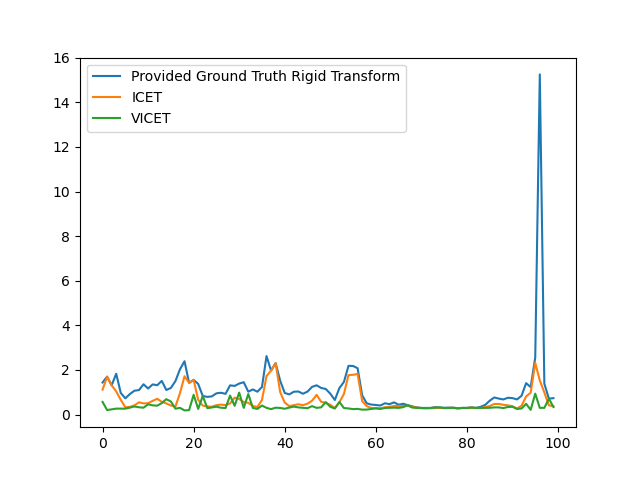

In [245]:
# np.savetxt("results/raw_CD_06_950_v2.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_06_950_v2.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_06_950_v2.txt", VICET_CD_hist)

# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950.txt")

# #throw out obvious outliers
# bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
# bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]

VICET_CD_hist[VICET_CD_hist == 0.1 ] = 0.3

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

In [246]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))


 provided Ground Truth: 1.1528705739974976

 ICET: 0.6435584750771522

 VICET: 0.35736133697628975


# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [134]:
runlen = 10 #100
start_idx = 2700 #2000 #one full loop running around the quad

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#     #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
#     #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
#     #           this is becuase overall trajectory begins at 05 (at least I think that's why)
#     #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
#     scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
#     submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 20, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        err_hist[idx] = 1
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    


 
 Frame # 2700 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [-0.5332 -0.4805  0.1275  0.044   0.047   0.0029] 
 [ 2.0513  0.1411 -0.1394 -0.0032 -0.0148 -0.0538]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.5617 -0.9597  0.1367  0.0629  0.0684  0.0136] 
 [ 2.4229  1.1594 -0.2173 -0.0126 -0.0282 -0.1026]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.6309 -1.0145  0.1469  0.0657  0.0772  0.0044] 
 [ 2.4022  1.1476 -0.2425 -0.0164 -0.0329 -0.1188]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.6839 -1.1511  0.154   0.0662  0.0791  0.0012] 
 [ 2.5164  1.4484 -0.2335 -0.0165 -0.0331 -0.1245]


LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.1109 -0.5061  0.0785  0.0195 -0.0022 -0.064 ] 
 [-0.4067 -1.0394 -0.0595  0.0014 -0.0209  0.0223]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.1144 -0.5172  0.0763  0.019  -0.0027 -0.0633] 
 [-0.4043 -1.0336 -0.0439  0.0016 -0.0184  0.0214]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.1278 -0.5387  0.0789  0.0196 -0.0023 -0.064 ] 
 [-0.3884 -0.9821 -0.0614  0.0007 -0.0204  0.0236]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.1292 -0.5443  0.0798  0.0193 -0.0019 -0.0632] 
 [-0.3845 -0.9738 -0.057   0.0014 -0.0204  0.0231]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.396  -1.9294  0.0762 -0.0839 -0.1053 -0.0043] 
 [ 1.1407  3.5799 -0.0692  0.0113 -0.0077 -0.0486]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.399  -1.9512  0.0801 -0.0822 -0.1034 -0.004 ] 
 [ 1.1388  3.57   -0.0849  0.0051 -0.0103 -0.0521]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.4121 -1.959   0.0755 -0.0806 -0.1032 -0.0044] 
 [ 1.1333  3.5671 -0.0873  0.001  -0.0112 -0.0506]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.4116 -1.969   0.078  -0.0805 -0.1023 -0.0043] 
 [ 1.1332  3.5627 -0.0951  0.0001 -0.0124 -0.0509]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residua

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.49847743 -0.97491306  0.09392086 -0.14564876 -0.13450377  0.00295201], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 176553.296875
Chamfer Distance after VICET: 
: 12971.2421875
Chamfer Distance after ICET: 
: 35281.203125

 Normalized OG CD: 
 tensor(3.1592)

 Normalized VICET CD: 
 tensor(0.2321)

 Normalized ICET CD: 
 tensor(0.6313)

 
 Frame # 2705 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [ 0.1258 -0.087  -0.0217 -0.1146 -0.0908  0.0024] 
 [-0.1498 -0.3342  0.0155  0.0862  0.0047  0.0099]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2029 -0.1056 -0.0022 -0.2169 -0.1711  0.002 ] 
 [-0.3546 -0.7509  0.3131  0.1476  0.0422  0.004 ]
~~~~~~~

LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.9627 -0.0788  0.0492 -0.2551 -0.1988 -0.0098] 
 [-3.4071 -0.9778  0.0006  0.0137  0.0091  0.2184]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.959  -0.07    0.054  -0.2558 -0.1978 -0.0168] 
 [-3.4077 -0.9732 -0.009   0.0146  0.0075  0.2367]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.8882 -0.0528  0.058  -0.2594 -0.1967 -0.0245] 
 [-3.4322 -0.9614 -0.0116  0.0221  0.0079  0.2616]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [ 0.9646 -0.0807  0.061  -0.2625 -0.1956 -0.0216] 
 [-3.4067 -0.9765 -0.0057  0.0279  0.0099  0.2572]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [-0.1134  0.9801  0.092  -0.2341 -0.2436  0.0528] 
 [-1.3809 -3.5448 -0.3001 -0.048   0.0009  0.0876]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.0928  0.7991  0.0871 -0.2286 -0.2468  0.0657] 
 [-1.2967 -3.3219 -0.2876 -0.046  -0.0003  0.0867]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.0078  0.5915  0.0812 -0.2259 -0.2508  0.0842] 
 [-1.1916 -2.9062 -0.2661 -0.0461 -0.0008  0.064 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 residuals (672, 1)

 delta_A
 (12,)
A: 
 [-0.0059  0.2902  0.076  -0.2245 -0.2565  0.0996] 
 [-1.082  -2.3001 -0.2422 -0.0381  0.0009  0.0356]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residual

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.6498808  -0.84714484  0.07539827 -0.27074036 -0.23115629  0.16216768], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 659114.8125
Chamfer Distance after VICET: 
: 39984.41015625
Chamfer Distance after ICET: 
: 33550.875

 Normalized OG CD: 
 tensor(11.7561)

 Normalized VICET CD: 
 tensor(0.7132)

 Normalized ICET CD: 
 tensor(0.5984)


<IPython.core.display.Javascript object>


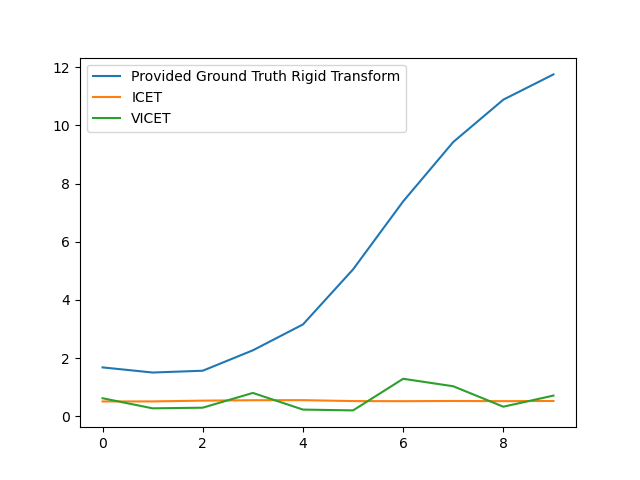

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [138]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [137]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))


 provided Ground Truth: 5.470185375213623

 ICET: 0.5297537922859192

 VICET: 0.5804258897900582


In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [215]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24

 estimated solution vector X: 
 tf.Tensor([ 0.34730822  0.15684706  0.15826373 -0.1183593   0.05592397  0.04882153], shape=(6,), dtype=float32)

 predicted standard deviations of error: 
 tf.Tensor([0.00179726 0.00215927 0.00137016 0.00012255 0.00007353 0.00010428], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

In [100]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

# #matt's attempt:
# rot_m = R.from_quat(gt[idx,5:]).as_matrix()
# newscan_mapframe = (pc1 @ rot_m) + gt[idx,2:5]
# disp.append(Points(newscan_mapframe, c = 'blue',r = 2))

#kitware code
newscan_mapframe = (poses[idx] @ np.append(pc1, np.zeros([len(pc1),1]), axis=1).T).T
print(newscan_mapframe)
disp.append(Points(newscan_mapframe[:,:3], c = 'blue',r = 2))

#draw trajectory of platform according to <gt>
disp.append(Points(gt[2200:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[idx+offset,2:5][None,:], r=10, c = 'red'))

#draw arrows showing heading
for i in range(50):
    rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
    arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
    disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


[[ 7.11846899 -0.3801981   2.26566858  0.        ]
 [ 7.25993846 -0.1121361   2.22134586  0.        ]
 [ 7.40199     0.16545664  2.18314785  0.        ]
 ...
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)